In [2]:
# Import statements
import os
import numpy as np
import scipy.ndimage
import scipy.spatial
import skimage.feature
import skimage.filters
import skimage.morphology
import skimage.segmentation
import skimage.io
import glob
import bebi103
import pandas as pd
import numba
import emcee
import collections
import itertools
import math
import scipy.stats as st

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# This is to enable inline displays 
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

import ipywidgets

## Data processing
Attribution: Anvita, Preethi

We're going to begin by loading in the daytime and nighttime images by using glob

In [2]:
# The directory containing daytime data
data_dir_day = '../data/Cassiopea_Pulsation/day'

# The directory containing nighttime data
data_dir_night = '../data/Cassiopea_Pulsation/night'

# Glob string for images
im_glob_day = os.path.join(data_dir_day, '*.TIF')
im_glob_night = os.path.join(data_dir_night, '*.TIF')

# Get list of files in directory
im_list_day = glob.glob(im_glob_day)
im_list_night = glob.glob(im_glob_night)


Next, we want to see if all three R,G, B channels are the same. If they are, we can consider just one of the channels in our analysis

In [ ]:
im_day = skimage.io.imread(im_list_day[0])
im_night = skimage.io.imread(im_list_night[0])

# Test to see if each R, G, and B value is the same
print(((im_day[:,:,0] == im_day[:,:,1]) &  (im_day[:,:,1] == im_day[:,:,2])).all())

# Test to see if each R, G, and B value is the same
print(((im_night[:,:,0] == im_night[:,:,1]) &  (im_night[:,:,1] == im_night[:,:,2])).all())

They are the same! So we can reload the images into a image collection and just use one channel using the*squish_rgb* function Justin wrote

In [ ]:
def squish_rgb(fname, **kwargs):
    """
    Only take one channel. (Need to explicitly have the **kwargs to play
    nicely with skimage.io.ImageCollection.)
    """
    im = skimage.io.imread(fname)
    return im[:,:,0]

# Image collection storing day images
ic_day = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=squish_rgb)
# Image collection storing night images
ic_night = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=squish_rgb)

We can load one of the day images to take a look


In [ ]:
with sns.axes_style('white'):
    skimage.io.imshow(ic_day[0])

We see that our images have a lot of noise from uneven lighting. This makes them difficult to segment and it also means that simply summing the  pixel intensity of the whole condos ROIs isn't the best way to analyze these images. We can exclude the noise by defining our ROIs around the Jellyfish to eliminate the background

We want to define the ROIs around the jellyfish, so we watched the movie and found the frame where
the jellyfish were at their maximum diameter and clicked around the fish. We used plt.ginput() in the terminal to do so. The verticies we found are shown below. 


In [ ]:
# These are defined around the jellyfish to exclude noise

# Day Jellyfish 1 ROI coords:

day_jellyfish_1 = [(83.458238680760942, 164.49459886462444),
 (140.30875301147353, 167.77443622985783),
 (139.21547388972908, 209.31904285614786),
 (82.364959559016469, 209.31904285614786)]
 
# Day Jellyfish 2 ROI coords:

day_jellyfish_2 = [(245.26354869894294, 129.5096669688013),
 (295.55438829918876, 130.6029460905458),
 (295.55438829918876, 176.52066920381361),
 (243.07699045545405, 174.33411096032472)]

# Day Jellyfish 3 ROI coords:

day_jellyfish_3 = [(379.73688067351316, 131.69622521229024),
 (437.6806741259702, 134.97606257752369),
 (436.58739500422575, 181.987064812536),
 (380.8301597952576, 181.987064812536)]

# Day Jellyfish 4 ROI coords:

day_jellyfish_4 = [(514.21021264808337, 86.871781220766877),
 (575.43384346577386, 89.058339464255766),
 (574.34056434402942, 159.02820325590204),
 (513.11693352633893, 159.02820325590204)]

# Day Jellyfish 5 ROI coords:

day_jellyfish_5 = [(96.577588141694619, 250.86364948243778),
 (174.20040578555222, 254.14348684767123),
 (168.73401017682983, 343.79237483071802),
 (92.204471654716727, 337.23270010025118)]

# Day Jellyfish 6 ROI coords:

day_jellyfish_6 = [(104.23054199390593, 254.14348684767123),
 (174.20040578555222, 258.51660333464912),
 (169.82728929857433, 337.23270010025118),
 (99.857425506928038, 332.85958361327329)]

# Day Jellyfish 7 ROI coords:

day_jellyfish_7 = [(428.93444115201441, 269.44939455209385),
 (494.5311884566828, 270.54267367383829),
 (493.43790933493835, 340.51253746548457),
 (428.93444115201441, 337.23270010025118)]

# Day Jellyfish 8 ROI coords:

day_jellyfish_8 = [(515.30349176982782, 243.2106956302265),
 (578.7136808310072, 247.58381211720439),
 (580.9002390744962, 300.0612099609391),
 (517.4900500133167, 298.96793083919465)]

In [ ]:
# Night Jellyfish 1 ROI coords:
night_jellyfish_1 = [(81.271680437271996, 161.21476149939105), (140.30875301147353, 164.49459886462444),
                   (139.21547388972908, 212.59888022138125), (80.178401315527523, 207.13248461265886)]
 
# Night Jellyfish 2 ROI coords:
night_jellyfish_2 = [(239.7971530902206, 125.13655048182341), (303.20734215140004, 130.6029460905458),
                   (301.0207839079111, 181.987064812536), (237.61059484673166, 178.70722744730261)]

# Night Jellyfish 3 ROI coords:

night_jellyfish_3 = [(378.64360155176871, 129.5096669688013),  (442.05379061294809, 133.88278345577919),
                   (442.05379061294809, 187.4534604212584), (374.27048506479082, 186.3601812995139)]

# Night Jellyfish 4 ROI coords:

night_jellyfish_4 = [(510.93037528284992, 86.871781220766877), (577.62040170926275, 86.871781220766877),
                   (576.52712258751831, 156.84164501241315), (513.11693352633893, 160.12148237764654)]

# Night Jellyfish 5 ROI coords:

night_jellyfish_5 = [(97.670867263439092, 248.67709123894889), (175.29368490729667, 249.77037036069333),
                   (168.73401017682983, 348.16549131769591), (93.2977507764612, 339.41925834374013)]

# Night Jellyfish 6 ROI coords:

night_jellyfish_6 = [(248.54338606417639, 290.22169786523887), (331.63259931675634, 294.59481435221676),
                   (330.5393201950119, 370.03107375258537), (240.89043221196505, 364.56467814386303)]

# Night Jellyfish 7 ROI coords:

night_jellyfish_7 = [(431.12099939550342, 269.44939455209385), (494.5311884566828, 269.44939455209385),
                   (492.34463021319391, 341.60581658722907), (427.84116203026997, 338.32597922199568)]

# Night Jellyfish 8 ROI coords:

night_jellyfish_8 = [(512.02365440459437, 244.303974751971), (586.36663468321854, 245.39725387371544),
                   (588.55319292670754, 303.34104732617254), (510.93037528284992, 302.24776820442804)]

We can use the *verts_roi* function that Justin wrote to define the ROIs

In [ ]:
# Jellyfish 1 during the Day
roi_day_1, roi_bbox_day_1, roi_box_day_1 = bebi103.verts_to_roi(day_jellyfish_1, *ic_day[0].shape)

# Jellyfish 2 during the Day
roi_day_2, roi_bbox_day_2, roi_box_day_2 = bebi103.verts_to_roi(day_jellyfish_2, *ic_day[0].shape)

# Etc. 
roi_day_3, roi_bbox_day_3, roi_box_day_3 = bebi103.verts_to_roi(day_jellyfish_3, *ic_day[0].shape)
roi_day_4, roi_bbox_day_4, roi_box_day_4 = bebi103.verts_to_roi(day_jellyfish_4, *ic_day[0].shape)
roi_day_5, roi_bbox_day_5, roi_box_day_5 = bebi103.verts_to_roi(day_jellyfish_5, *ic_day[0].shape)
roi_day_6, roi_bbox_day_6, roi_box_day_6 = bebi103.verts_to_roi(day_jellyfish_6, *ic_day[0].shape)
roi_day_7, roi_bbox_day_7, roi_box_day_7 = bebi103.verts_to_roi(day_jellyfish_7, *ic_day[0].shape)
roi_day_8, roi_bbox_day_8, roi_box_day_8 = bebi103.verts_to_roi(day_jellyfish_8, *ic_day[0].shape)

In [ ]:
# Jellyfish 1 during the night
roi_night_1, roi_bbox_night_1, roi_box_night_1 = bebi103.verts_to_roi(night_jellyfish_1, *ic_night[0].shape)

# Jellyfish 2 during the night
roi_night_2, roi_bbox_night_2, roi_box_night_2 = bebi103.verts_to_roi(night_jellyfish_2, *ic_night[0].shape)

# Etc. 
roi_night_3, roi_bbox_night_3, roi_box_night_3 = bebi103.verts_to_roi(night_jellyfish_3, *ic_night[0].shape)
roi_night_4, roi_bbox_night_4, roi_box_night_4 = bebi103.verts_to_roi(night_jellyfish_4, *ic_night[0].shape)
roi_night_5, roi_bbox_night_5, roi_box_night_5 = bebi103.verts_to_roi(night_jellyfish_5, *ic_night[0].shape)
roi_night_6, roi_bbox_night_6, roi_box_night_6 = bebi103.verts_to_roi(night_jellyfish_6, *ic_night[0].shape)
roi_night_7, roi_bbox_night_7, roi_box_night_7 = bebi103.verts_to_roi(night_jellyfish_7, *ic_night[0].shape)
roi_night_8, roi_bbox_night_8, roi_box_night_8 = bebi103.verts_to_roi(night_jellyfish_8, *ic_night[0].shape)

We  modify our load_func for the ImageCollections to just load in the ROIs defined.

In [ ]:
# Define load_func that only gives region bounding ROI
def load_roi(fname, roi_bbox=None, **kwargs):
    """
    Image loading function to only load ROI.
    """
    if roi_bbox is None:
        return skimage.io.imread(fname)[:,:,0]
    else:
        return skimage.io.imread(fname)[:,:,0][roi_bbox]

In [ ]:
# Load image collection of just rois

# Jellyfish 1 during the day
day_jellyfish_1_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_1)
# Jellyfish 2 during the day
day_jellyfish_2_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_2)
# Jellyfish 3 during the day
day_jellyfish_3_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_3)
# Jellyfish 4 during the day
day_jellyfish_4_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_4)
# Jellyfish 5 during the day
day_jellyfish_5_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_5)
# Jellyfish 6 during the day
day_jellyfish_6_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_6)
# Jellyfish 7 during the day
day_jellyfish_7_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_day_7)
# Jellyfish 8 during the day
day_jellyfish_8_rois = skimage.io.ImageCollection(im_glob_day, conserve_memory=True,
                                load_func=load_roi, roi_bbox=roi_bbox_day_8)


In [ ]:
# Load image collection of just rois

# Jellyfish 1 during the night
night_jellyfish_1_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_1)
# Jellyfish 2 during the night
night_jellyfish_2_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_2)
# Jellyfish 3 during the night
night_jellyfish_3_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_3)
# Jellyfish 4 during the night
night_jellyfish_4_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_4)
# Jellyfish 5 during the night
night_jellyfish_5_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_5)
# Jellyfish 6 during the night
night_jellyfish_6_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_6)
# Jellyfish 7 during the night
night_jellyfish_7_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_7)
# Jellyfish 8 during the night
night_jellyfish_8_rois = skimage.io.ImageCollection(im_glob_night, conserve_memory=True, 
                                load_func=load_roi, roi_bbox=roi_bbox_night_8)

To see what we mean by how we defined our ROIs, we can display one of them below:

In [ ]:
# This is the first jellyfish during the night
with sns.axes_style('white'):
    skimage.io.imshow(night_jellyfish_1_rois[0], cmap=plt.cm.gray)

We noticed that the jellyfish stopped pulsing when the jellyfish fell asleep. We can look at the pusling frequency over time and see if we see an obvious change when they fall asleep. We can roughly define this by summing the total pixel intensity in our ROIs  over time. Since we defined the ROIs around the jellyfish, we shouldn't be biased by the noise in the images.

In [5]:
fps = 15
# len(day_jellyfish_1_rois) = 4000
# We hardcoded this part so it still worked even when we saved the data as a csv
# The length of all of the image collections is 4000
t = np.arange(0, 4000) / fps

We wrote the following the code to sum the total pixel intensities for all 8 jellyfish during the note

### WARNING: This can take a while to run

In [ ]:
# Set up NumPy array to store total pixel intensity
total_int_night_1 = np.empty(len(t)) # for jellyfish 1 during the night
total_int_night_2 = np.empty(len(t)) # for jellyfish 2 during the night
total_int_night_3 = np.empty(len(t)) # etc
total_int_night_4 = np.empty(len(t))
total_int_night_5 = np.empty(len(t))
total_int_night_6 = np.empty(len(t))
total_int_night_7 = np.empty(len(t))
total_int_night_8 = np.empty(len(t))

# To store the intensities for all 8 jellyfish during the night
night_intensities = [total_int_night_1, total_int_night_2, total_int_night_3, total_int_night_4, total_int_night_5, 
                     total_int_night_6, total_int_night_7, total_int_night_8]

# To store ROI boxes for all 8 jellyfish
night_roi_boxes = [roi_box_night_1, roi_box_night_2, roi_box_night_3, roi_box_night_4, roi_box_night_5, 
                   roi_box_night_6,roi_box_night_7, roi_box_night_8]

# To store all the image collections for all 8 jellyfish
night_rois_ics = [night_jellyfish_1_rois, night_jellyfish_2_rois, night_jellyfish_3_rois, night_jellyfish_4_rois,
                 night_jellyfish_5_rois, night_jellyfish_6_rois, night_jellyfish_7_rois, night_jellyfish_8_rois]

# Look through and compute total intensity in the ROIs of all 8 jellyfish
for j in range(len(night_intensities)):
    for i, im in enumerate(night_rois_ics[j]):
        night_intensities[j][i] = night_rois_ics[j][i][night_roi_boxes[j]].sum()


We can look at *night_intensities* array below. This stores the intensities for all 8 jellyfish

In [ ]:
night_intensities

We repeat the same process for the day. Again, the same warning applies. 

### WARNING: This can take a while to run

In [ ]:
# Set up NumPy array to store total pixel intensity
total_int_day_1 = np.empty(len(t)) # for jellyfish 1 during the day
total_int_day_2 = np.empty(len(t)) # for jellyfish 2 during the day
total_int_day_3 = np.empty(len(t)) # etc 
total_int_day_4 = np.empty(len(t))
total_int_day_5 = np.empty(len(t))
total_int_day_6 = np.empty(len(t))
total_int_day_7 = np.empty(len(t))
total_int_day_8 = np.empty(len(t))

# To store the intensities for all 8 jellyfish
day_intensities = [total_int_day_1, total_int_day_2, total_int_day_3, total_int_day_4, total_int_day_5, 
                     total_int_day_6, total_int_day_7, total_int_day_8]

# To store ROI boxes for all 8 jellyfish
day_roi_boxes = [roi_box_day_1, roi_box_day_2, roi_box_day_3, roi_box_day_4, roi_box_day_5, 
                   roi_box_day_6,roi_box_day_7, roi_box_day_8]

# To store all the image collections for all 8 jellyfish
day_rois_ics = [day_jellyfish_1_rois, day_jellyfish_2_rois, day_jellyfish_3_rois, day_jellyfish_4_rois,
                 day_jellyfish_5_rois, day_jellyfish_6_rois, day_jellyfish_7_rois, day_jellyfish_8_rois]

# Look through and compute total intensity in the ROIs of all 8 jellyfish
for j in range(len(day_intensities)):
    for i, im in enumerate(day_rois_ics[j]):
        day_intensities[j][i] = day_rois_ics[j][i][day_roi_boxes[j]].sum()

We wrote the following function to normalize the intensities by subtracting the mean intensity and rescaling the data so it goes from -1 to 1 for each jellyfish. 

In [ ]:
def normalize_intensity(intensities):
    for i in range(len(intensities)):
        intensities[i] -= intensities[i].mean()
        intensities[i] = 1 + 2 / (intensities[i].max() - intensities[i].min()) \
                * (intensities[i] - intensities[i].max())
    return intensities

In [ ]:
normalized_day_intensities = normalize_intensity(day_intensities)
normalized_night_intensities = normalize_intensity(night_intensities)

Since the above code takes forever to run, we saved the arrays as csvs and used the csvs for the rest of our analysis

In [ ]:
#np.savetxt('Day_intensities.csv', normalized_day_intensities, fmt='%.18e', delimiter=',', newline='\n', header='', footer='', comments='# ')
#np.savetxt('Night_intensities.csv', normalized_night_intensities, fmt='%.18e', delimiter=',', newline='\n', header='', footer='', comments='# ')

We loaded the csvs below. We used the variables *from_data_normalized_night_intensities* and *from_data_normalized_day_intensities* for the rest of our analysis, so we wouldn't have to rerun the finding intensities code everytime we  started the assignment

In [4]:
from_data_normalized_night_intensities = np.genfromtxt ('Night_Intensities.csv', delimiter=",")

from_data_normalized_day_intensities = np.genfromtxt ('Day_Intensities.csv', delimiter=",")

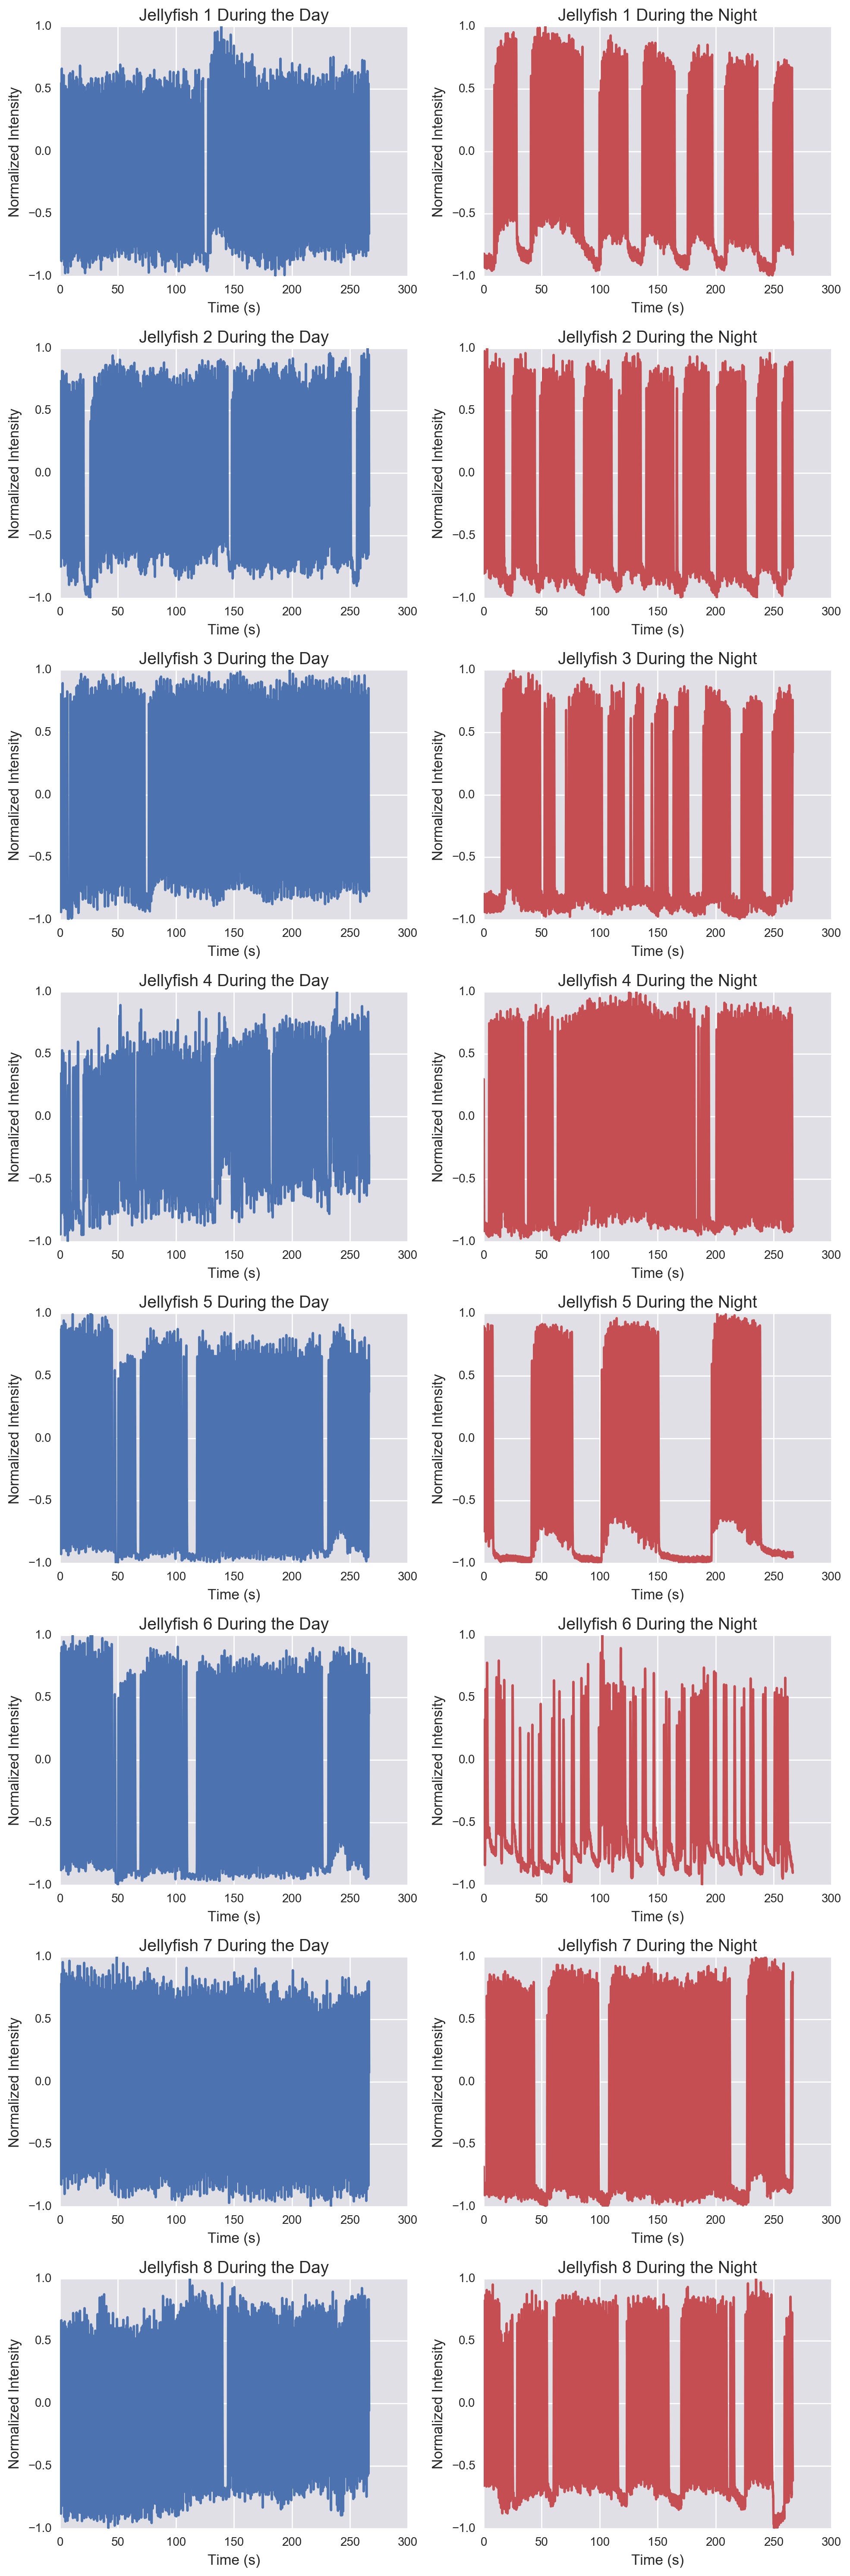

In [11]:
fig, ax = plt.subplots(8,2, figsize=(10, 30))
for i in range(8):
    ax[(i,0)].plot(t, from_data_normalized_day_intensities[i],  '.', color=sns.color_palette()[0], markersize=1, linestyle='-')
    ax[(i,1)].plot(t, from_data_normalized_night_intensities[i], '.', color=sns.color_palette()[2], 
                       label='Jellyfish {} During the Night'.format(i+1), markersize=1, linestyle='-')
    ax[(i,0)].set_xlabel('Time (s)', size=12)
    ax[(i,1)].set_xlabel('Time (s)', size=12)
    ax[(i,0)].set_ylabel('Normalized Intensity', size=12)
    ax[(i,1)].set_ylabel('Normalized Intensity', size=12)
    ax[(i,0)].set_title('Jellyfish {} During the Day'.format(i+1), size=14)
    ax[(i,1)].set_title('Jellyfish {} During the Night'.format(i+1), size=14)
    

plt.tight_layout()



Wow! It looks like during the day, the jellyfish are effectively always pulsing (hence the oscillations we observe in the intensity). However, at night, there are periods where the intensitiy is constant: the jellyfish is not pulsing then, so it could be asleep. We see that the sleep patterns are not the same across the eight jellyfish. In fact, Jellyfish 4 looks like a Caltech jellyfish. :)

We can find the periods where the fish are asleep by essentially using lowpass filtering. We want to find the troughs in our data, where it seems like the jellyfish is asleep. We will define a threshold of 0, and collect points while the intensity is still less than this threshold. 

When the jellyfish is asleep, there will be a lot of points collected into the spike since the intensity is consistently below the threshold before it spikes up again, as opposed to the constant oscillations while it is awake. 

<div class="alert alert-info"> <left>
MR comment:
<p>
Super interesting! Those behaviors are so wildly different.
</p>
BTW, I liked the Caltech jellyfish joke.
</left></div> 

In [12]:
# Threshold below which spike has to drop (intensity)
thresh = 0

# List to store downward spikes for the 8 jellyfish during the day
dfs_spikes_day =[]

# Use a NumPy array for speed in looping
V = from_data_normalized_day_intensities
for j in range (8):
    # Initialize while loop
    i = 1
    spike = 0
    # DataFrame to store spikes
    df_spike = pd.DataFrame(columns=['spike', 't (s)', 'intensity'])
    while i < len(V[j]):
        if V[j][i] < thresh:
            # Found a spike, get crossings
            cross_1 = i
            while (i < 4000) and (V[j][i] < thresh):
                if i == (len(V[j])-1): # we've reached the end
                    break
                i += 1
            cross_2 = i

            # Store perintent quantities in DataFrame
            t_in = t[cross_1:cross_2]
            V_in = V[j][cross_1:cross_2]
            data={'t (s)': t_in,
                  'intensity': V_in,
                  'spike': spike * np.ones_like(t_in, dtype=int)}
            df_add = pd.DataFrame(data)
            df_spike = pd.concat((df_spike, df_add))
            
            spike += 1

        i += 1
    dfs_spikes_day.append(df_spike)

In [13]:
# List to store downward spikes for the 8 jellyfish during the night
dfs_spikes_night =[]

# Use a NumPy array for speed in looping
W = from_data_normalized_night_intensities

for j in range (8):
    # Initialize while loop
    i = 1
    spike = 0
    # DataFrame to store spikes
    df_spike = pd.DataFrame(columns=['spike', 't (s)', 'intensity'])
    while i < len(V[j]):
        if W[j][i] < thresh:
            # Found a spike, get crossings
            cross_1 = i
            while (i < 4000) and (W[j][i] < thresh):
                if i == (len(W[j])-1): # we've reached the end
                    break
                i += 1
            cross_2 = i

            # Store perintent quantities in DataFrame
            t_in = t[cross_1:cross_2]
            W_in = W[j][cross_1:cross_2]
            data={'t (s)': t_in,
                  'intensity': W_in,
                  'spike': spike * np.ones_like(t_in, dtype=int)}
            df_add = pd.DataFrame(data)
            df_spike = pd.concat((df_spike, df_add))
            
            spike += 1

        i += 1
    dfs_spikes_night.append(df_spike)

Next, we're going to find the width of each spike by taking the difference between the last point and first point for each spike. If the jellyfish is simply pulsing, then the width of the spike would be small since the intensity is oscillating. However, if the jellyfish is asleep, the width of the spike should be big since the intensity is constant for a while until it wakes up, and the intensity spikes up again. We wrote code to find the difference below. 

In [18]:
# List to store differences during the day
df_differences_day =[]

for j in range(8):
    df_spike = dfs_spikes_day[j]
    df_differences = pd.DataFrame(columns=['First_spike', 'Second_spike', 'Difference', 'Jellyfish Number', 'Day_or_Night'])
    
    for i,s in enumerate(df_spike['spike'].unique()):
        spike_inds = (df_spike['spike'] == s)
        df_spike_i = df_spike.loc[spike_inds,:]
        # Subtracting last point - first point
        diff = df_spike_i['t (s)'][df_spike_i.index[-1]] - df_spike_i['t (s)'][df_spike_i.index[0]]
        data={'First_spike': [s],
              'Second_spike': [s+1],
              'Difference': [diff],
              'Jellyfish Number': j+1,
              'Day_or_Night': 'Day'
             }
        df_add = pd.DataFrame(data)
        df_differences = pd.concat((df_differences, df_add))
    df_differences_day.append(df_differences)

In [19]:
# List to store differences during the night
df_differences_night =[]

for j in range(8):
    df_spike = dfs_spikes_night[j]
    df_differences = pd.DataFrame(columns=['First_spike', 'Second_spike','Difference', 'Jellyfish Number', 'Day_or_Night'])

    for i,s in enumerate(df_spike['spike'].unique()):
        spike_inds = (df_spike['spike'] == s)
        df_spike_i = df_spike.loc[spike_inds,:]
        # Subtracting last point - first point
        diff = df_spike_i['t (s)'][df_spike_i.index[-1]] - df_spike_i['t (s)'][df_spike_i.index[0]]
        data={'First_spike': [s],
              'Second_spike': [s+1],
              'Difference': [diff],
              'Jellyfish Number': j+1,
              'Day_or_Night': 'Night'
             }
        df_add = pd.DataFrame(data)
        df_differences = pd.concat((df_differences, df_add))
    df_differences_night.append(df_differences)

At this point, we're going to tidy our lists of dataframes into a final dataframe that contains everything


In [20]:
df_final_jellyfish =  pd.DataFrame(columns=['Day_or_Night','Difference', 'First_spike',  'Jellyfish Number', 'Second_spike' ])
for i in range(8):
    df_final_jellyfish = pd.concat([df_final_jellyfish , df_differences_day[i]])
    df_final_jellyfish = pd.concat([df_final_jellyfish , df_differences_night[i]]) 

In [27]:
df_final_jellyfish

Day_or_Night  Difference  First_spike  Jellyfish Number  Second_spike
0           Day    0.400000          0.0               1.0           1.0
0           Day    0.400000          1.0               1.0           2.0
0           Day    0.400000          2.0               1.0           3.0
0           Day    0.400000          3.0               1.0           4.0
0           Day    0.400000          4.0               1.0           5.0
0           Day    0.400000          5.0               1.0           6.0
0           Day    0.400000          6.0               1.0           7.0
0           Day    0.400000          7.0               1.0           8.0
0           Day    0.400000          8.0               1.0           9.0
0           Day    0.400000          9.0               1.0          10.0
0           Day    0.333333         10.0               1.0          11.0
0           Day    0.333333         11.0               1.0          12.0
0           Day    0.400000         12.0               1.0          13.0
0           Day    0.333333         13.0               1.0          14.0
0           Day    0.333333         14.0               1.0          15.0
0           Day    0.400000         15.0               1.0          16.0
0           Day    0.400000         16.0               1.0          17.0
0           Day    0.333333         17.0               1.0          18.0
0           Day    0.333333         18.0               1.0          19.0
0           Day    0.333333         19.0               1.0          20.0
0           Day    0.400000         20.0               1.0          21.0
0           Day    0.333333         21.0               1.0          22.0
0           Day    0.333333         22.0               1.0          23.0
0           Day    0.333333         23.0               1.0          24.0
0           Day    0.400000         24.0               1.0          25.0
0           Day    0.400000         25.0               1.0          26.0
0           Day    0.333333         26.0               1.0          27.0
0           Day    0.466667         27.0               1.0          28.0
0           Day    0.466667         28.0               1.0          29.0
0           Day    0.400000         29.0               1.0          30.0
..          ...         ...          ...               ...           ...
0         Night    0.866667        165.0               8.0         166.0
0         Night    0.800000        166.0               8.0         167.0
0         Night    9.533333        167.0               8.0         168.0
0         Night    0.600000        168.0               8.0         169.0
0         Night    0.400000        169.0               8.0         170.0
0         Night    0.533333        170.0               8.0         171.0
0         Night    0.466667        171.0               8.0         172.0
0         Night    0.400000        172.0               8.0         173.0
0         Night    0.400000        173.0               8.0         174.0
0         Night    0.400000        174.0               8.0         175.0
0         Night    0.400000        175.0               8.0         176.0
0         Night    0.466667        176.0               8.0         177.0
0         Night    0.466667        177.0               8.0         178.0
0         Night    0.400000        178.0               8.0         179.0
0         Night    0.333333        179.0               8.0         180.0
0         Night    0.466667        180.0               8.0         181.0
0         Night    0.466667        181.0               8.0         182.0
0         Night    0.533333        182.0               8.0         183.0
0         Night    0.533333        183.0               8.0         184.0
0         Night    0.600000        184.0               8.0         185.0
0         Night    0.533333        185.0               8.0         186.0
0         Night    0.533333        186.0               8.0         187.0
0         Night    0.600000        187.0               8.0   

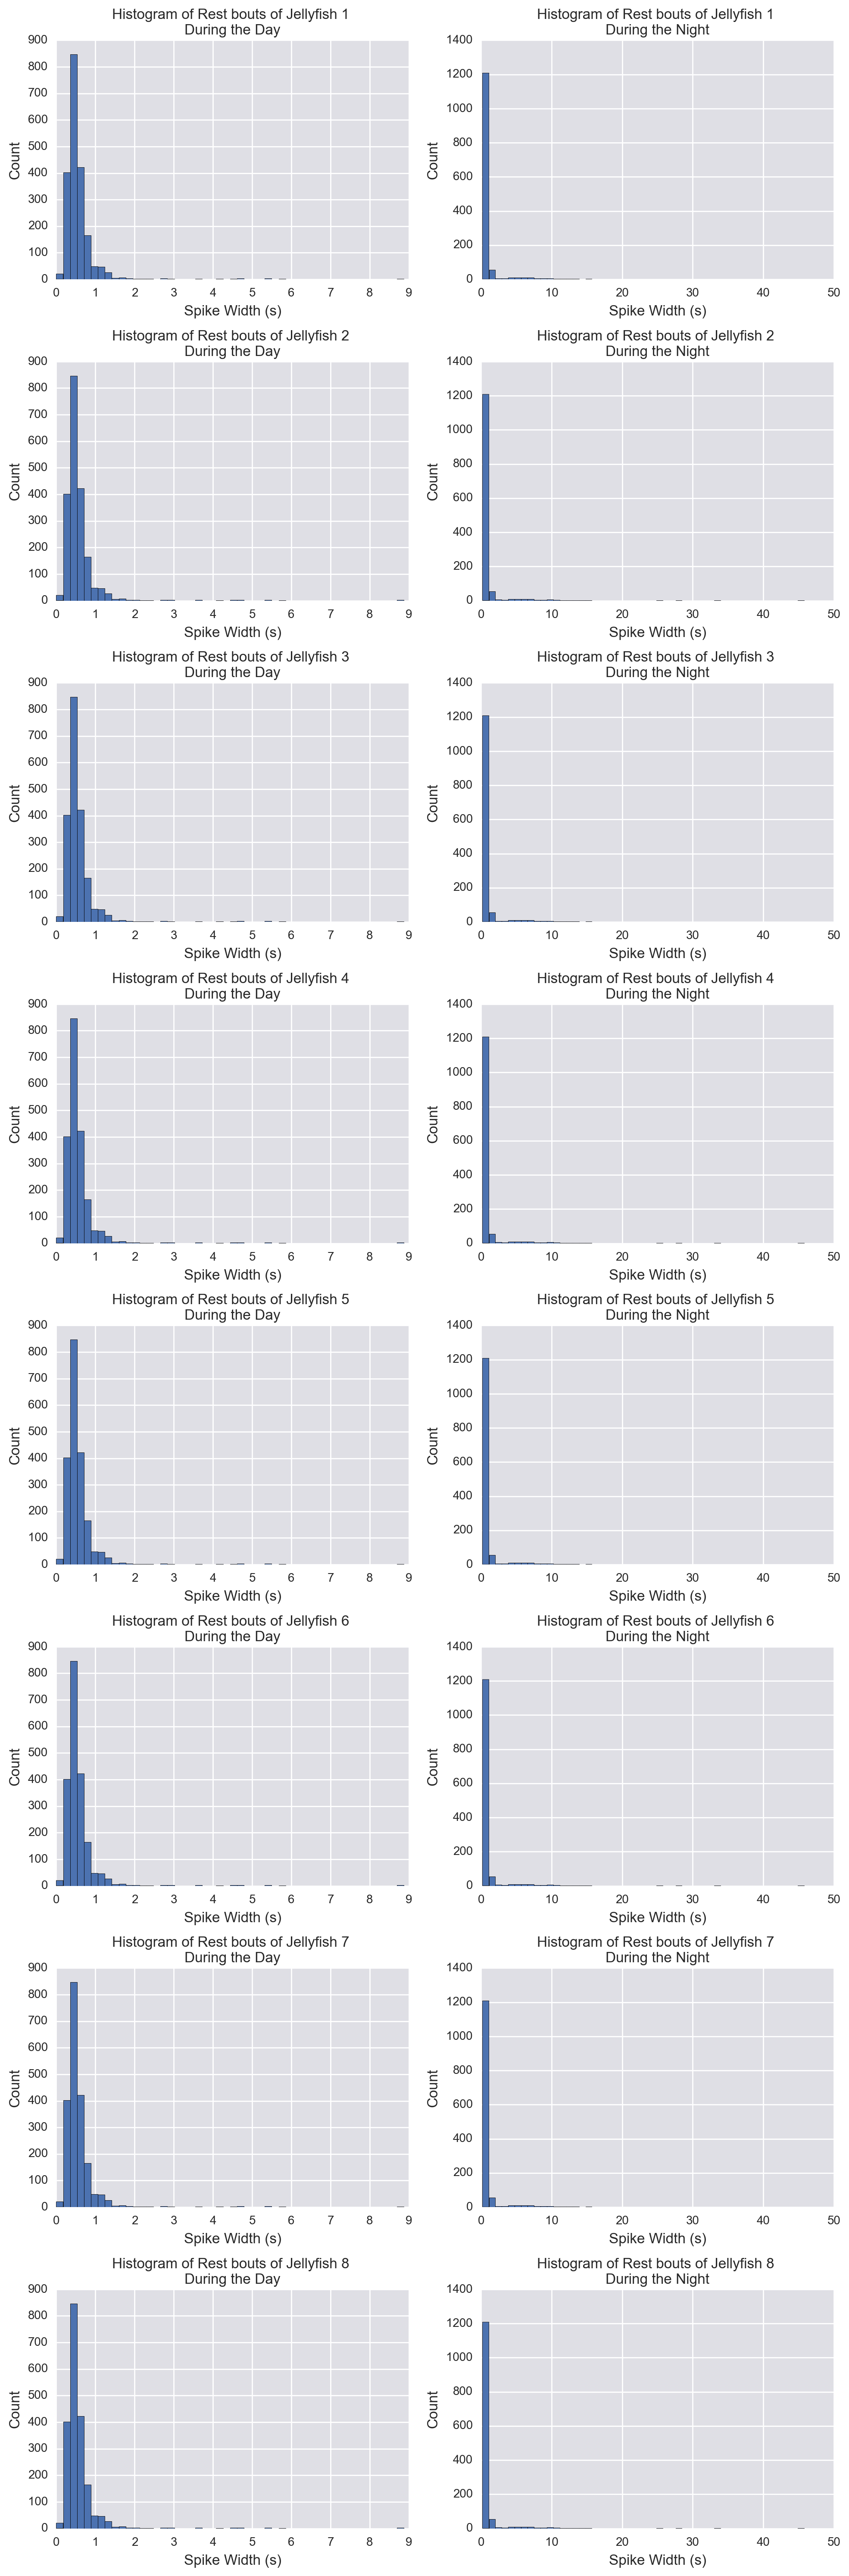

In [21]:
fig, ax = plt.subplots(8,2, figsize=(10, 30))
for i in range(8):
    ax[(i,0)].hist(df_final_jellyfish.loc[df_final_jellyfish.Day_or_Night=='Day']['Difference'].values,  bins=50)
    ax[(i,1)].hist(df_final_jellyfish.loc[df_final_jellyfish.Day_or_Night=='Night']['Difference'].values,  bins=50)
    ax[(i,0)].set_xlabel('Spike Width (s)', size=12)
    ax[(i,1)].set_xlabel('Spike Width (s)', size=12)
    ax[(i,0)].set_ylabel('Count', size=12)
    ax[(i,1)].set_ylabel('Count', size=12)
    ax[(i,0)].set_title( 'Histogram of Rest bouts of Jellyfish {} \nDuring the Day'.format(i+1), size=12)
    ax[(i,1)].set_title('Histogram of Rest bouts of Jellyfish {} \nDuring the Night'.format(i+1), size=12)
    
plt.tight_layout()

<div class="alert alert-info"> <left>
MR comment:
<p>
I think a ECDF would be much useful here. you could plot them in the same plot and overlay day and night or different jellyfish in the same plot.
</p>
Also is a little bit hard to compare between awake and sleep since the x and the y axis are different for each plot. That's why an ECDF would be very useful in this case.
</left></div>


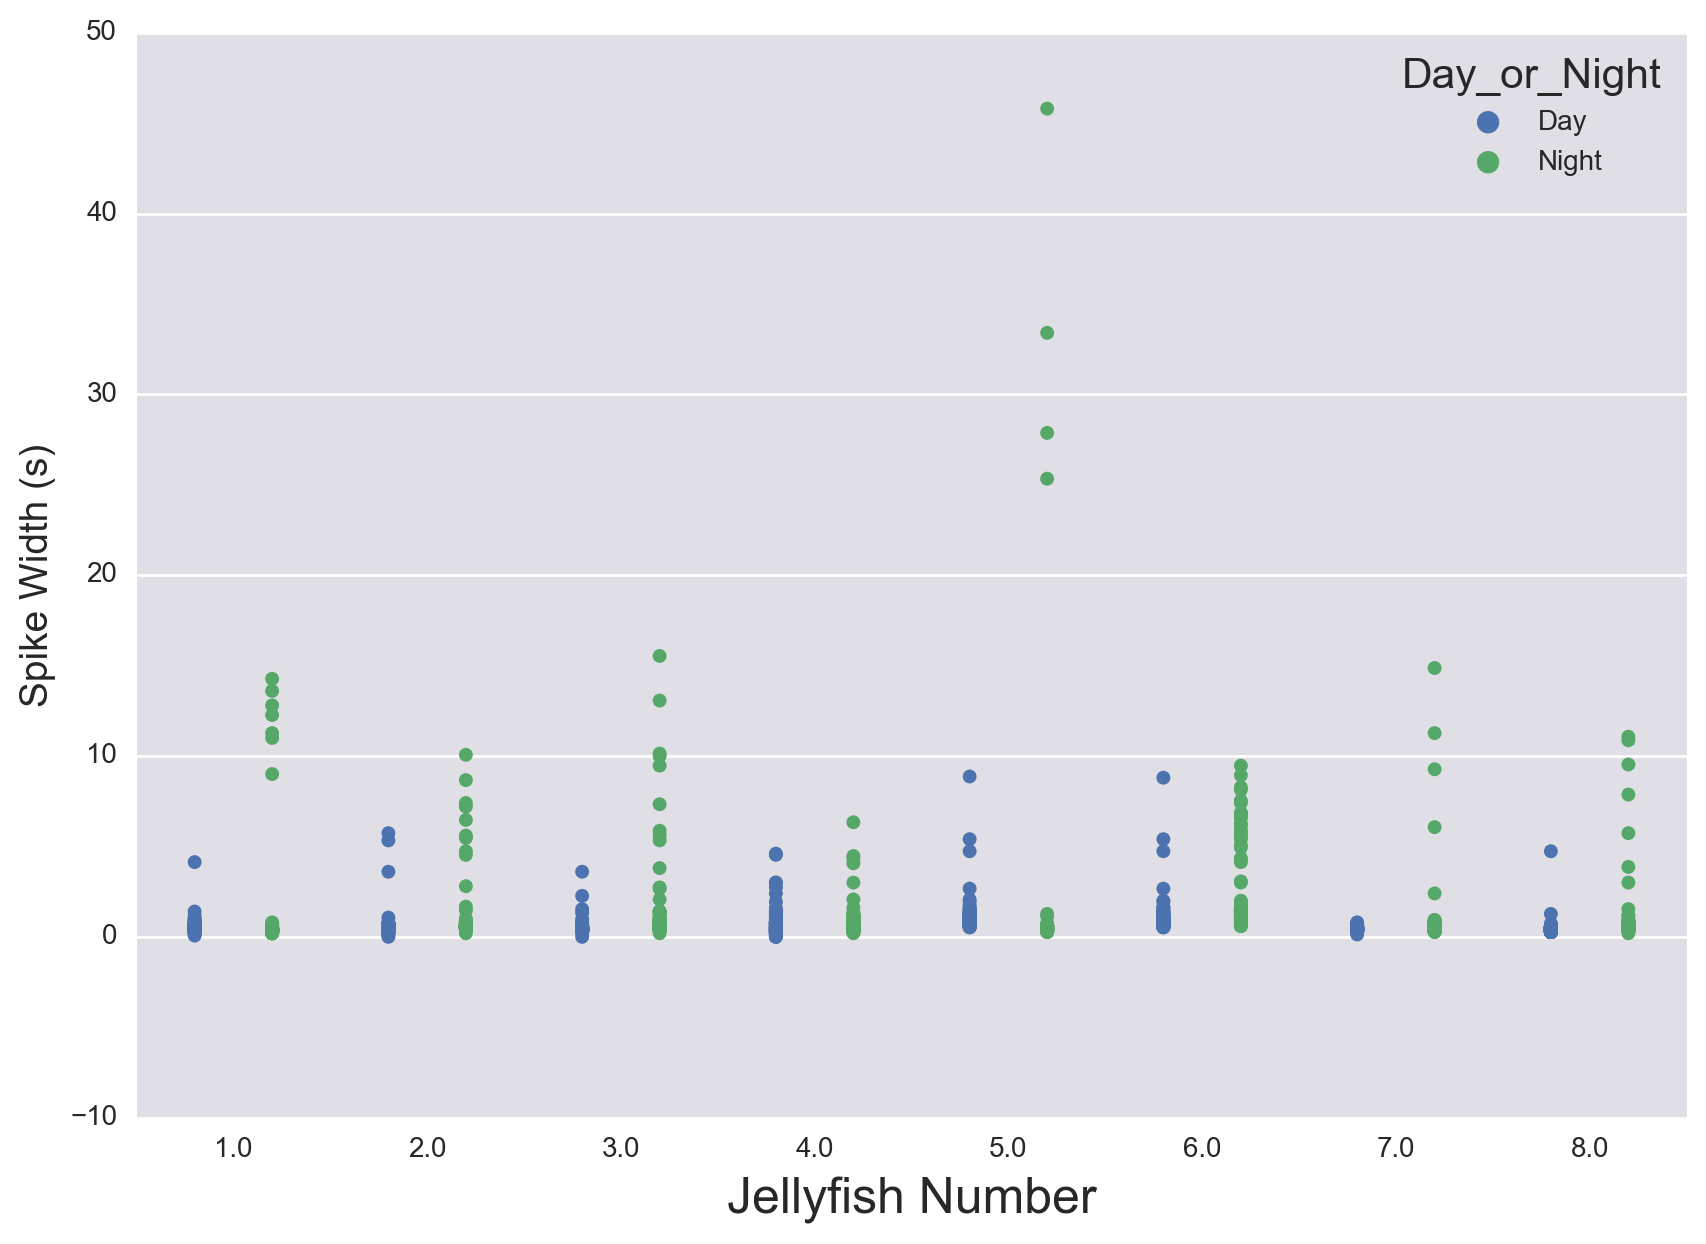

In [22]:
fig,ax=plt.subplots(figsize=(10,7))

inds = df_final_jellyfish['Difference'].values>2
ax = sns.stripplot(x ='Jellyfish Number', y='Difference', data= df_final_jellyfish, hue='Day_or_Night', split=True, ax=ax)
ax.set_ylabel('Spike Width (s)', size=14)


This plot corroborates what we saw in the plots of the intensities. To reiterate, we defined a threshold value of 0 and used 'lowpass filtering' to collect points while the intensity is still less than this threshold. We examined the time interval each spike spans (or the spike width) to determine potential rest bouts.  For the most part, the spikes are very short during the day (i.e. lasting about 1-2 seconds); in fact, they are often 0 during the day, because these spikes represent the pulsing of the jellyfish while it's awake. 

However, at night, we have spikes that last much longer (i.e. around 10 seconds, up to 50 seconds for Jellyfish 5). These periods represent the times when the jellyfish are asleep. From the jitter plot, we see that the time interval spanned by each spike is much greater at night then during the day.

The jitter plot also allows us to see how much each jellyfish sleeps relative to every other jellyfish. We see that jellyfish 2, 3, 4, 6, and 8 sleep much less than jellyfish 1, 5, and 7 (with jellyfish 5 being the Sleeping Beauty). However, during the daytime, all jellyfish seem to have similar pulsing activity.

<div class="alert alert-info"> <left>
MR comment:
<p>
Very interesting. Such a complex behavior right?
</p>
</left></div>

## Fitting an Exponential Distribution to the 'Rest Bouts'

Attribution: Preethi, Snigdha

Looking at the data, we can conclude that each event of the jellyfish “waking up” is a Poisson process (because sleep is a rather rare event, but since we measured the rest bout, we have to define waking up as our event and the rest bout as the waiting time.)

Because we want to measure the waiting time to each of these Poisson processes, we assume that the data can be fitted with an exponential distribution.

The only parameter that we need to write a prior for in an exponential distribution is $\tau$ (which is 1/$\lambda$, also known as the rate of arrivals), which is the waiting time to each Poisson process. $\tau$ is a scale parameter and we do not have preexisting information, so we assume a Jeffreys prior (which is uniform) and compute the log-likelihood as follows:

In [33]:
# Define priors and posteriors

def exp_logpmf(t, tau):
    """
    Exponential PMF evaluated a given t and tau.
    """
    return -(t / tau) - np.log(tau)

def log_likelihood_exp(params, t):
    """
    Log likelihood for exponential distributed parameters.
    """
    tau = params
    return np.sum(exp_logpmf(t, tau))

def log_prior_tau(params):
    """
    Log prior for exponentially distributed microtubule catastrophe.
    """
    tau = params
    tau = params
    if tau <= 0.1:
        return -np.inf
    return 0

def log_posterior_exp(params, t):
    """
    Log posterior for negative binomials.
    """
    lp = log_prior_tau(params)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_exp(params, t)

In [24]:
def sample_mcmc(t, n_walkers=50, n_burn=15000, n_steps=30000):
    """
    Sample postrior using MCMC.
    """
    # Arguments for posterior
    args = (t,)
    
    # Parameters and how we start them
    p_dict = collections.OrderedDict([('tau', (np.random.uniform, (0.0001, 1000))),])
    
    df_mcmc = bebi103.run_ensemble_emcee(log_posterior_exp, n_burn, n_steps, 
                                        n_walkers, p_dict=p_dict, args=args)
    # Compute mode and HPD
    mode_ind = np.where(
        np.isclose(df_mcmc['lnprob'], df_mcmc['lnprob'].max()))[0][0]
    mode_tau = df_mcmc.loc[mode_ind, 'tau']
    hpd_tau = bebi103.hpd(df_mcmc['tau'].values, 0.68)
    
    return df_mcmc, mode_tau, hpd_tau

In [29]:
# Perform MCMC sampling for each model (Day)

df_tau_day = pd.DataFrame(columns=['HPD', 'Mode', 'Tau', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_tau, hpd_tau = sample_mcmc(df_differences_day[j]['Difference'].values)
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']]
    data = {'HPD': [hpd_tau],
           'Mode': [mode_tau],
           'Tau': [est_tau],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_day = pd.concat((df_tau_day, df_add))
    

In [30]:
df_tau_day

HPD  Jellyfish      Mode  \
0  [0.450790611411, 0.506145469816]        0.0  0.476278   
0  [0.434083533869, 0.488267856032]        1.0  0.459648   
0  [0.431839054837, 0.485121751611]        2.0  0.456528   
0  [0.583629315183, 0.668460777823]        3.0  0.624989   
0   [0.905512825125, 1.05667158299]        4.0  0.979462   
0   [0.878669320363, 1.02602665857]        5.0  0.948831   
0  [0.413056608055, 0.465060384393]        6.0  0.437284   
0   [0.403101610971, 0.45271163455]        7.0  0.427222   

                                             Tau  
0   tau    0.477181
Name: 791459, dtype: float64  
0   tau    0.459722
Name: 435218, dtype: float64  
0   tau    0.457047
Name: 271780, dtype: float64  
0   tau    0.623853
Name: 176979, dtype: float64  
0   tau    0.975249
Name: 746190, dtype: float64  
0  tau    0.949301
Name: 1260868, dtype: float64  
0   tau    0.438028
Name: 680256, dtype: float64  
0  tau    0.426893
Name: 1188385, dtype: float64

In [31]:
# Perform MCMC sampling for each model (Night)

df_tau_night = pd.DataFrame(columns=['HPD', 'Mode', 'Tau', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_tau, hpd_tau = sample_mcmc(df_differences_night[j]['Difference'].values)
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']]
    data = {'HPD': [hpd_tau],
           'Mode': [mode_tau],
           'Tau': [est_tau],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_night = pd.concat((df_tau_night, df_add))

In [32]:
df_tau_night

HPD  Jellyfish      Mode  \
0  [0.725372913054, 0.834819119806]        0.0  0.779869   
0  [0.848758593019, 0.980627621338]        1.0  0.908543   
0     [1.06700115125, 1.2499837512]        2.0  1.147460   
0   [0.704937051811, 0.81444327203]        3.0  0.753963   
0     [1.45034430554, 1.7478787442]        4.0  1.579726   
0    [2.52745697789, 3.17050721931]        5.0  2.837861   
0  [0.716374030062, 0.823202572545]        6.0  0.767118   
0  [0.752853596223, 0.869180010581]        7.0  0.808750   

                                             Tau  
0  tau    0.777228
Name: 1384266, dtype: float64  
0   tau    0.912042
Name: 801305, dtype: float64  
0  tau    1.152795
Name: 1343876, dtype: float64  
0   tau    0.756719
Name: 140883, dtype: float64  
0   tau    1.586207
Name: 296833, dtype: float64  
0  tau    2.822784
Name: 1120884, dtype: float64  
0  tau    0.766667
Name: 1155788, dtype: float64  
0  tau    0.808205
Name: 1076463, dtype: float64

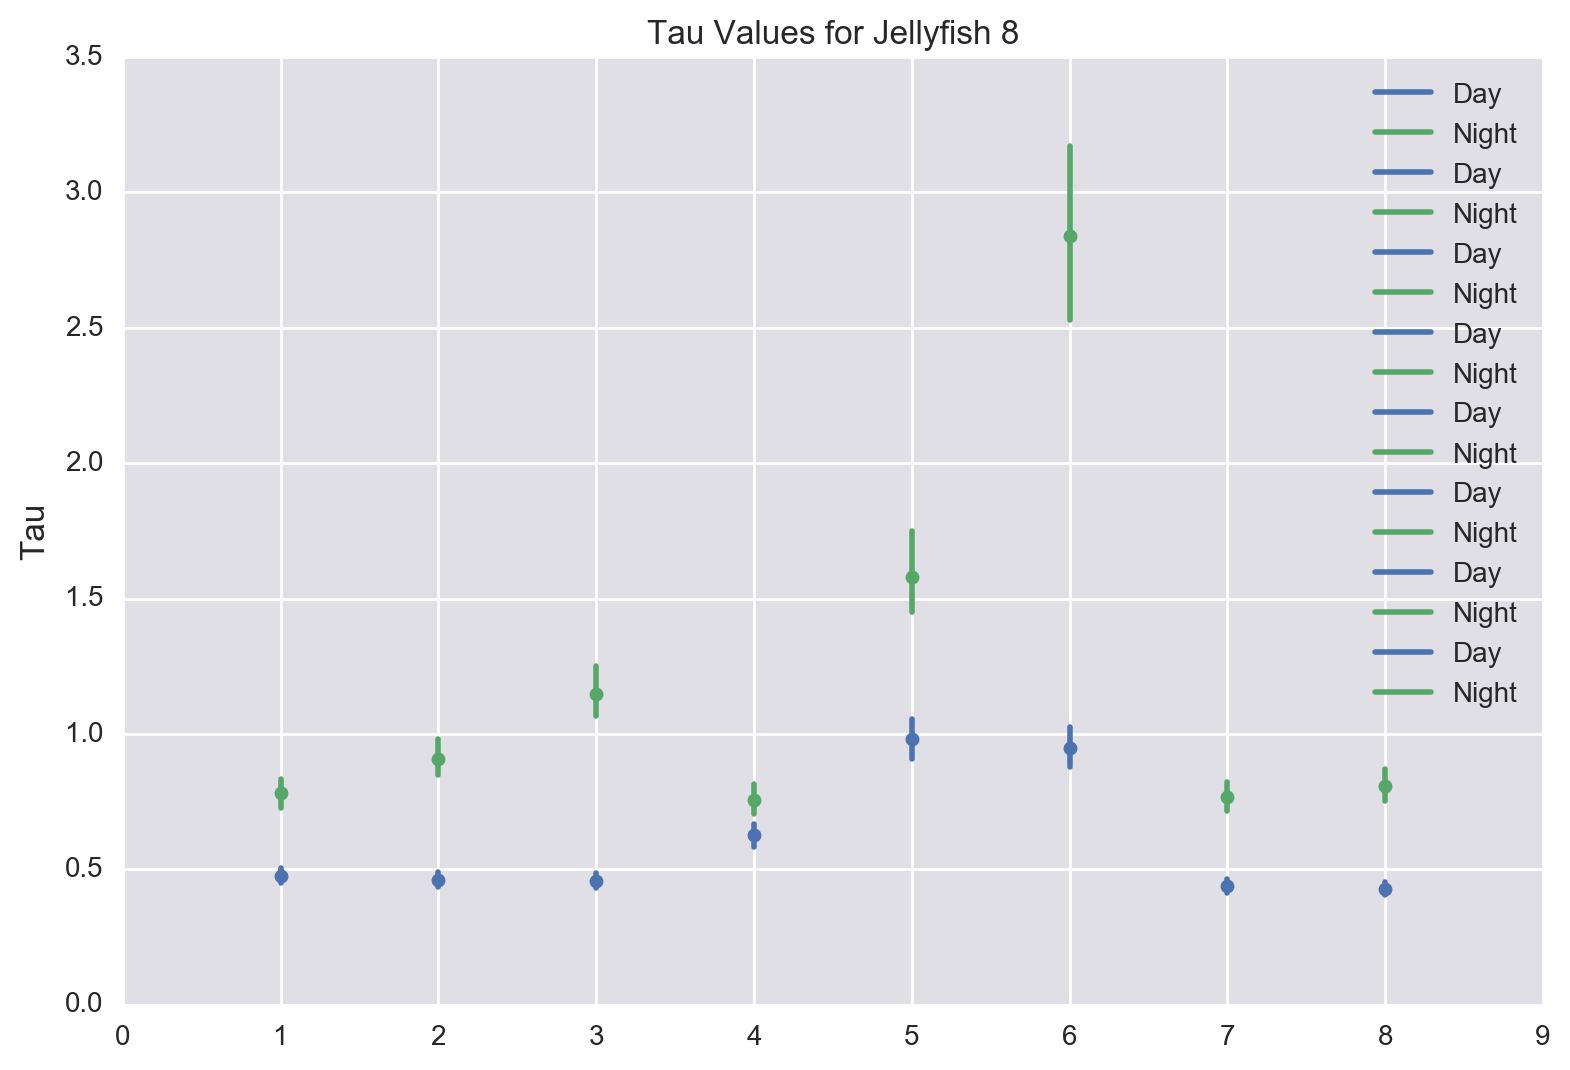

In [48]:
tau = df_tau_night.loc[df_tau_night['Jellyfish'] == 0, 'Tau'].values
x = range(len(df_differences_day[0]))
y = st.expon.pdf(x, scale = tau[0])

#fig, ax = plt.subplots(1,1, figsize=(10, 30))
for i in range(8):
    
    # Find values for day
    tau_day = df_tau_day.loc[df_tau_day['Jellyfish'] == i, 'Tau'].values
    mode_day = df_tau_day.loc[df_tau_day['Jellyfish'] == i, 'Mode'].values
    hpd_day = df_tau_day.loc[df_tau_day['Jellyfish'] == i, 'HPD'].values
    
    # Find values for night
    tau_night = df_tau_night.loc[df_tau_night['Jellyfish'] == i, 'Tau'].values
    mode_night = df_tau_night.loc[df_tau_night['Jellyfish'] == i, 'Mode'].values
    hpd_night = df_tau_night.loc[df_tau_night['Jellyfish'] == i, 'HPD'].values
    
    # Plot the day values
    plt.plot(i+1, mode_day, marker='o', linestyle='none', markersize=5,
               color=sns.color_palette()[0])
    plt.plot([i+1,i+1], hpd_day[0], color=sns.color_palette()[0], label='Day')
    
    # Plot the night values
    plt.plot(i+1, mode_night, marker='o', linestyle='none', markersize=5,
              color=sns.color_palette()[1])
    plt.plot([i+1,i+1], hpd_night[0], color=sns.color_palette()[1], label='Night')
    
    plt.ylabel('Tau', size=12)
    plt.title( 'Tau Values for Jellyfish {}'.format(i+1), size=12)
    plt.xlim((0,9))
    plt.legend()
    
plt.tight_layout()

$\tau$ is the inverse of the average arrival rate of waking up. We see that all 8 jellyfish during the day have a lower $\tau$ than they do during the night, meaning they are more likely to wake up during the day. That makes sense. Moreover, we note that we have a wider HPD for the jellyfish during the night, indicating that we have more variation because of the rest periods. However, since the jellyfish are mostly awake during the day, we have much narrower HPD.

# An alternate metric for sleep

Attribution: Rachel 

We can use another metric to compare the jellyfish. This time we defined the threshold as 0, but then looked at the intensities greater than this threshold to get the individual spikes. We then fitted the spikes with parabolas to find the time at which the intensity peaked. Then, we calculated the interspike times for each jellyfish during the day and night. This is a little more precise than our previous method because in our previous method where we defined our threshold could affect the span of points that we collected. However, in this method where we find the spikes and then the interspike time, the interspike time does not depend on the threshold, but on the shape of the peak. 

In [49]:
def local_max(x, y):
    """
    Locally approximate minimum as quadratic
    and return location of minimum.
    """
    # Find minimum by fitting polynomial
    maxind = np.argmax(y)
    V_vals = y[maxind-1:maxind+2]
    t_vals = x[maxind-1:maxind+2]
    a, b, c = np.polyfit(t_vals, V_vals, 2)
    t_max = -b / 2 / a
    return t_max, a, b, c

In [51]:
intensities = [from_data_normalized_day_intensities, from_data_normalized_night_intensities]
dfs_spike_day = []
dfs_spike_night = []
dfs_spike_all = [dfs_spike_day, dfs_spike_night]
spike_day = []
spike_night = []
spike_all = [spike_day, spike_night]
interspike_day = []
interspike_night = []
interspike_all = [interspike_day, interspike_night]
day = ['day', 'night']

# Amount of time in seconds to keep on either side of spike
time_window_left = 0
time_window_right = 0

# Number of samples to keep on either side of spike
n_window_left = int(time_window_left / fps)
n_window_right = int(time_window_right /fps)

for time in range(2):
    V = intensities[time]
    for jelly in range(8):
        # Threshold below which spike has to drop (in µV)
        thresh = 0
        
        # DataFrame to store spikes
        df_spike = pd.DataFrame(columns=['spike', 't (s)', 'intensity'])
        # Initialize while loop
        i = 1
        spike = 0
        while i < len(V[0]):
            if V[jelly][i] > thresh:
                # Found a spike, get crossings
                cross_1 = i
                while V[jelly][i] > thresh:
                    if i == 3999:
                        break
                    i += 1
                cross_2 = i
                # store it as a spike only if it is a whole spike
                if V[jelly][cross_1] < V[jelly][cross_1 + 1] and  V[jelly][cross_2 - 1] > V[jelly][cross_2]:
                    if (cross_1-n_window_left) > 0 and (cross_2+n_window_right) <4000:
                        # Store perintent quantities in DataFrame
                        t_in = t[cross_1-n_window_left:cross_2+n_window_right]
                        V_in = V[jelly][cross_1-n_window_left:cross_2+n_window_right]
                    else:
                        # Store perintent quantities in DataFrame
                        t_in = t[cross_1:cross_2]
                        V_in = V[jelly][cross_1:cross_2]
                    data={'t (s)': t_in,
                          'intensity': V_in,
                          'spike': spike * np.ones_like(t_in, dtype=int)}
                    df_add = pd.DataFrame(data)
                    df_spike = pd.concat((df_spike, df_add))

                    spike += 1

            i += 1
        dfs_spike_all[time].append(df_spike)
        
        # Array to hold spike positions
        spikes = np.empty(len(df_spike['spike'].unique()))

        # Compute spike positions
        for i, sp in enumerate(df_spike['spike'].unique()):
            inds = df_spike['spike'] == sp
            t_max, a, b, c = local_max(df_spike[inds]['t (s)'].values, 
                                  df_spike[inds]['intensity'].values)
            spikes[i] = t_max
        spike_all[time].append(spikes)
        # Compute interspike times
        interspike_times = np.diff(spikes)
        interspike_times = [elem for elem in interspike_times if elem > 0]
        interspike_all[time].append(interspike_times)
        name = "{} jellyfish {}".format(day[time], jelly+1)
        print(name)

day jellyfish 1
day jellyfish 2
day jellyfish 3
day jellyfish 4
day jellyfish 5
day jellyfish 6
day jellyfish 7
day jellyfish 8
night jellyfish 1
night jellyfish 2
night jellyfish 3
night jellyfish 4
night jellyfish 5
night jellyfish 6


C:\Users\Anvita Mishra\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


night jellyfish 7
night jellyfish 8


We can compare histograms(PDF) of interspike times of day vs night for each jelly fish.

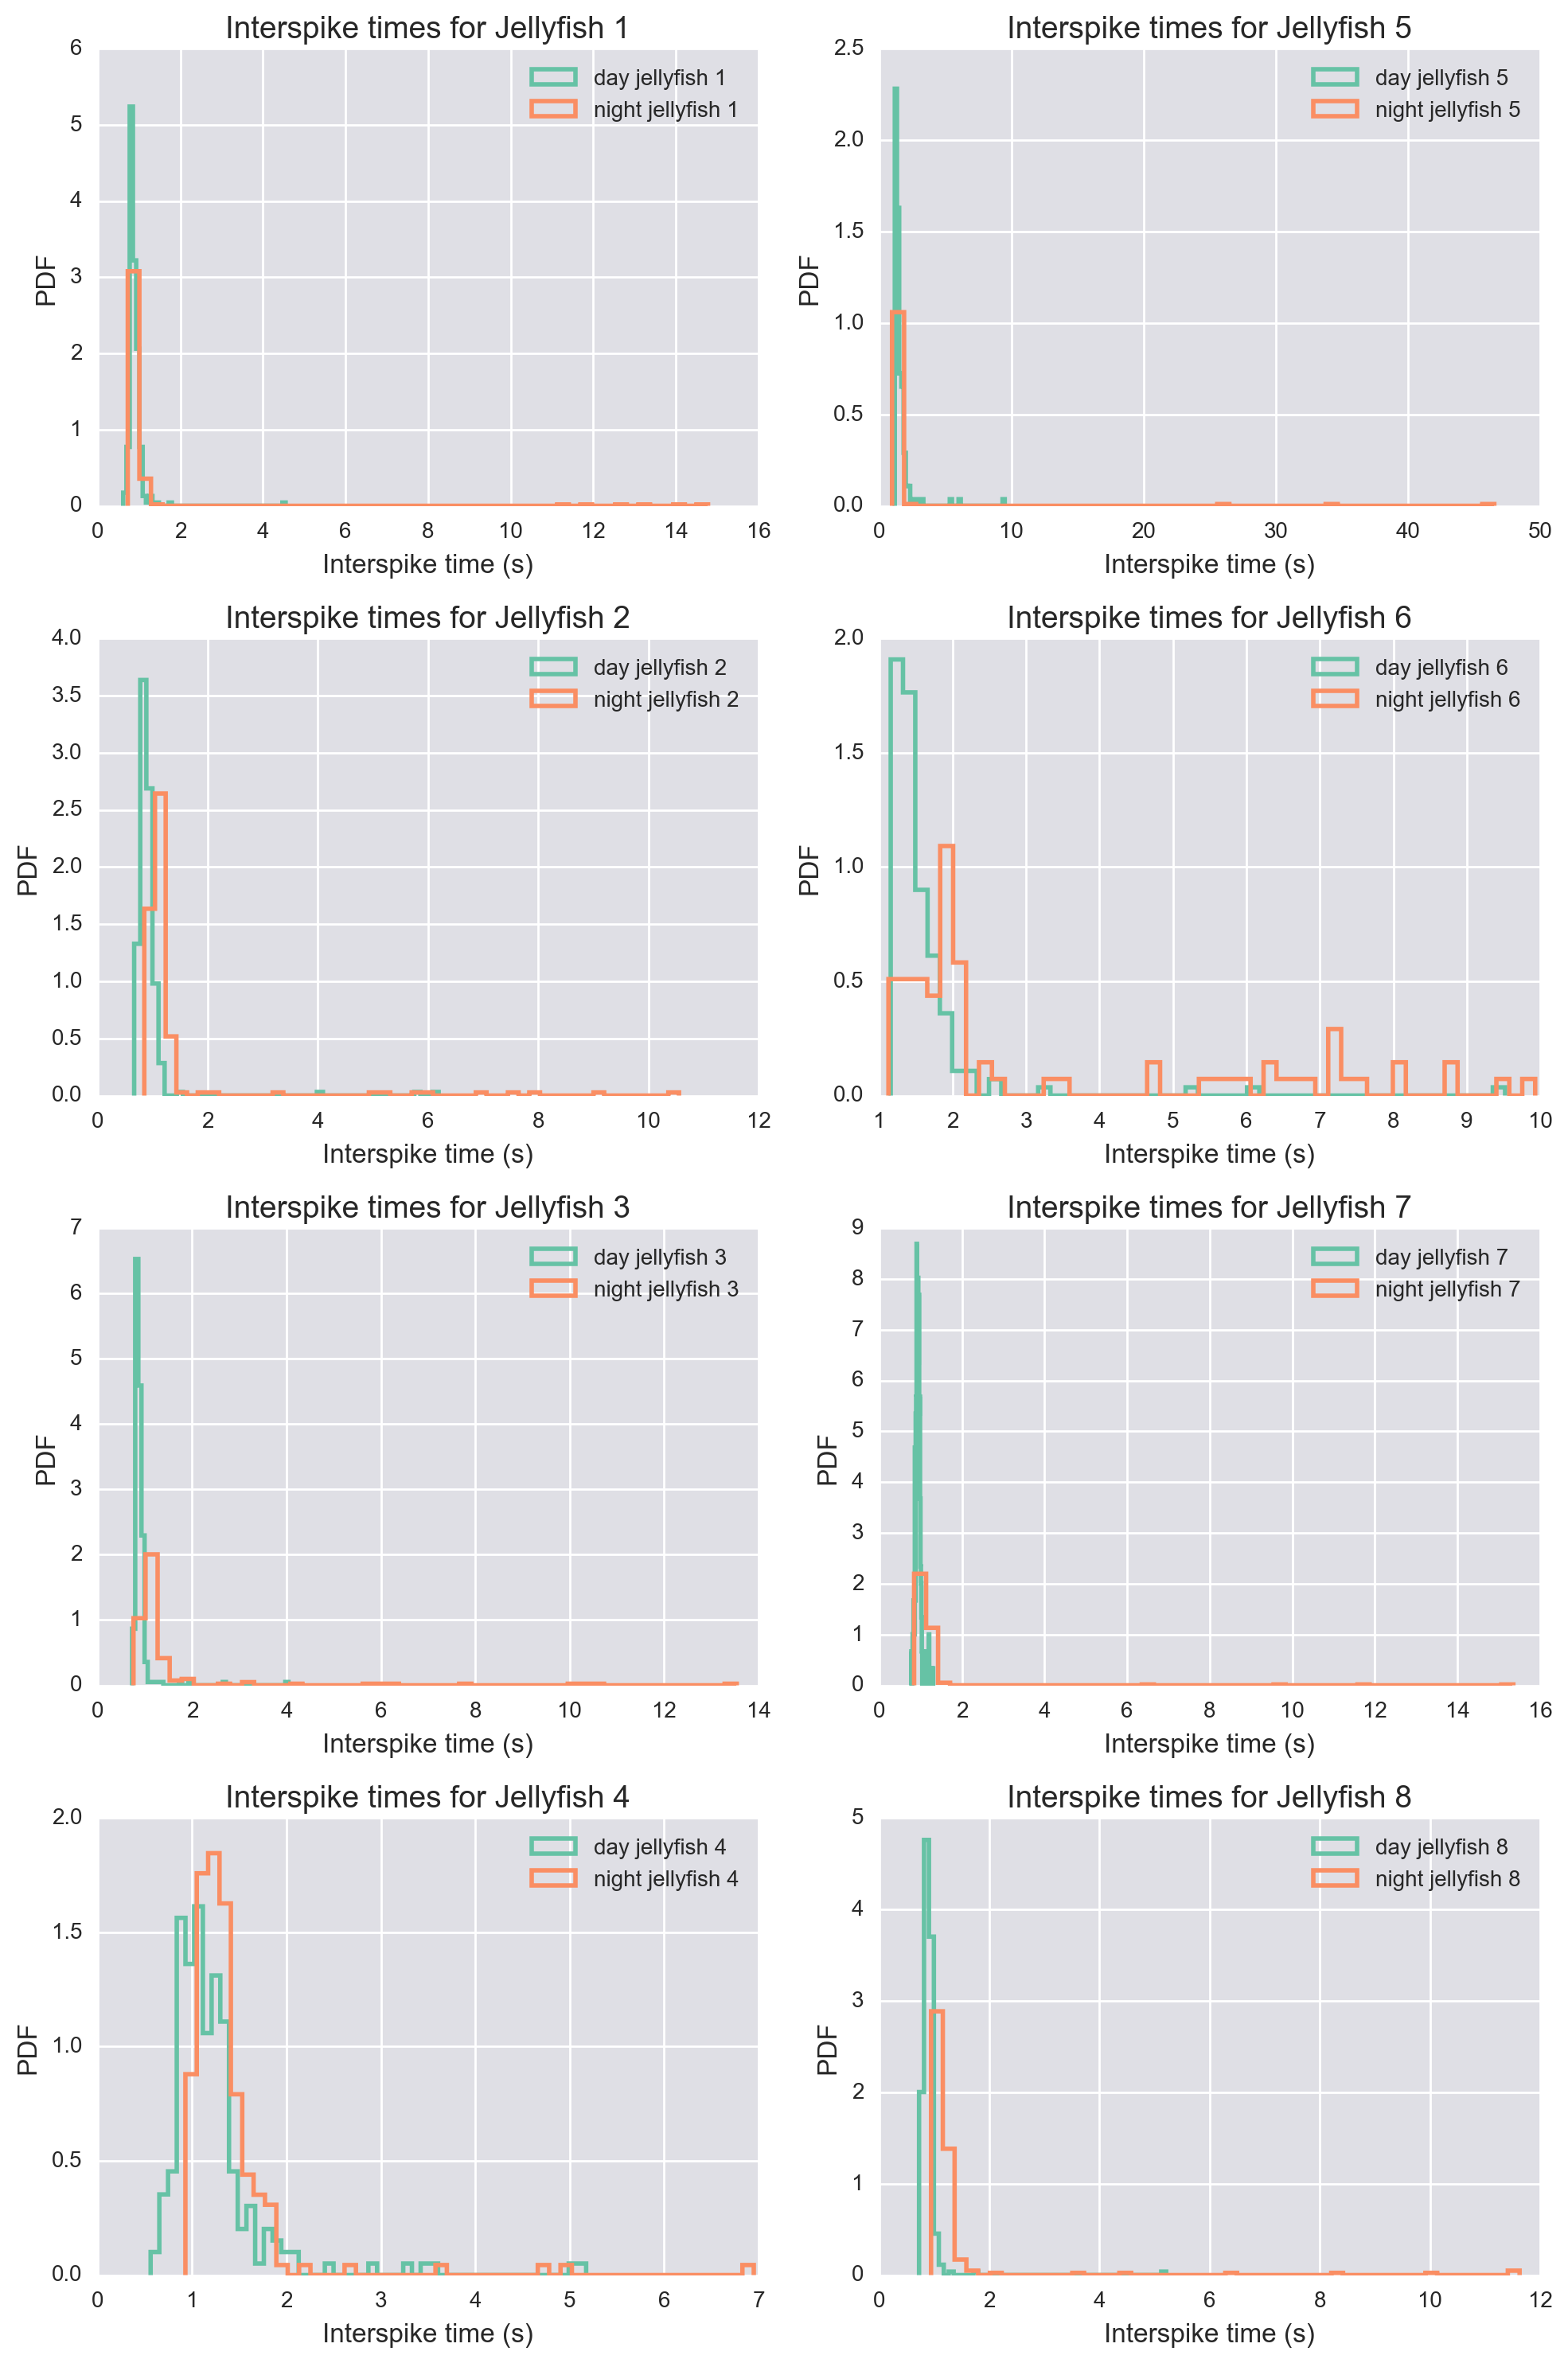

In [66]:
sns.set_palette(sns.color_palette('Set2',8))
fig, ax = plt.subplots(4,2, figsize=(10,15))
for time in range(2):
    for jelly in range(8):
        name = "{} jellyfish {}".format(day[time], jelly+1)
        ax[(jelly%4, jelly//4)].hist(interspike_all[time][jelly], bins=50, histtype='step', 
                                     label=name, linewidth=2, normed=True)
        ax[(jelly%4, jelly//4)].legend()
        ax[(jelly%4, jelly//4)].set_xlabel('Interspike time (s)', size=12)
        ax[(jelly%4, jelly//4)].set_ylabel('PDF', size=12)
        ax[(jelly%4, jelly//4)].set_title('Interspike times for Jellyfish {}'.format(jelly+1), size=14)
    plt.tight_layout()

We can compare ECDF of interspike times of day vs night for each jelly fish.

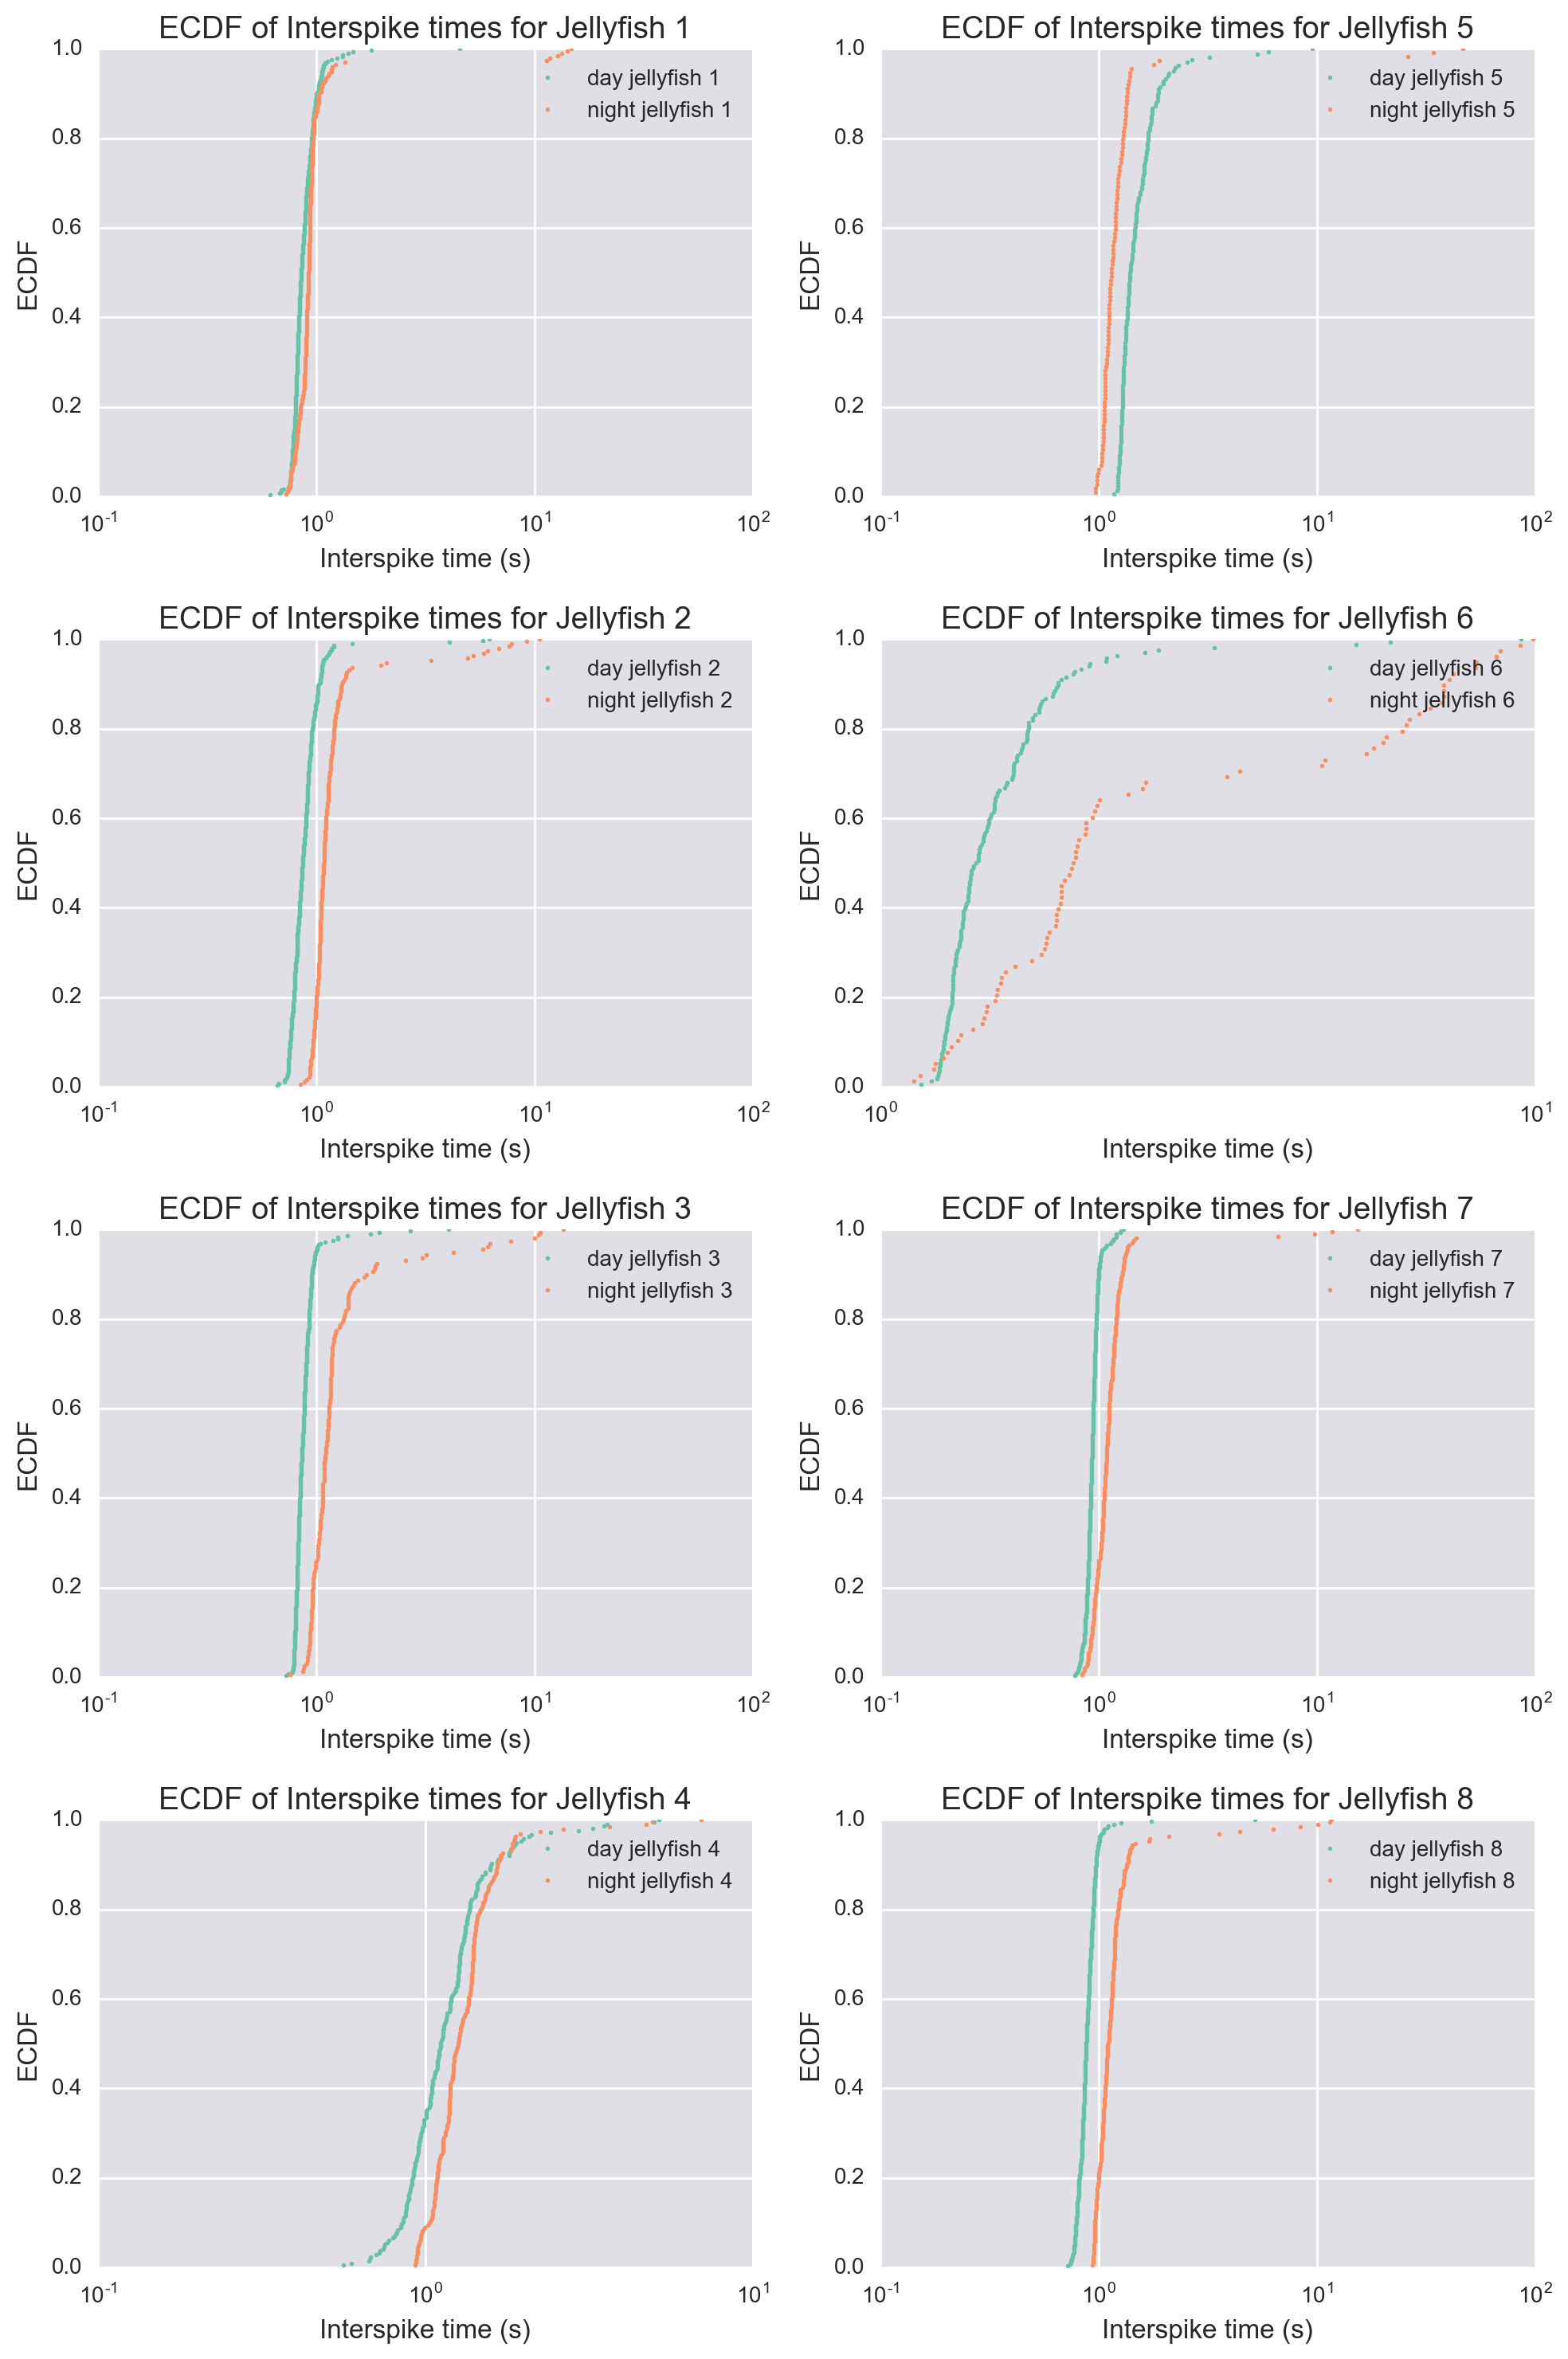

In [67]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for time in range(2):
    for jelly in range(8):
        # Make ECDF
        name = "{} jellyfish {}".format(day[time], jelly+1)
        data = interspike_all[time][jelly]
        x, y = bebi103.ecdf(data)
        ax[(jelly%4, jelly//4)].semilogx(x, y, '.', markersize=4, label=name)
        ax[(jelly%4, jelly//4)].legend()
        ax[(jelly%4, jelly//4)].set_xlabel('Interspike time (s)', size=12)
        ax[(jelly%4, jelly//4)].set_ylabel('ECDF', size=12)
        ax[(jelly%4, jelly//4)].set_title('ECDF of Interspike times for Jellyfish {}'.format(jelly+1), size=14)
    plt.tight_layout()

This is interesting. It gives us a picture of the jellyfish sleep patterns. For example, if you look at the ECDF for Jellyfish 6 at Night, the ECDF looks bimodal, which indicates that it frequently wakes up and falls back asleep (it's a fitful sleep :(). In general, the jellyfish during the day have shorter interspike times, which means they're awake. 

<div class="alert alert-info"> <left>
MR comment:
<p>
I like this approach!
</p>
It is very interesting that the jellyfish number 5 has the reverse behavior. Maybe that one likes to party all night long.
</left></div>

We will now compare the PDF distributions across all 8 jellyfish by plotting them together.

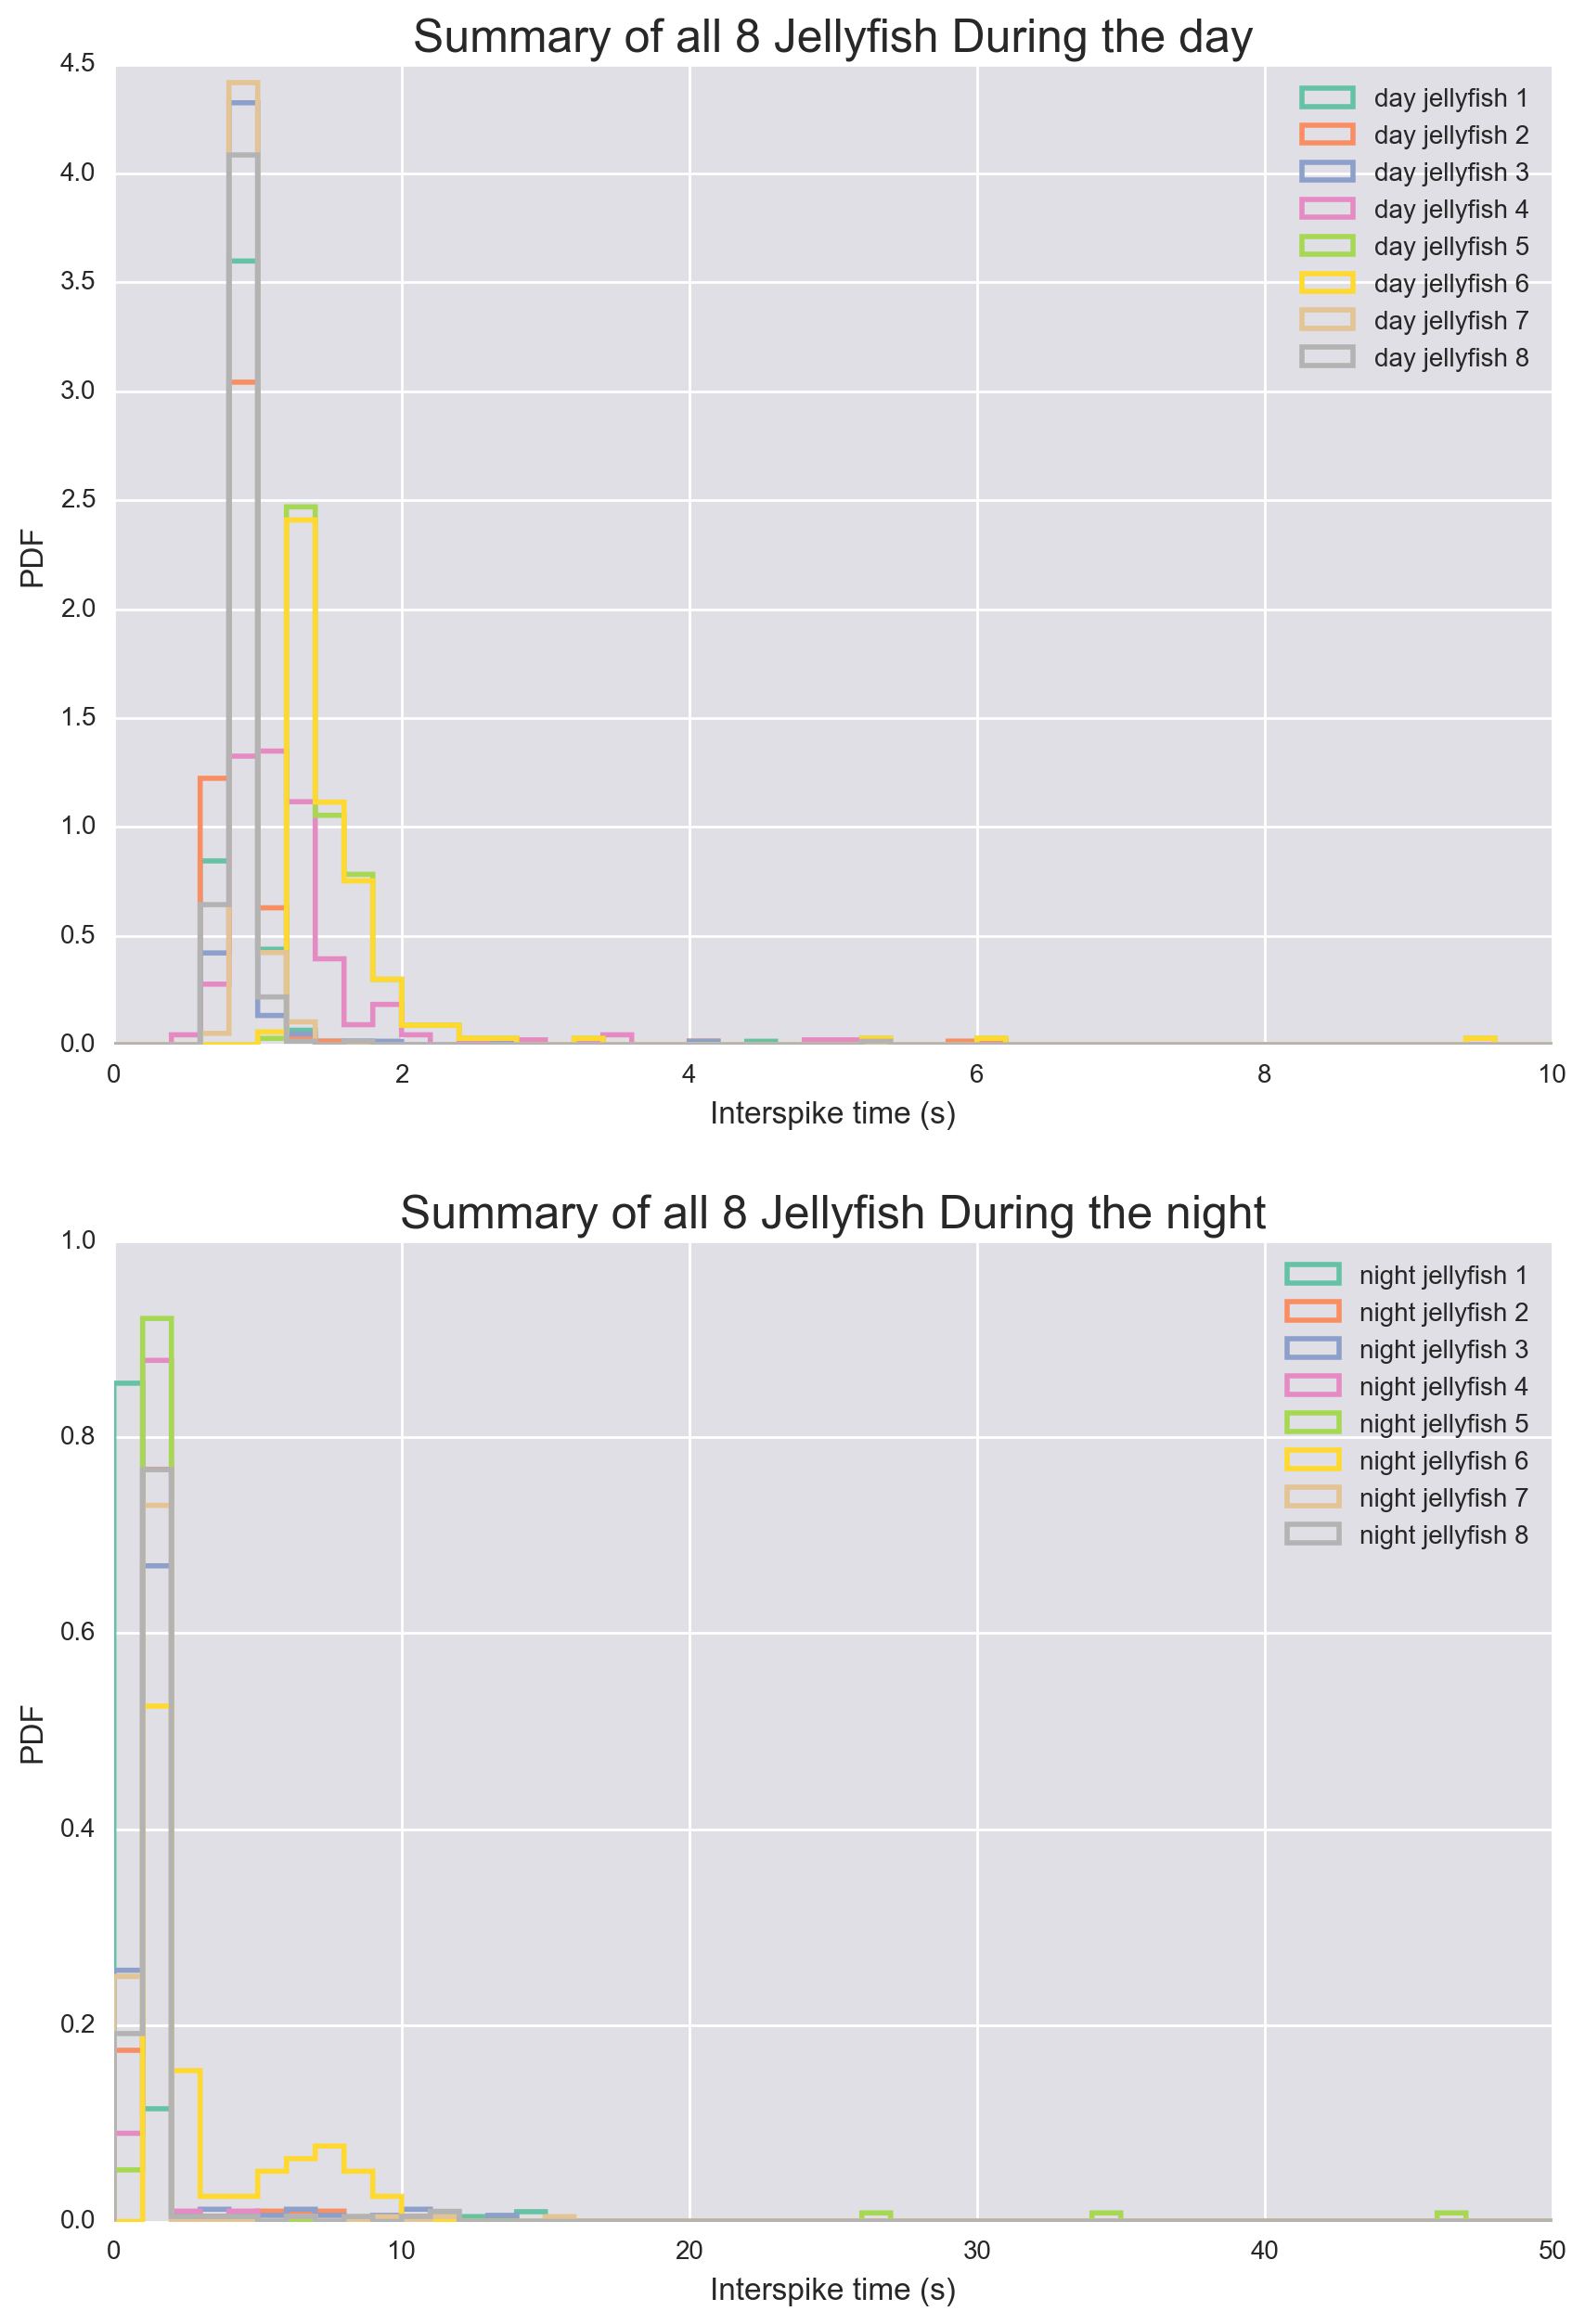

In [71]:
fig, ax = plt.subplots(2,1, figsize=(10,15))
ranges=[(0,10),(0,50)]
for time in range(2):
    for jelly in range(8):
        name = "{} jellyfish {}".format(day[time], jelly+1)
        ax[time].hist(interspike_all[time][jelly], bins=50, histtype='step', 
                      label=name, linewidth=2, normed=True, range=ranges[time])
    ax[time].legend()
    ax[time].set_xlabel('Interspike time (s)', size=12)
    ax[time].set_ylabel('PDF', size=12)
    ax[time].set_title('Summary of all 8 Jellyfish During the {}'.format(day[time]))

<div class="alert alert-info"> <left>
MR comment:
<p>
I know that you guys also have the ECDF plots below. but if this plot doesn't convey any useful information you don't necessarily need to include it.
</p>
</left></div>

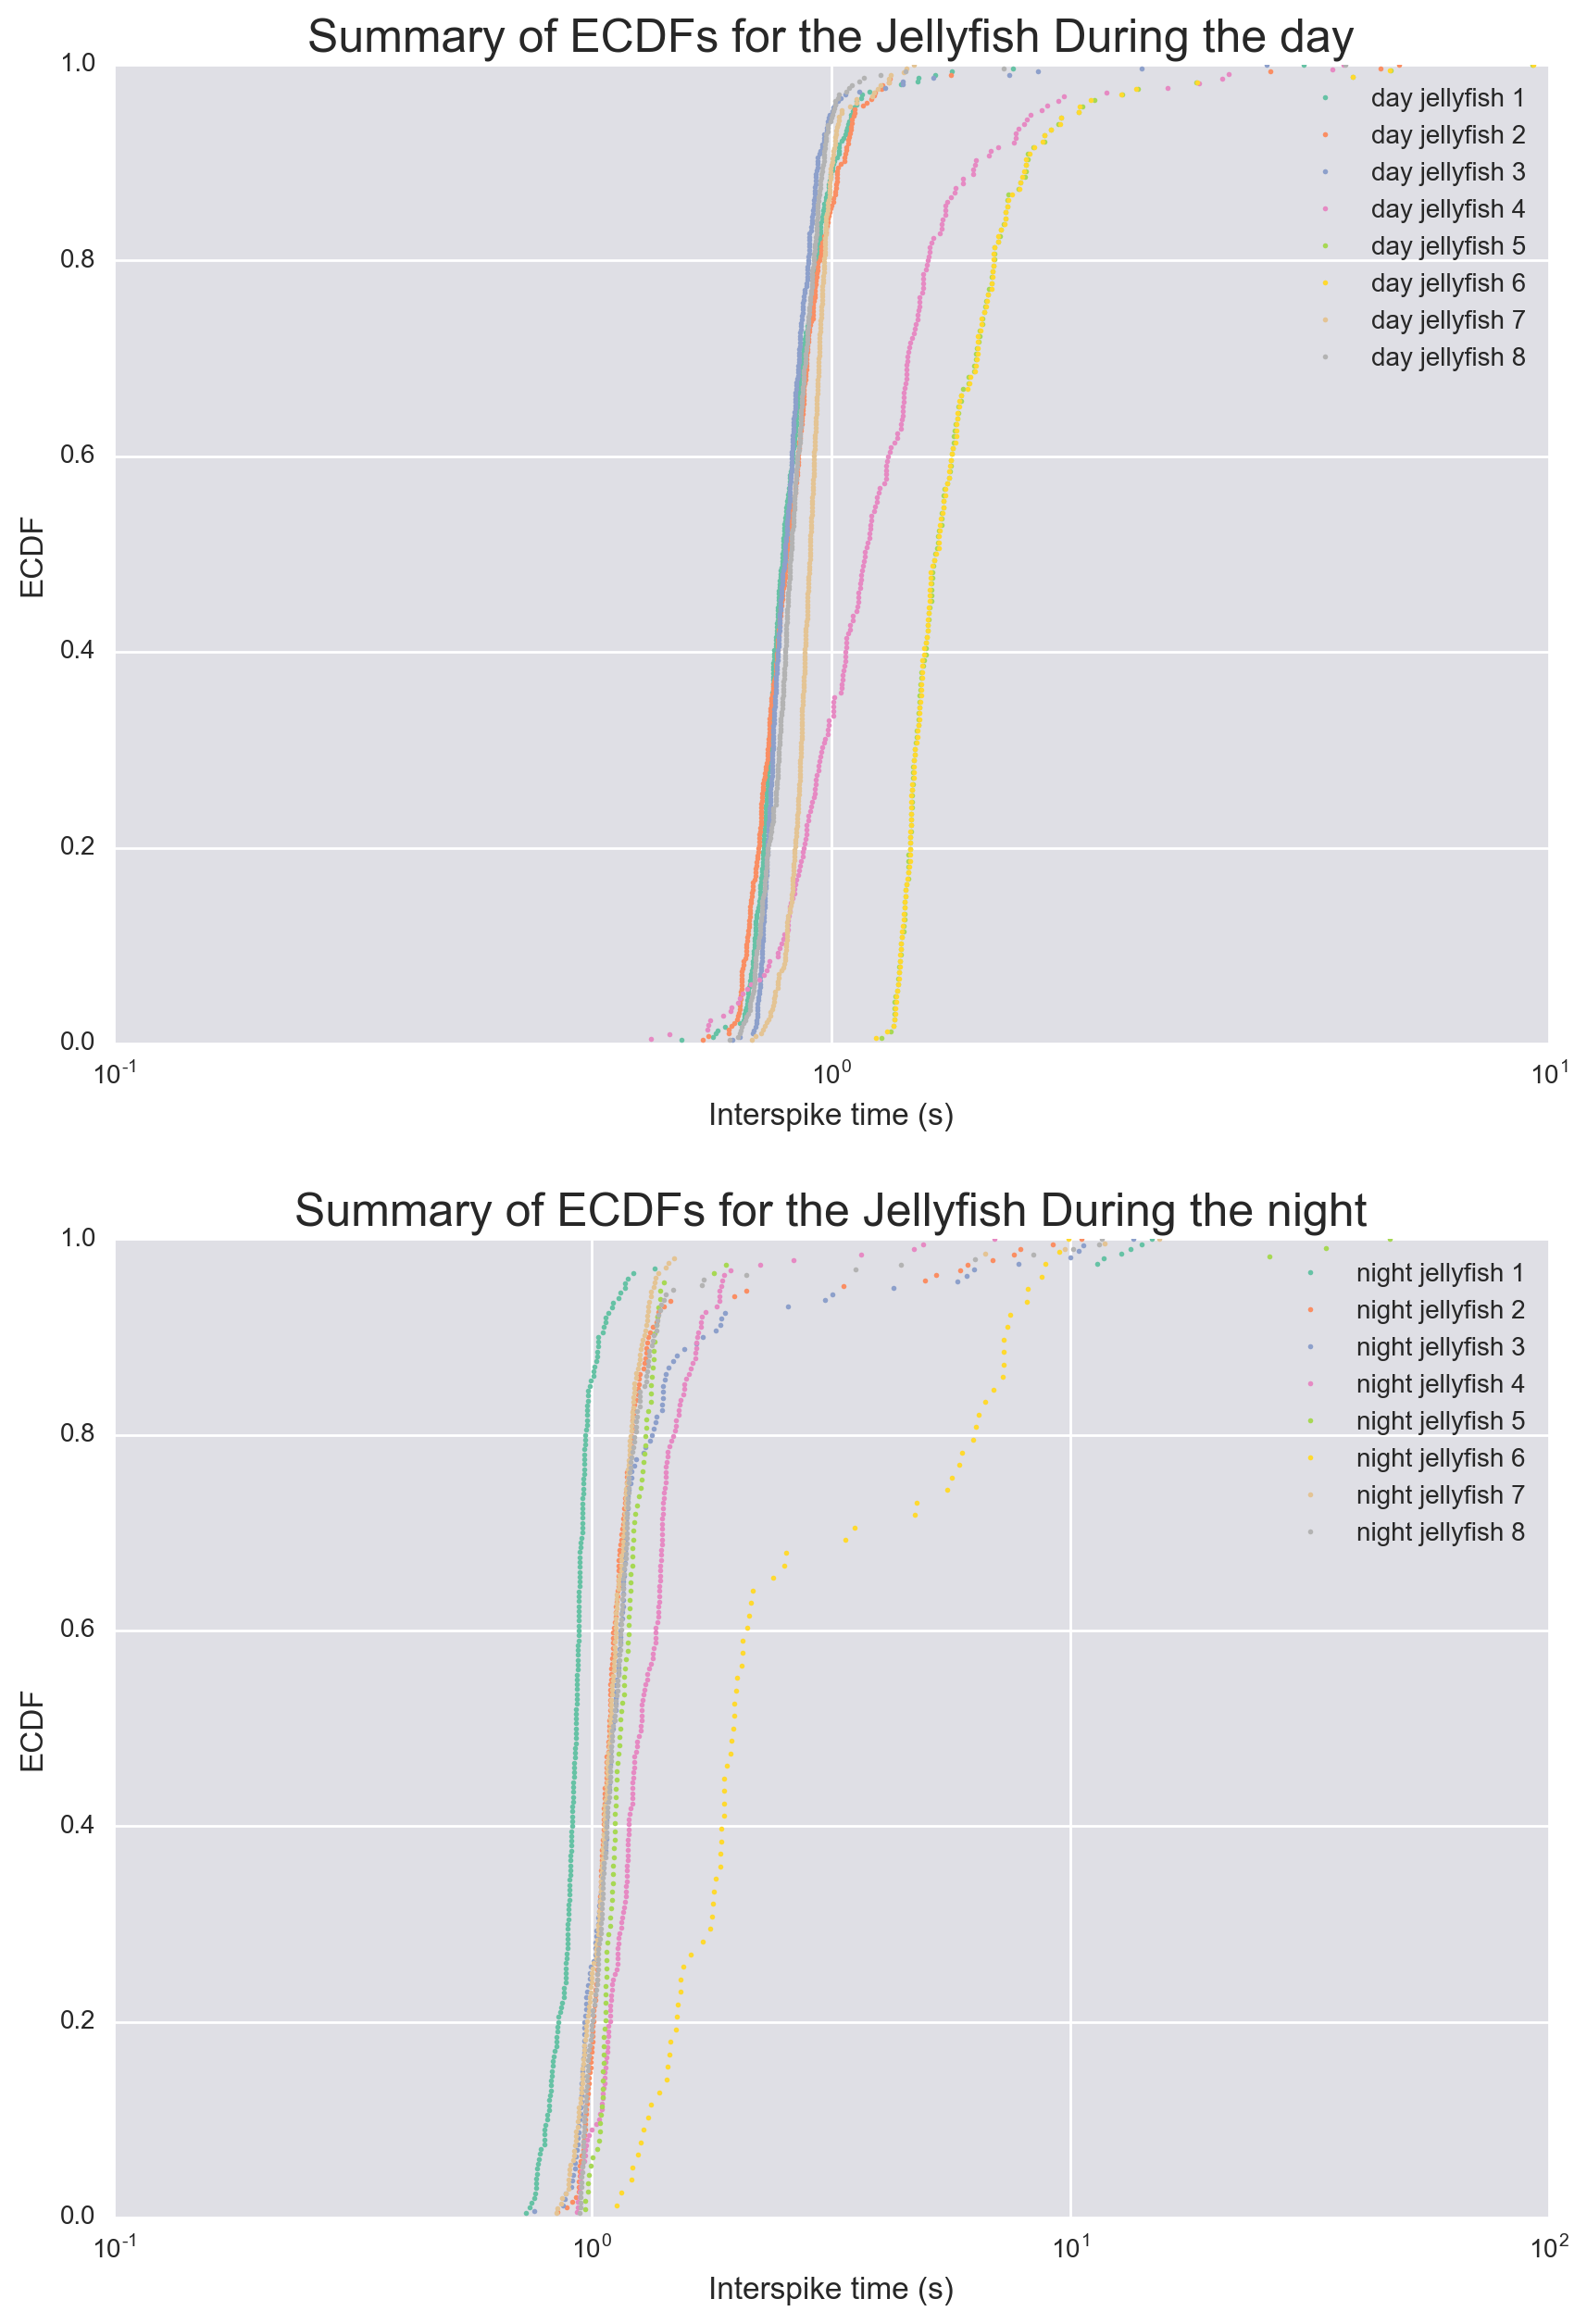

In [72]:
fig, ax = plt.subplots(2,1, figsize=(10,15))
for time in range(2):
    for jelly in range(8):
        # Make ECDF
        name = "{} jellyfish {}".format(day[time], jelly+1)
        data = interspike_all[time][jelly]
        x, y = bebi103.ecdf(data)
        ax[time].semilogx(x, y, '.', markersize=4, label=name)
        ax[time].set_xlabel('Interspike time (s)', size=12)
        ax[time].set_ylabel('ECDF', size=12)
        ax[time].set_title('Summary of ECDFs for the Jellyfish During the {}'.format(day[time]))
        ax[time].legend()

We can tidy everything into a dataframe *df_interspike* and produce a boxplot of the interspike times.

In [73]:
df_interspike = pd.DataFrame(columns=['day','jelly','interspike'])
for time in range(2):
    for jelly in range(8):
        # DataFrame to store spikes
        times = interspike_all[time][jelly]
        data={'day': [day[time]]*len(times),
              'jelly': [jelly]*len(times),
              'interspike': times}
        df_add = pd.DataFrame(data)
        df_interspike = pd.concat((df_interspike, df_add))

In [74]:
df_interspike.head()

day  interspike  jelly
0  day    0.851108    0.0
1  day    0.810173    0.0
2  day    0.819803    0.0
3  day    0.779376    0.0
4  day    0.832560    0.0

We can produce a boxplot of all of the interspike as shown below. However, since most of the interspike times are very small, we couldn't see where the longer interspike times were, which is what we're interested in. 

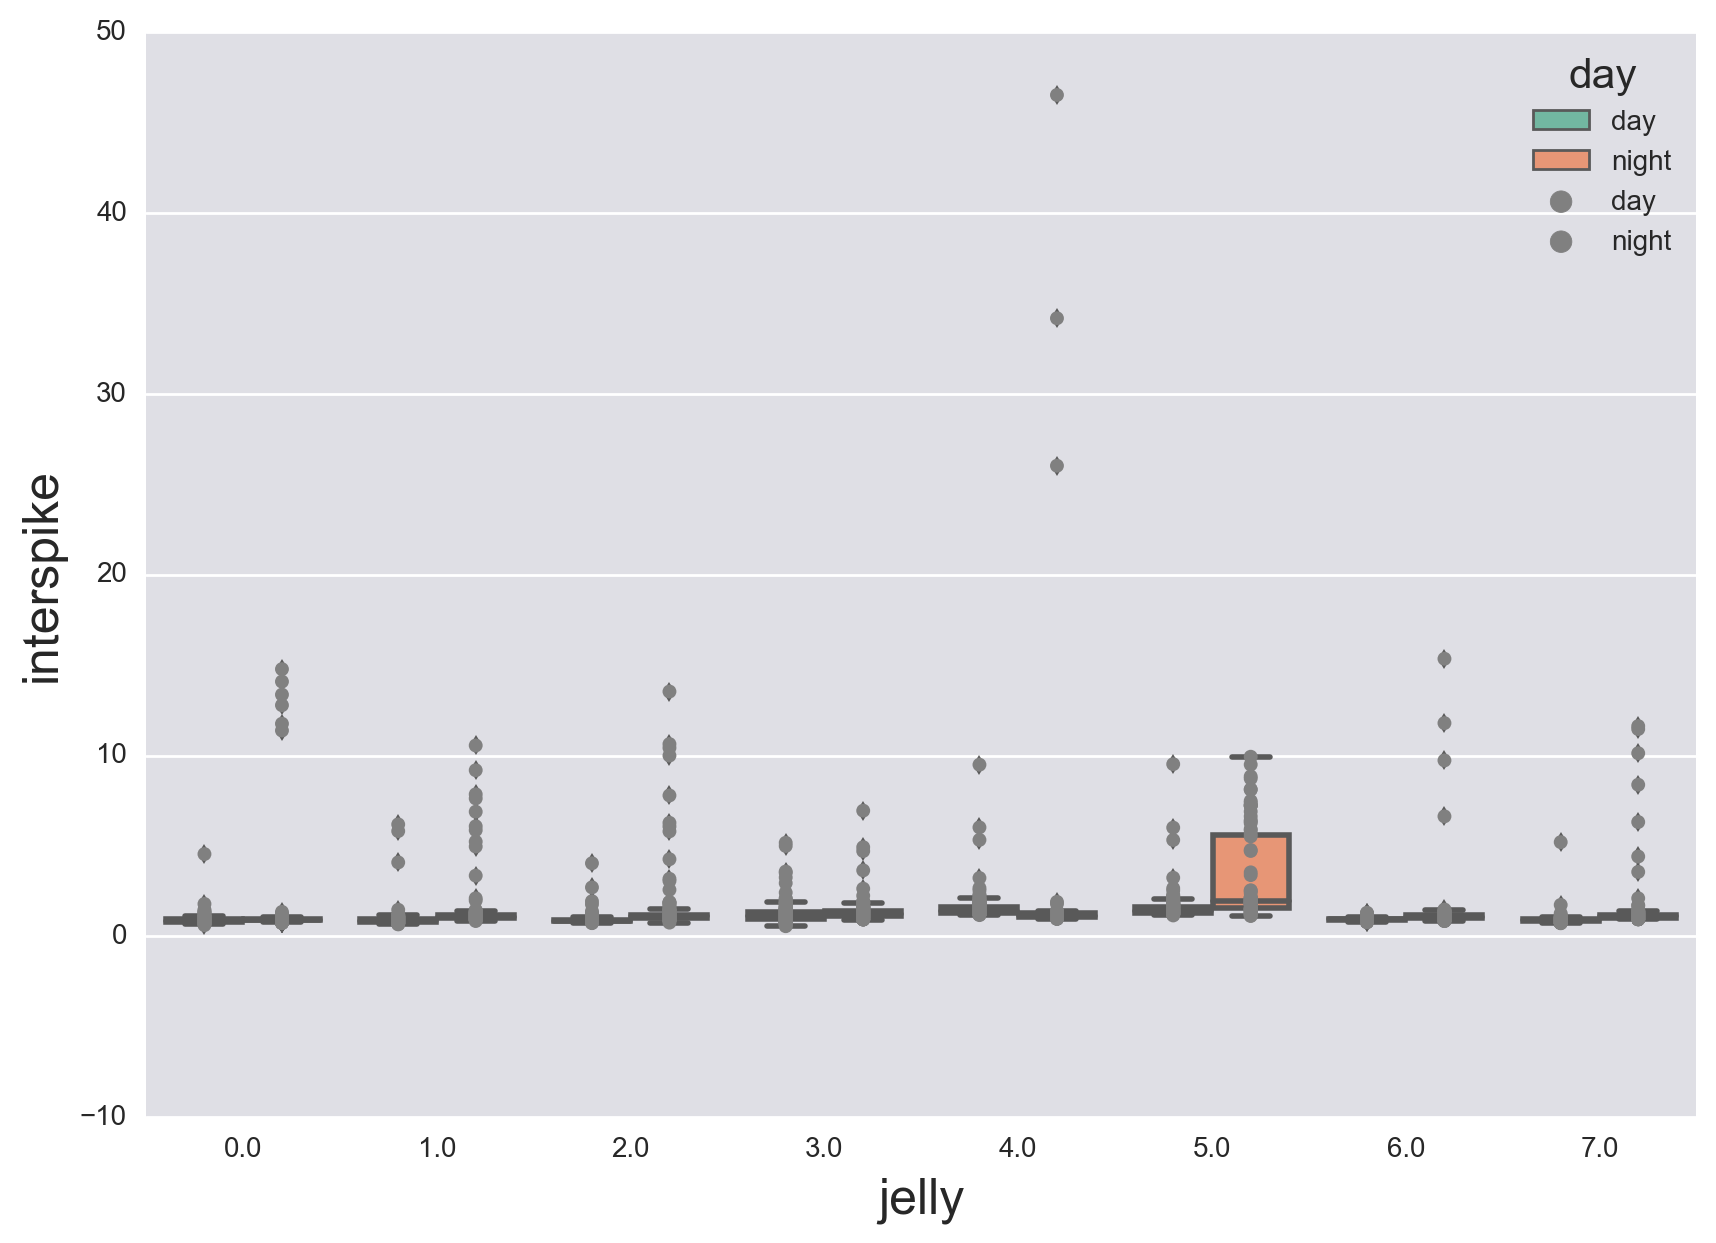

In [77]:
fig,ax=plt.subplots(figsize=(10,7))
inds = df_interspike['interspike']>0
sns.boxplot(x='jelly', y='interspike', data=df_interspike[inds], hue='day', ax=ax)
ax=sns.stripplot('jelly', 'interspike', 'day', data=df_interspike[inds], split=True, ax=ax, palette=['gray']*2)


Here we  displayed the interspike times that were greater than 2 seconds to exclude the periods where the jellyfish was just active. 

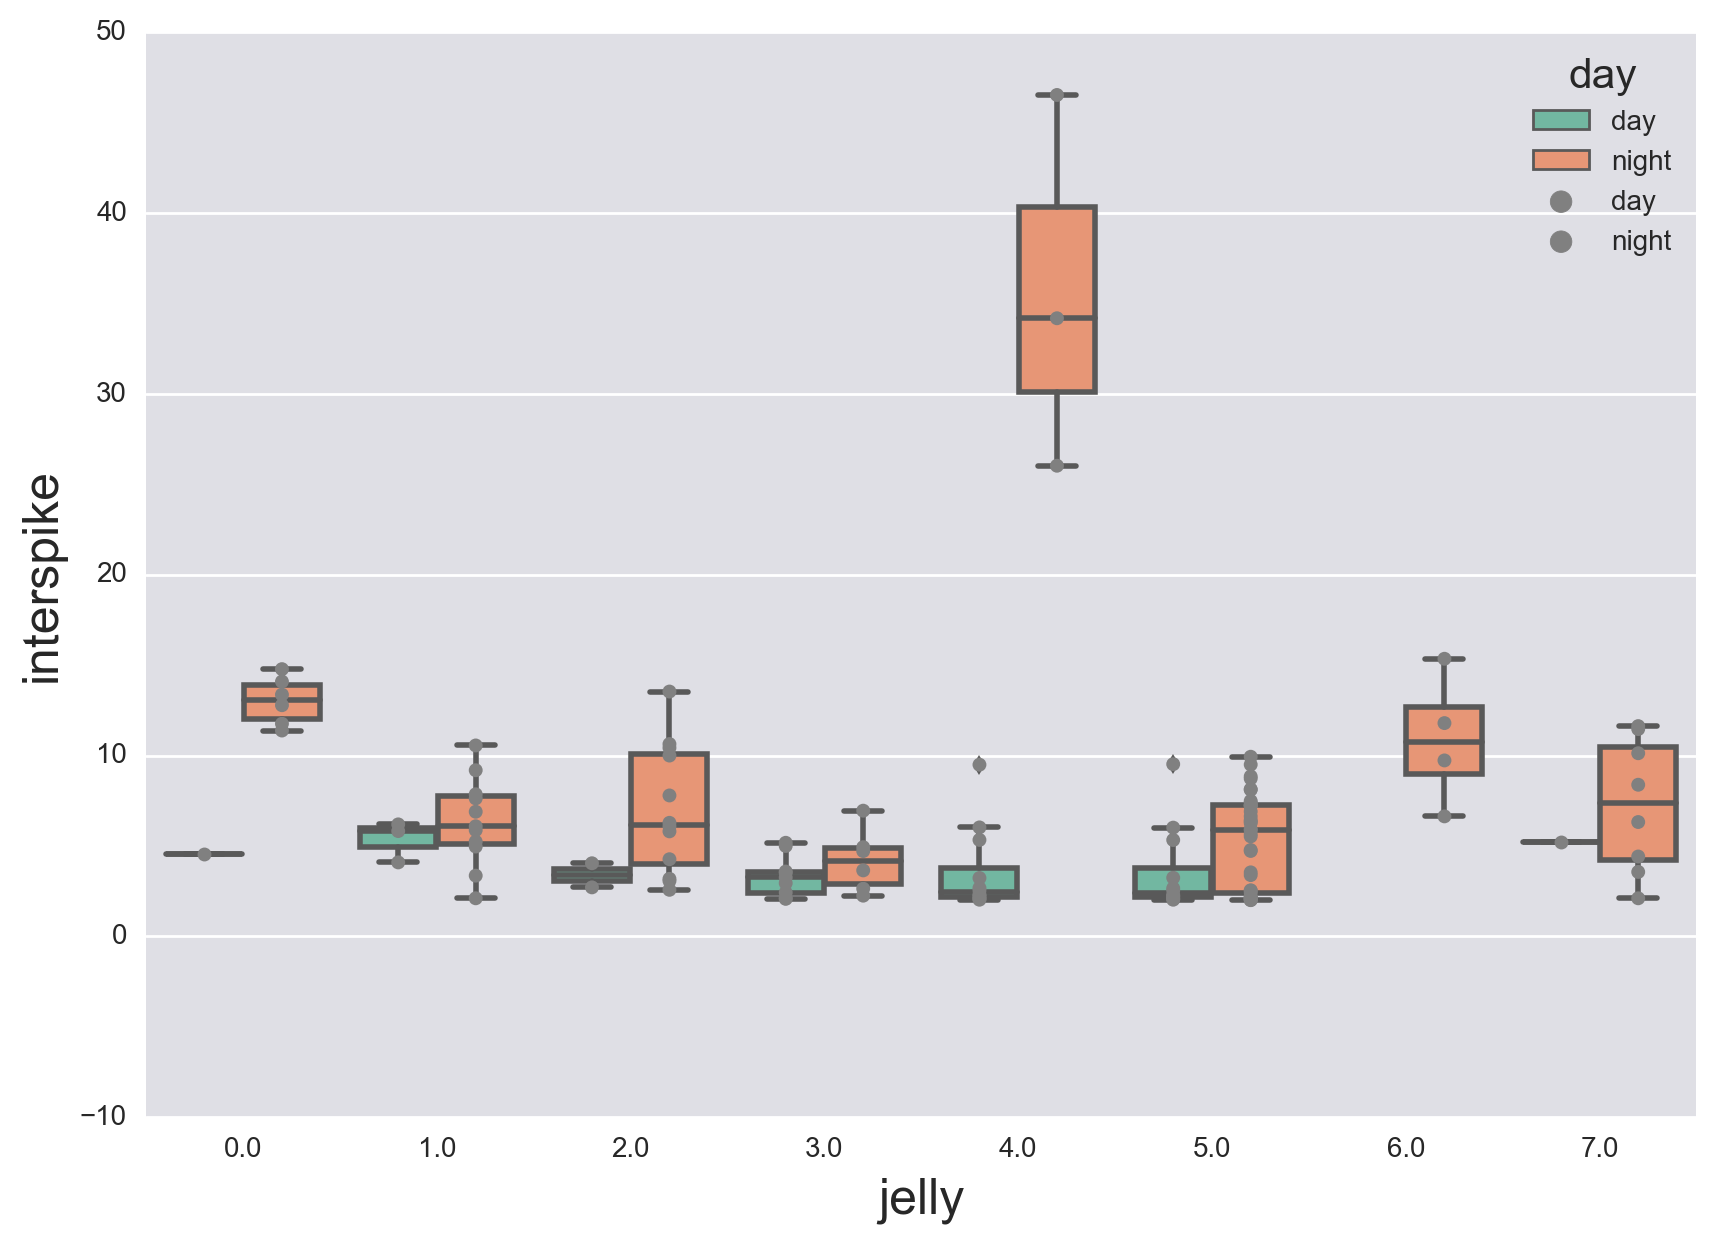

In [20]:
fig,ax=plt.subplots(figsize=(10,7))
inds = df_interspike['interspike']>2
sns.boxplot(x='jelly', y='interspike', data=df_interspike[inds], hue='day', ax=ax)
ax=sns.stripplot('jelly', 'interspike', 'day', data=df_interspike[inds], split=True, ax=ax, palette=['gray']*2)


We will now try to fit the data to a exponential distribution.

In [21]:
tau_min = 0.00001
tau_max = 10000

In [78]:
# Perform MCMC sampling for each model (Day)
df_tau_day = pd.DataFrame(columns=['HPD', 'Mode', 'Tau', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_tau, hpd_tau = sample_mcmc(interspike_all[0][j])
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']]
    data = {'HPD': [hpd_tau],
           'Mode': [mode_tau],
           'Tau': [est_tau],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_day = pd.concat((df_tau_day, df_add))

In [79]:
df_tau_day

HPD  Jellyfish      Mode  \
0  [0.846853227928, 0.951065274147]        0.0  0.899207   
0  [0.876890470222, 0.986554241099]        1.0  0.931319   
0  [0.848895598083, 0.953176167903]        2.0  0.900903   
0    [1.15224934031, 1.32079939256]        3.0  1.233885   
0    [1.47950243048, 1.72744091682]        4.0  1.588029   
0    [1.47565384627, 1.72381333308]        5.0  1.586857   
0  [0.886237640581, 0.997719023451]        6.0  0.938546   
0  [0.851071420379, 0.956429022105]        7.0  0.902867   

                                             Tau  
0   tau    0.896787
Name: 523848, dtype: float64  
0  tau    0.929827
Name: 1031828, dtype: float64  
0   tau    0.897999
Name: 639788, dtype: float64  
0   tau    1.232796
Name: 754651, dtype: float64  
0   tau    1.595394
Name: 646387, dtype: float64  
0   tau    1.595408
Name: 342073, dtype: float64  
0   tau    0.939727
Name: 138146, dtype: float64  
0   tau    0.901995
Name: 692850, dtype: float64

In [80]:
# Perform MCMC sampling for each model (night)
df_tau_night = pd.DataFrame(columns=['HPD', 'Mode', 'Tau', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_tau, hpd_tau = sample_mcmc(interspike_all[1][j])
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']]
    data = {'HPD': [hpd_tau],
           'Mode': [mode_tau],
           'Tau': [est_tau],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_night = pd.concat((df_tau_night, df_add))

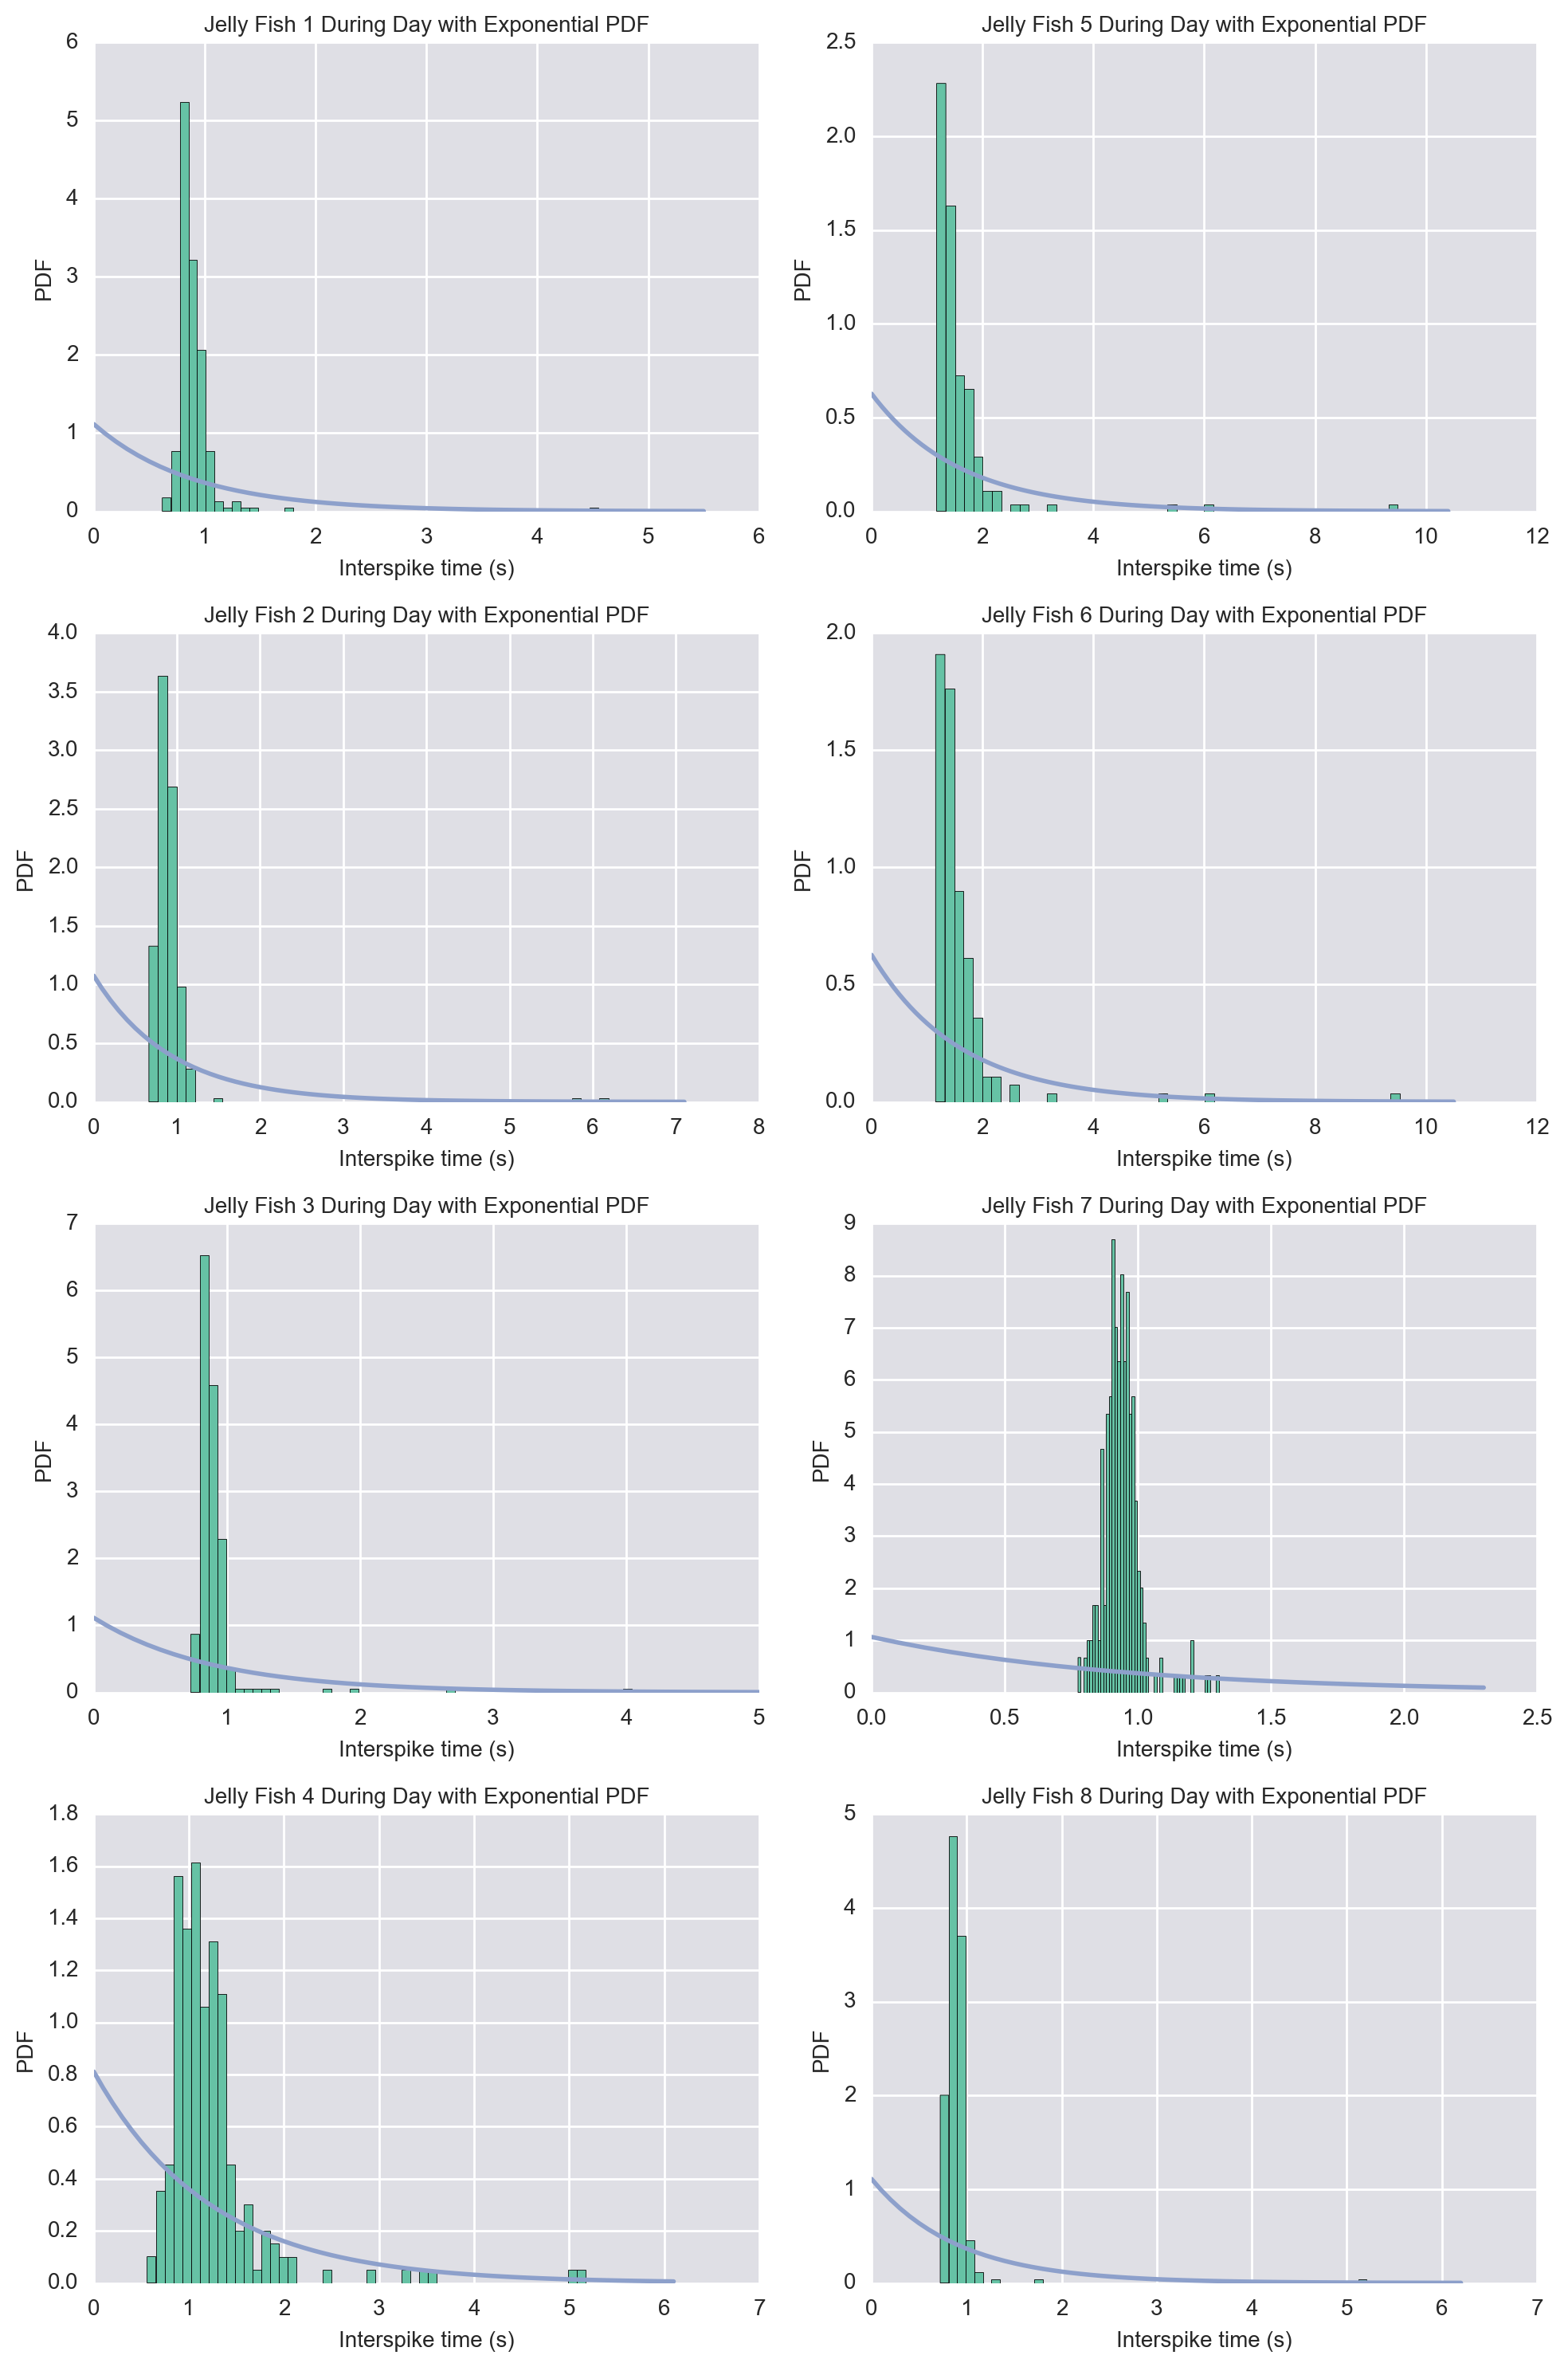

In [121]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_day.Jellyfish.unique()):
    data = np.array(interspike_all[0][i])
    inds = df_tau_day['Jellyfish']==jelly
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau_array = df_tau_day.loc[inds, 'Tau'].values
    tau = tau_array[0].values
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].hist(data, bins=50, normed=True)
    ax[(i%4,i//4)].plot(n_plot,  np.exp(exp_logpmf(n_plot,tau)), '-', 
                        color=sns.color_palette()[2])
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Day with Exponential PDF'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('PDF', size=10)
    
plt.tight_layout()

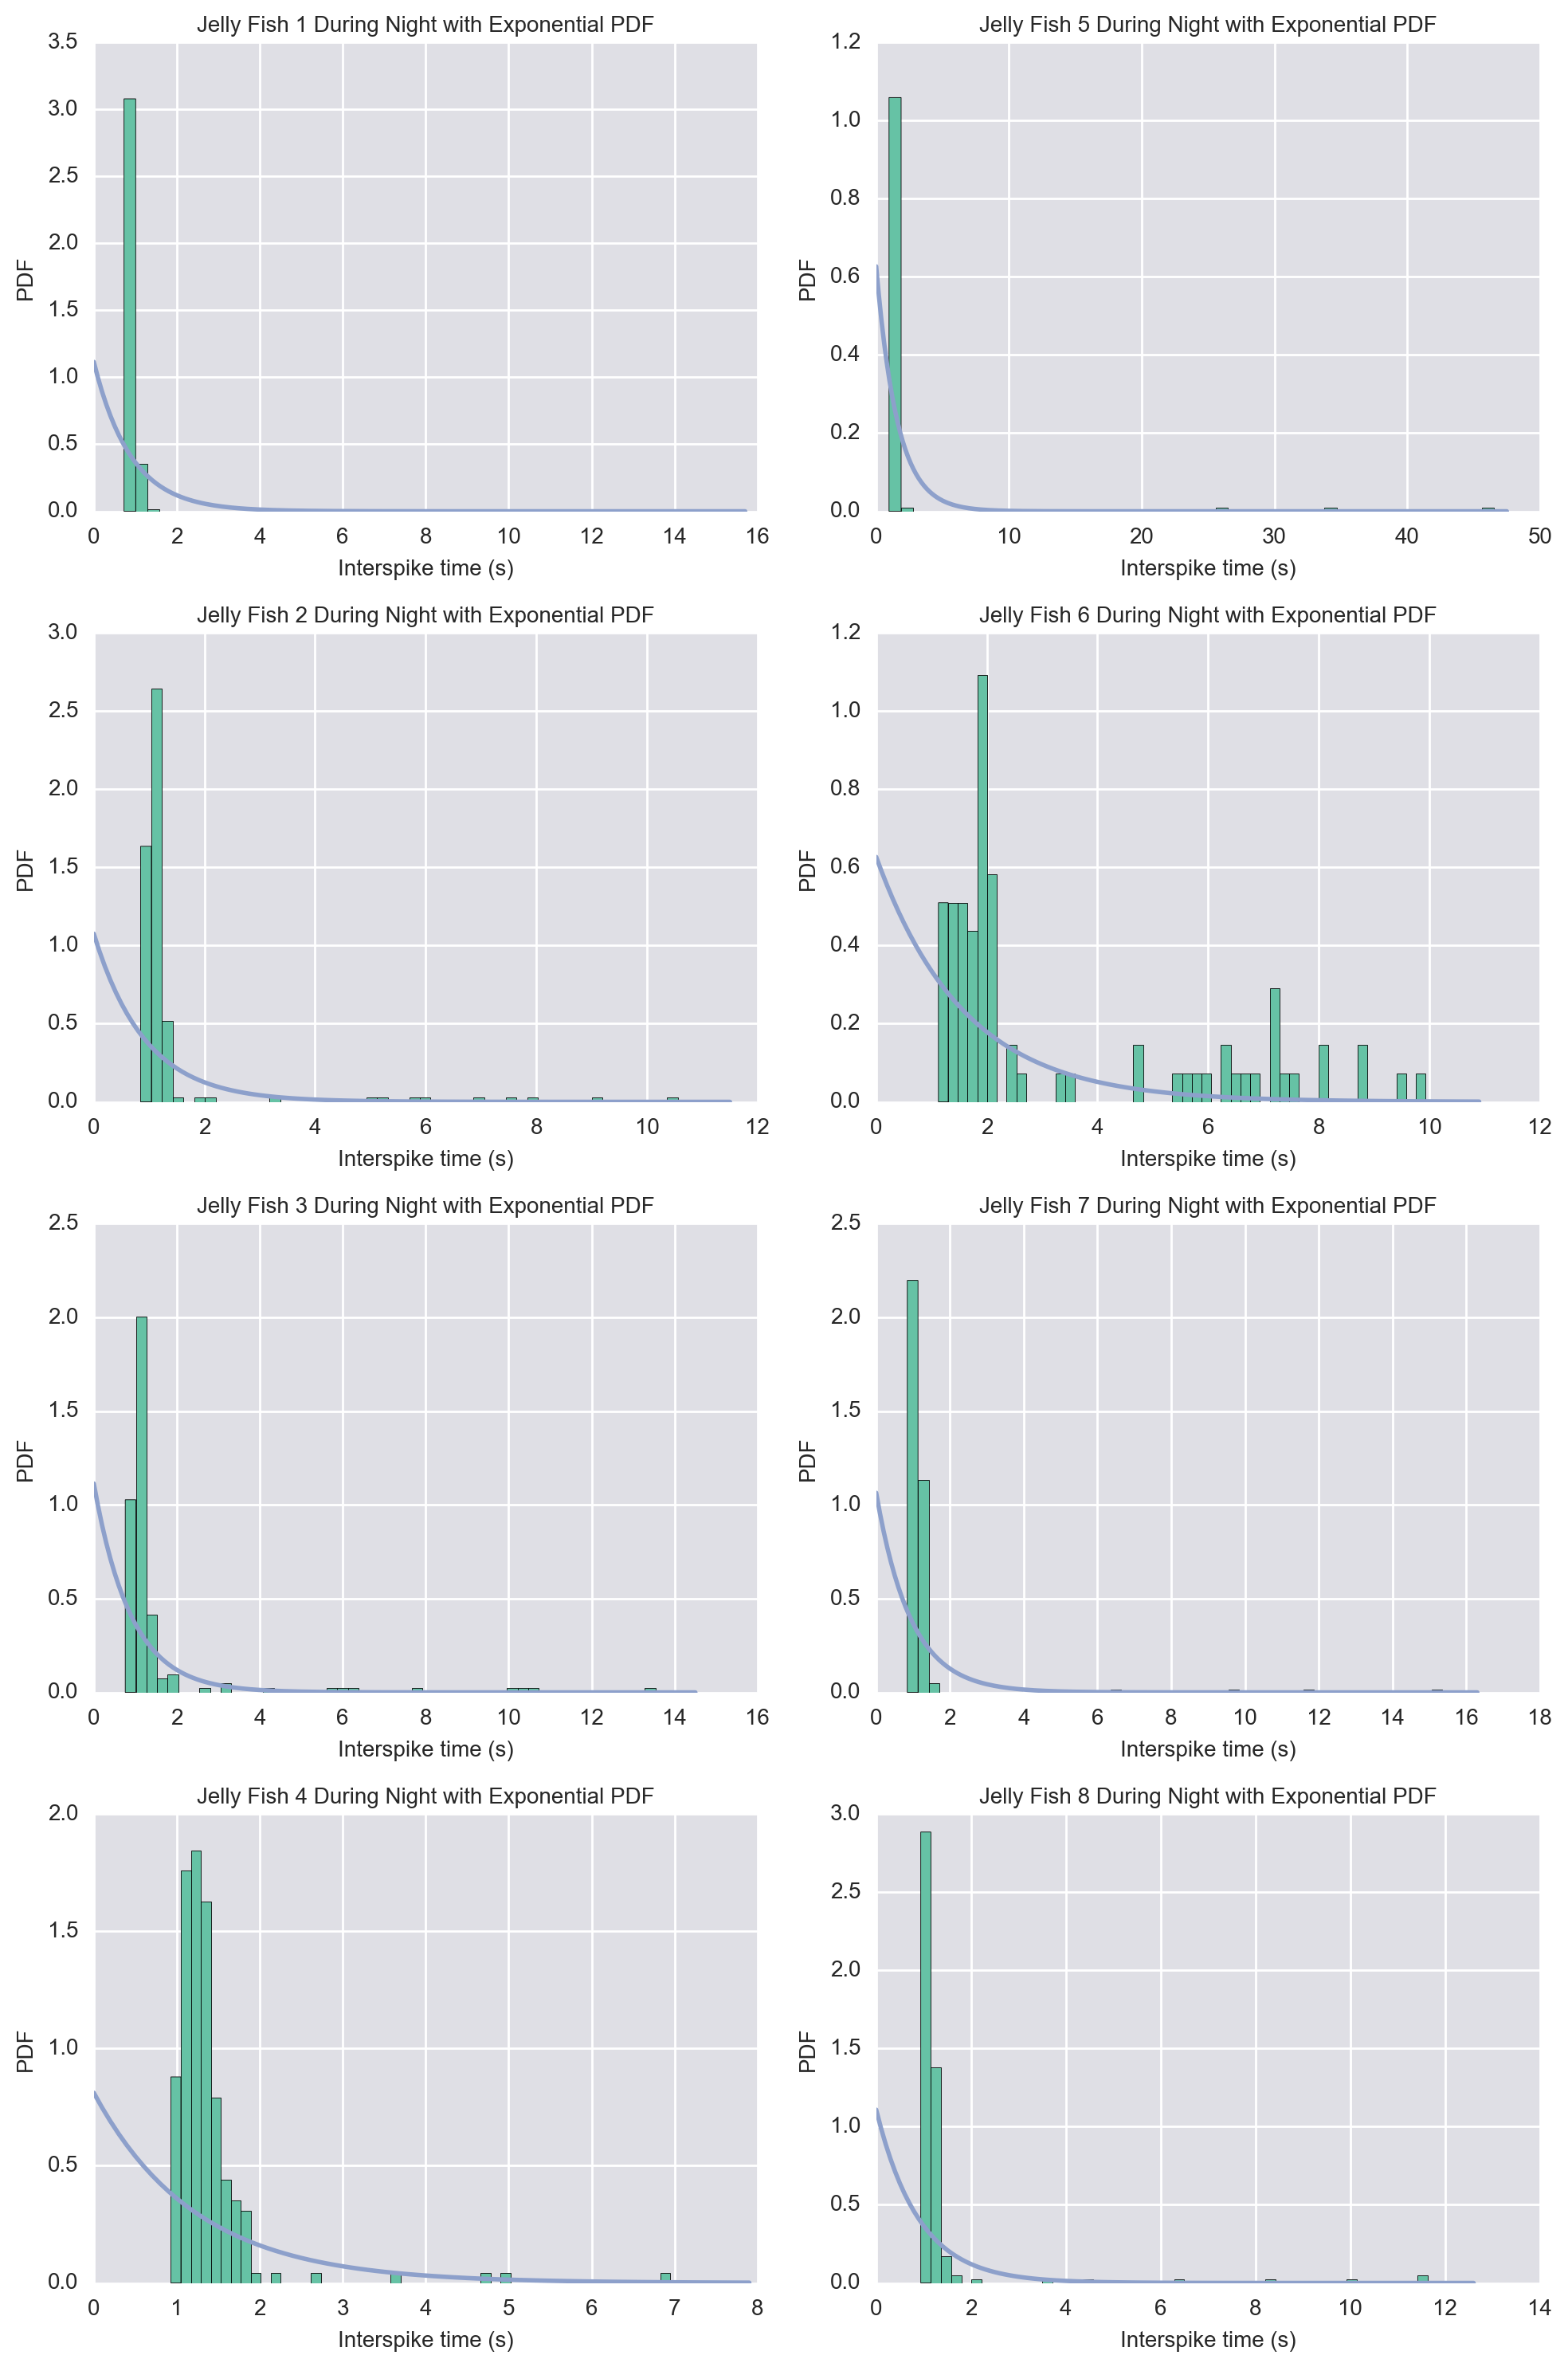

In [122]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_night.Jellyfish.unique()):
    data = np.array(interspike_all[1][i])
    inds = df_tau_day['Jellyfish']==jelly
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau_array = df_tau_day.loc[inds, 'Tau'].values
    tau = tau_array[0].values
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].hist(data, bins=50, normed=True)
    ax[(i%4,i//4)].plot(n_plot,  np.exp(exp_logpmf(n_plot,tau)), '-', 
                        color=sns.color_palette()[2])
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Night with Exponential PDF'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('PDF', size=10)
    
plt.tight_layout()

It doesn't look like a good fit, because the data distribution does not approach the y-axis. Because an gamma distribution is a generalization of the exponential distribution, we also fit the data with a gamma distribution. A gamma distribution has the same parameter $\tau$ as an exponential distribution (i.e., the waiting time to each Poisson process), and it has a second parameter $a$, a location parameter, which is the number of arrivals. Again we have no prior knowledge, so we assume a uniform prior and compute the log-likelihood below:

In [82]:
def log_prior_tau(tau, tau_min, tau_max):
    """
    Log prior for tau.
    """
    if not (tau_min <= tau <= tau_max):
        return -np.inf
    return -np.log(tau) - np.log(np.log(tau_max / tau_min))

def log_prior_a(a, a_min, a_max):
    """
    Log prior for a.
    """
    if not (a_min <= a <= a_max):
        return -np.inf
    return -np.log(a_max - a_min)

def log_prior_gamma(p, tau_min, tau_max, a_min, a_max):
    return log_prior_tau(p[0], tau_min, tau_max) \
                + log_prior_a(p[1], a_min, a_max)

    
def log_like_gamma(p, sum_t, sum_log_t, n):
    """
    Log likelihood for Gamma distributed MT catastrophes.
    """
    tau, a = p
    return -sum_t / tau - n * (a * np.log(tau) + math.lgamma(a)) \
                + (a-1) * sum_log_t

def neg_log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                            a_min, a_max):
    """
    Negative log posterior or Gamma model.
    """
    lp = log_prior_gamma(p, tau_min, tau_max, a_min, a_max)
    if lp == -np.inf:
        return np.inf
    return -lp - log_like_gamma(p, sum_t, sum_log_t, n)

For τ , we take  5 seconds≤τ≤300s. We choose these bounds because images were taken every 1/15sec, which is the fastest resolution time of the experiment. The experiment runs for 300s, so we set that to be the maximum. We also take  1≤a≤30. The lower bound means that at least one Poisson process must arrive for catastrophe, and the upper bound of 30 came from the following reasoning.  a=10  seems like a really high value for  a , but still within the realm of possibility.  a=100 seems impossibly large, so we split the difference and choose the (approximate) geometric mean of 10 and 100.

In [83]:
# Prior parameters
tau_min = 1/15
tau_max = 300
a_min = 1.0
a_max = 30.0

In [84]:
def log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                        a_min, a_max):
    """
    Log posterior gor Gamma model.
    """
    return -neg_log_posterior_gamma(p, sum_t, sum_log_t, n, tau_min, tau_max, 
                        a_min, a_max)


def sample_mcmc(t, n_burn=20000, n_steps=10000, n_walkers=50):
    """
    Given array of catastrophe times, perform MCMC to get mode/HPD for
    parameters a and tau.
    """
    
    # Initialize parameter values
    p_dict = collections.OrderedDict(
        [('tau', (np.random.uniform, (1/15, 300.0))),
         ('a', (np.random.uniform, (1.0, 30.0)))])

    # Set up arguments
    like_args = (np.sum(t), np.sum(np.log(t)), len(t))
    prior_args = (tau_min, tau_max, a_min, a_max)
    args = like_args + prior_args
    
    # Let 'er rip!
    df_mcmc = bebi103.run_ensemble_emcee(log_posterior_gamma, n_burn, n_steps, 
                                   n_walkers=n_walkers, p_dict=p_dict, args=args)

    # Compute mode and HPD
    mode_ind = np.where(
        np.isclose(df_mcmc['lnprob'], df_mcmc['lnprob'].max()))[0][0]
    mode_a = df_mcmc.loc[mode_ind, 'a']
    mode_tau = df_mcmc.loc[mode_ind, 'tau']
    hpd_a = bebi103.hpd(df_mcmc['a'].values, 0.68)
    hpd_tau = bebi103.hpd(df_mcmc['tau'].values, 0.68)
    
    return df_mcmc, mode_a, mode_tau, hpd_a, hpd_tau

In [85]:
# Perform MCMC sampling for each model (Day)
df_tau_day_gamma = pd.DataFrame(columns=['HPD_Tau','HPD_a', 'Tau', 'a', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_a, mode_tau, hpd_a, hpd_tau = sample_mcmc(interspike_all[0][j])
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']].values[0]
    est_a = df_mcmc.loc[max_ind, ['a']].values[0]
    data = {'HPD_Tau': [hpd_tau],
            'HPD_a': [hpd_a],
           'Tau': [est_tau],
            'a':[est_a],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_day_gamma = pd.concat((df_tau_day_gamma, df_add))
    

In [93]:
# Perform MCMC sampling for each model (Night)
df_tau_night_gamma = pd.DataFrame(columns=['HPD_Tau','HPD_a', 'Tau', 'a', 'Jellyfish'])
for j in range(8):
    df_mcmc, mode_a, mode_tau, hpd_a, hpd_tau = sample_mcmc(interspike_all[1][j])
    max_ind = np.argmax(df_mcmc['lnprob'].values)
    est_tau = df_mcmc.loc[max_ind, ['tau']].values[0]
    est_a = df_mcmc.loc[max_ind, ['a']].values[0]
    data = {'HPD_Tau': [hpd_tau],
            'HPD_a': [hpd_a],
           'Tau': [est_tau],
            'a':[est_a],
           'Jellyfish': [j]}
    df_add = pd.DataFrame(data)
    df_tau_night_gamma = pd.concat((df_tau_night_gamma, df_add))
    

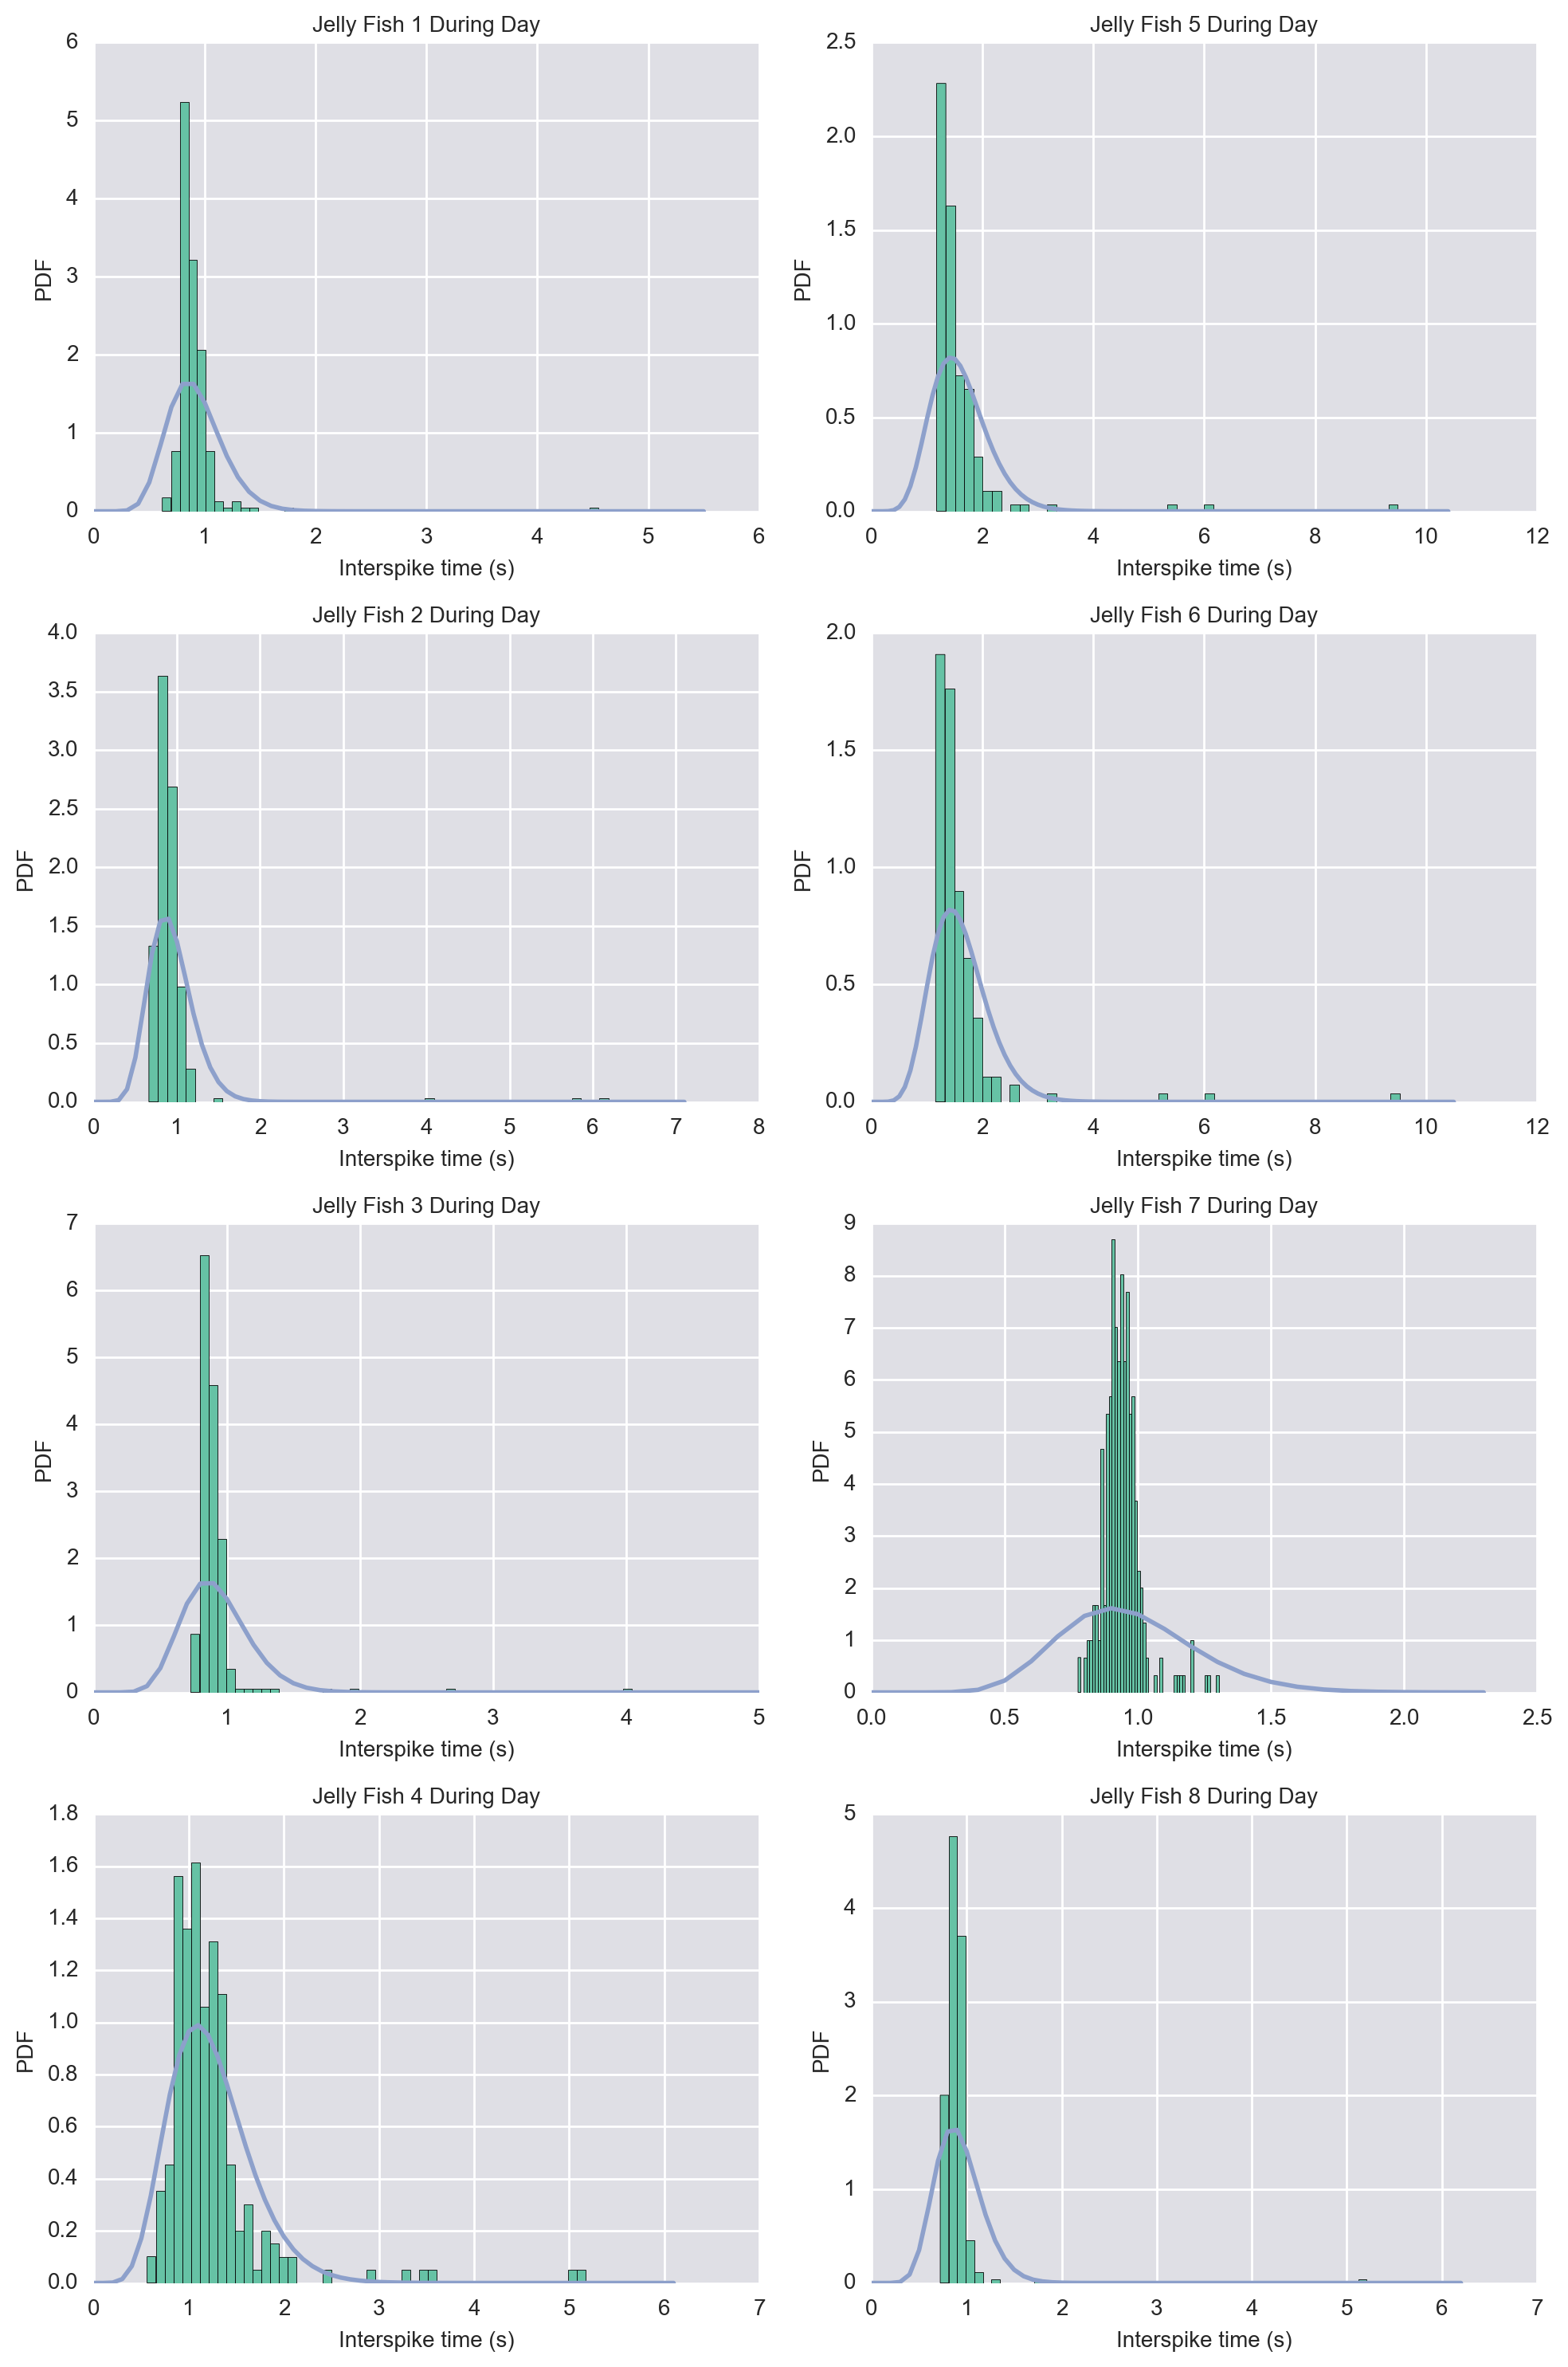

In [118]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_day_gamma.Jellyfish.unique()):
    data = np.array(interspike_all[0][i])
    inds = (df_tau_day_gamma['Jellyfish']==jelly)
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau = df_tau_day_gamma.loc[inds, 'Tau'].values.flatten()
    a = df_tau_day_gamma.loc[inds, 'a'].values.flatten()
    popt_gamma = [tau, a]
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].hist(data, bins=50, normed=True)
    ax[(i%4,i//4)].plot(n_plot,  st.gamma.pdf(n_plot, popt_gamma[1], scale=popt_gamma[0]), '-', 
                        color=sns.color_palette()[2])
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Day'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('PDF', size=10)
    
plt.tight_layout()

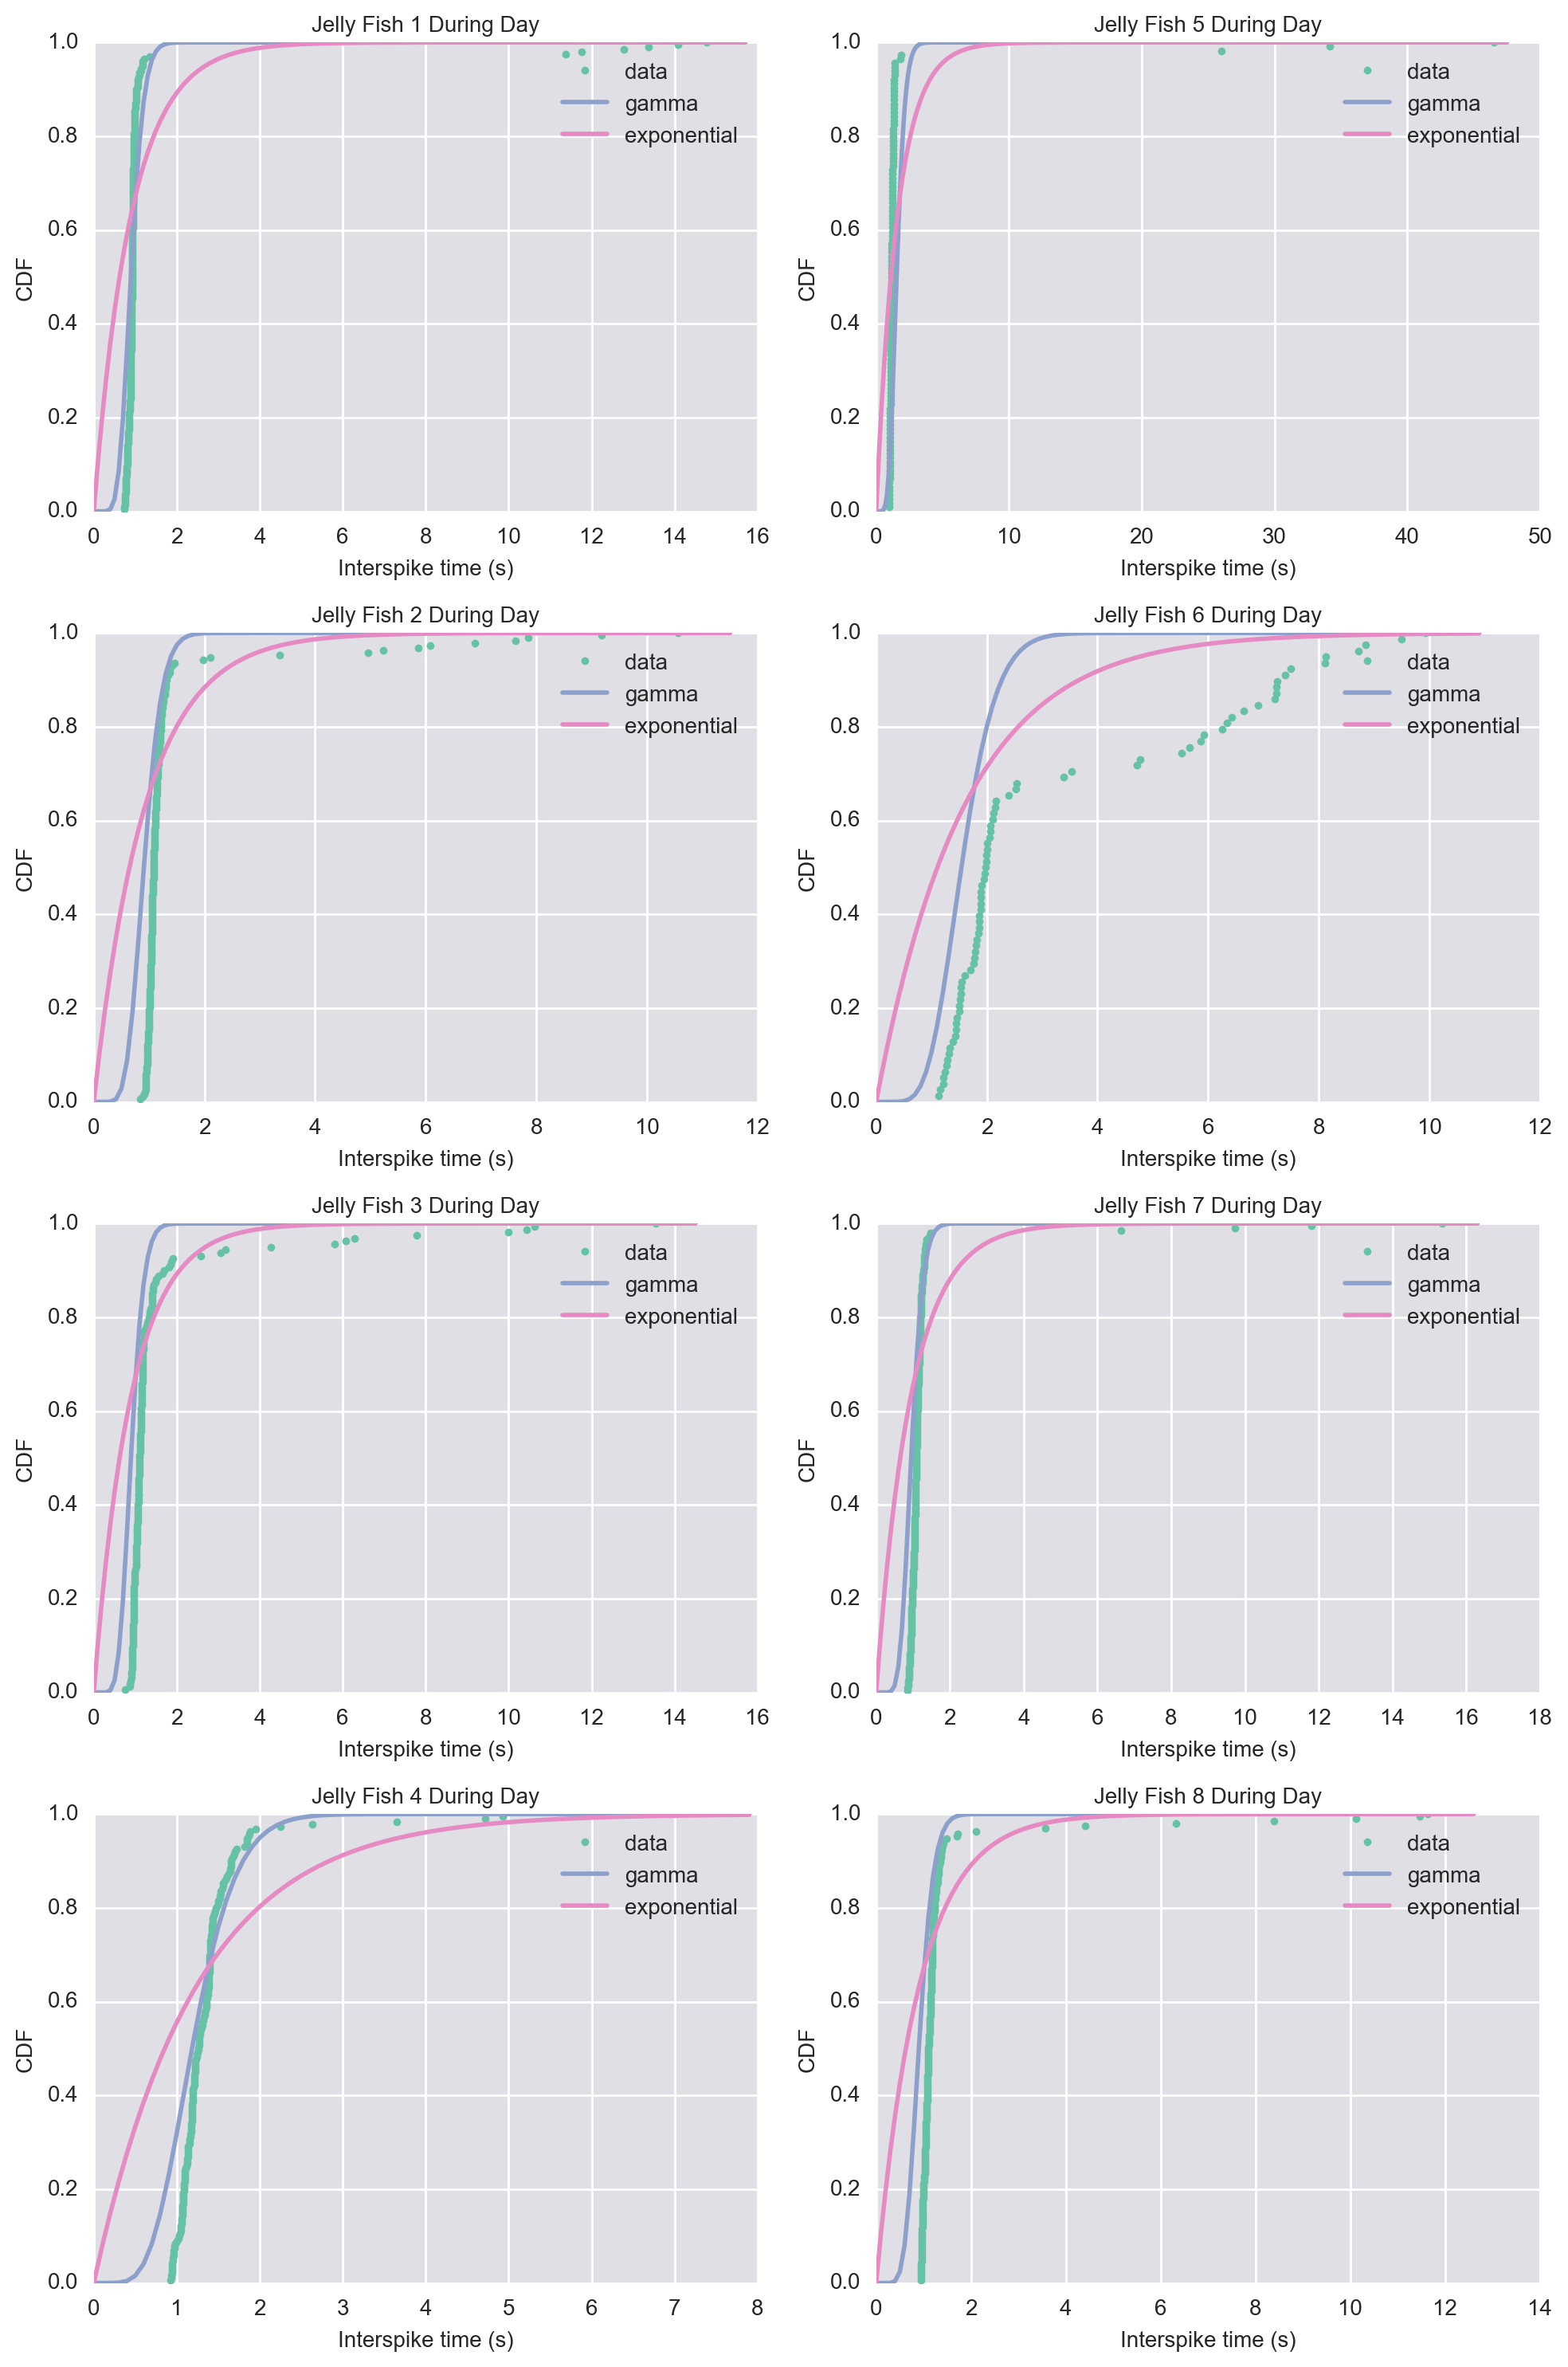

In [119]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_day_gamma.Jellyfish.unique()):
    data = np.array(interspike_all[1][i])
    x, y = bebi103.ecdf(data)
    inds = (df_tau_day_gamma['Jellyfish']==jelly)
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau = df_tau_day_gamma.loc[inds, 'Tau'].values.flatten()
    tau_e = df_tau_day.loc[inds, 'Tau'].values.flatten()
    a = df_tau_day_gamma.loc[inds, 'a'].values.flatten()
    popt_gamma = [tau, a]
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].plot(x, y, '.', label='data')
    ax[(i%4,i//4)].plot(n_plot,  st.gamma.cdf(n_plot, popt_gamma[1], scale=popt_gamma[0]), '-', 
                        color=sns.color_palette()[2], label='gamma')
    ax[(i%4,i//4)].plot(n_plot,  st.expon.cdf(n_plot, scale=tau_e[0][0]), '-', 
                        color=sns.color_palette()[3], label='exponential')
    ax[(i%4,i//4)].legend()
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Day'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('CDF', size=10)
    
plt.tight_layout()

In [87]:
df_tau_day_gamma

HPD_Tau                           HPD_a  \
0  [0.0666666668688, 0.0677376688669]  [13.3198052507, 13.8819555449]   
0  [0.0666706776242, 0.0814495557826]  [11.2528876765, 13.7706080751]   
0  [0.0666666705333, 0.0679826702054]  [13.2863063171, 13.9477003363]   
0    [0.131001166038, 0.162858943946]  [7.46525684859, 9.22608216887]   
0    [0.136771832755, 0.191735487924]   [8.18615056326, 11.386869254]   
0      [0.1435864497, 0.181659885892]   [8.57058033568, 10.789323895]   
0  [0.0666666973273, 0.0674906732784]  [14.1443299001, 14.7584357348]   
0  [0.0666666680748, 0.0675489235494]  [13.4505479729, 13.9560841182]   

   Jellyfish       Tau          a  
0        0.0  0.066667  13.734118  
0        1.0  0.072947  12.742376  
0        2.0  0.066667  13.763273  
0        3.0  0.146098   8.433326  
0        4.0  0.161815   9.852998  
0        5.0  0.161850   9.851424  
0        6.0  0.066667  14.548404  
0        7.0  0.066667  13.823244

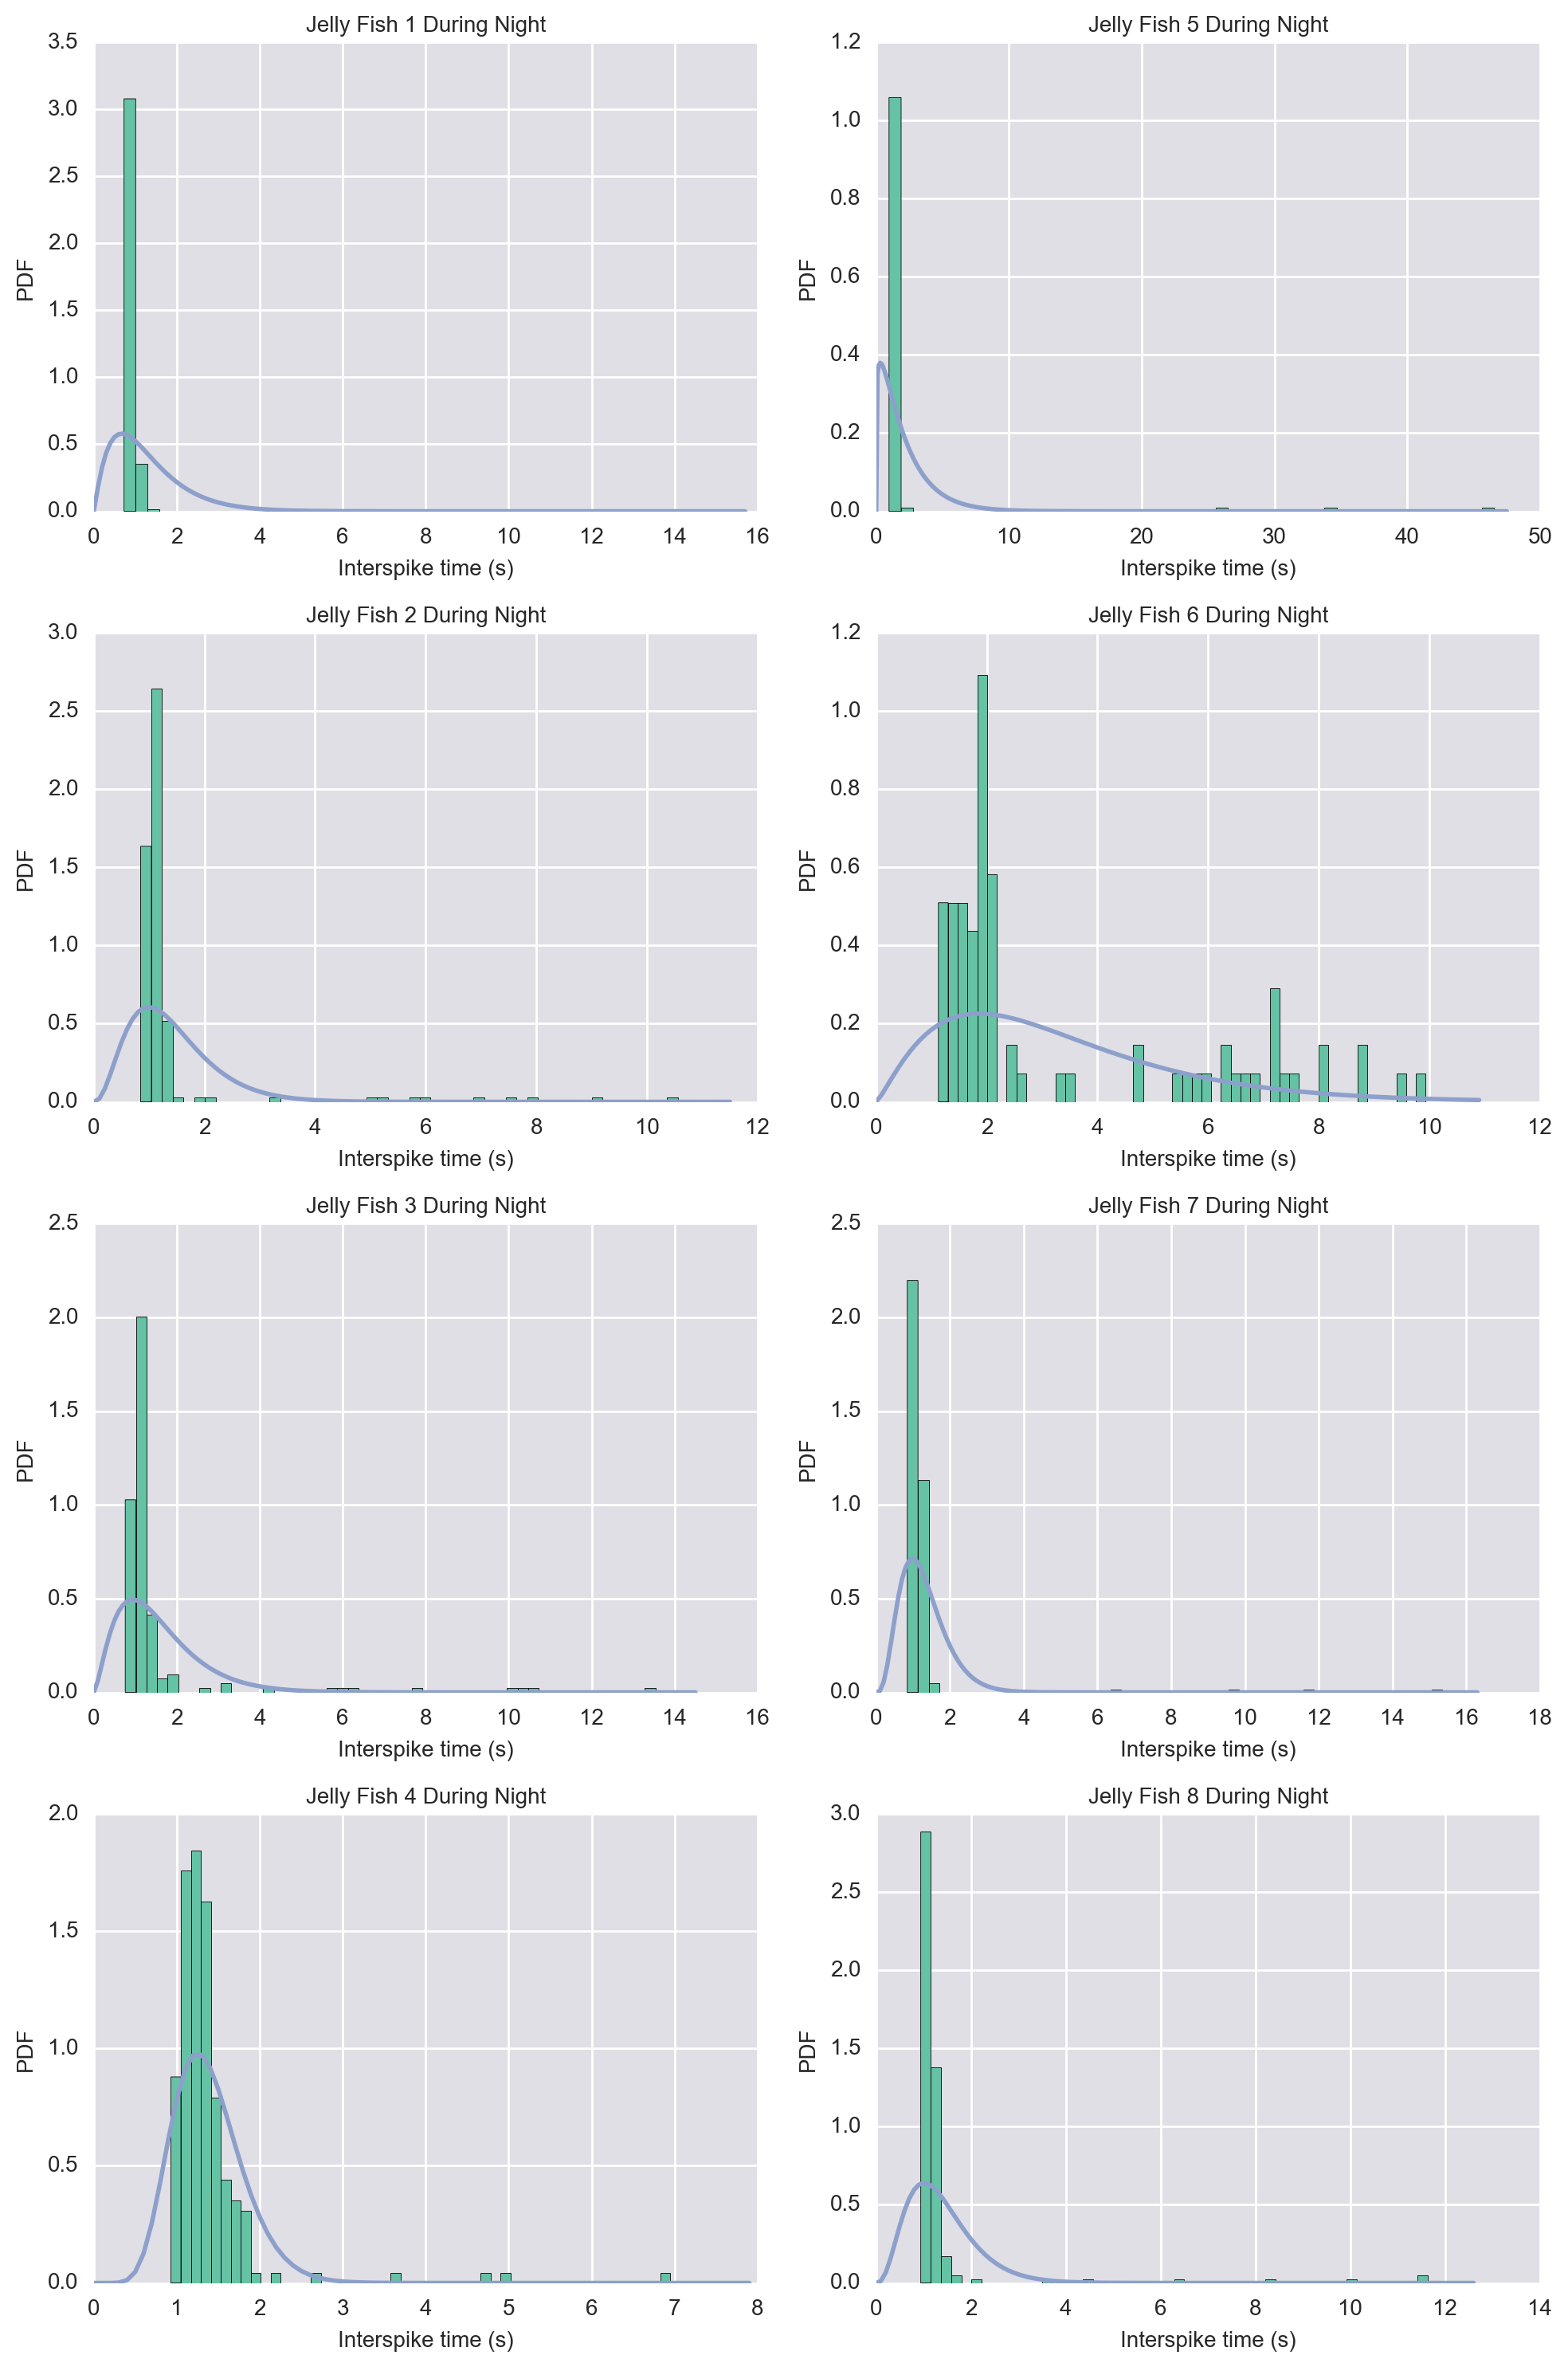

In [114]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_night_gamma.Jellyfish.unique()):
    data = np.array(interspike_all[1][i])
    inds = (df_tau_day_gamma['Jellyfish']==jelly)
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau = df_tau_night_gamma.loc[inds, 'Tau'].values.flatten()
    a = df_tau_night_gamma.loc[inds, 'a'].values.flatten()
    popt_gamma = [tau, a]
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].hist(data, bins=50, normed=True)
    ax[(i%4,i//4)].plot(n_plot,  st.gamma.pdf(n_plot, popt_gamma[1], scale=popt_gamma[0]), '-', 
                        color=sns.color_palette()[2])
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Night'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('PDF', size=10)
plt.tight_layout()

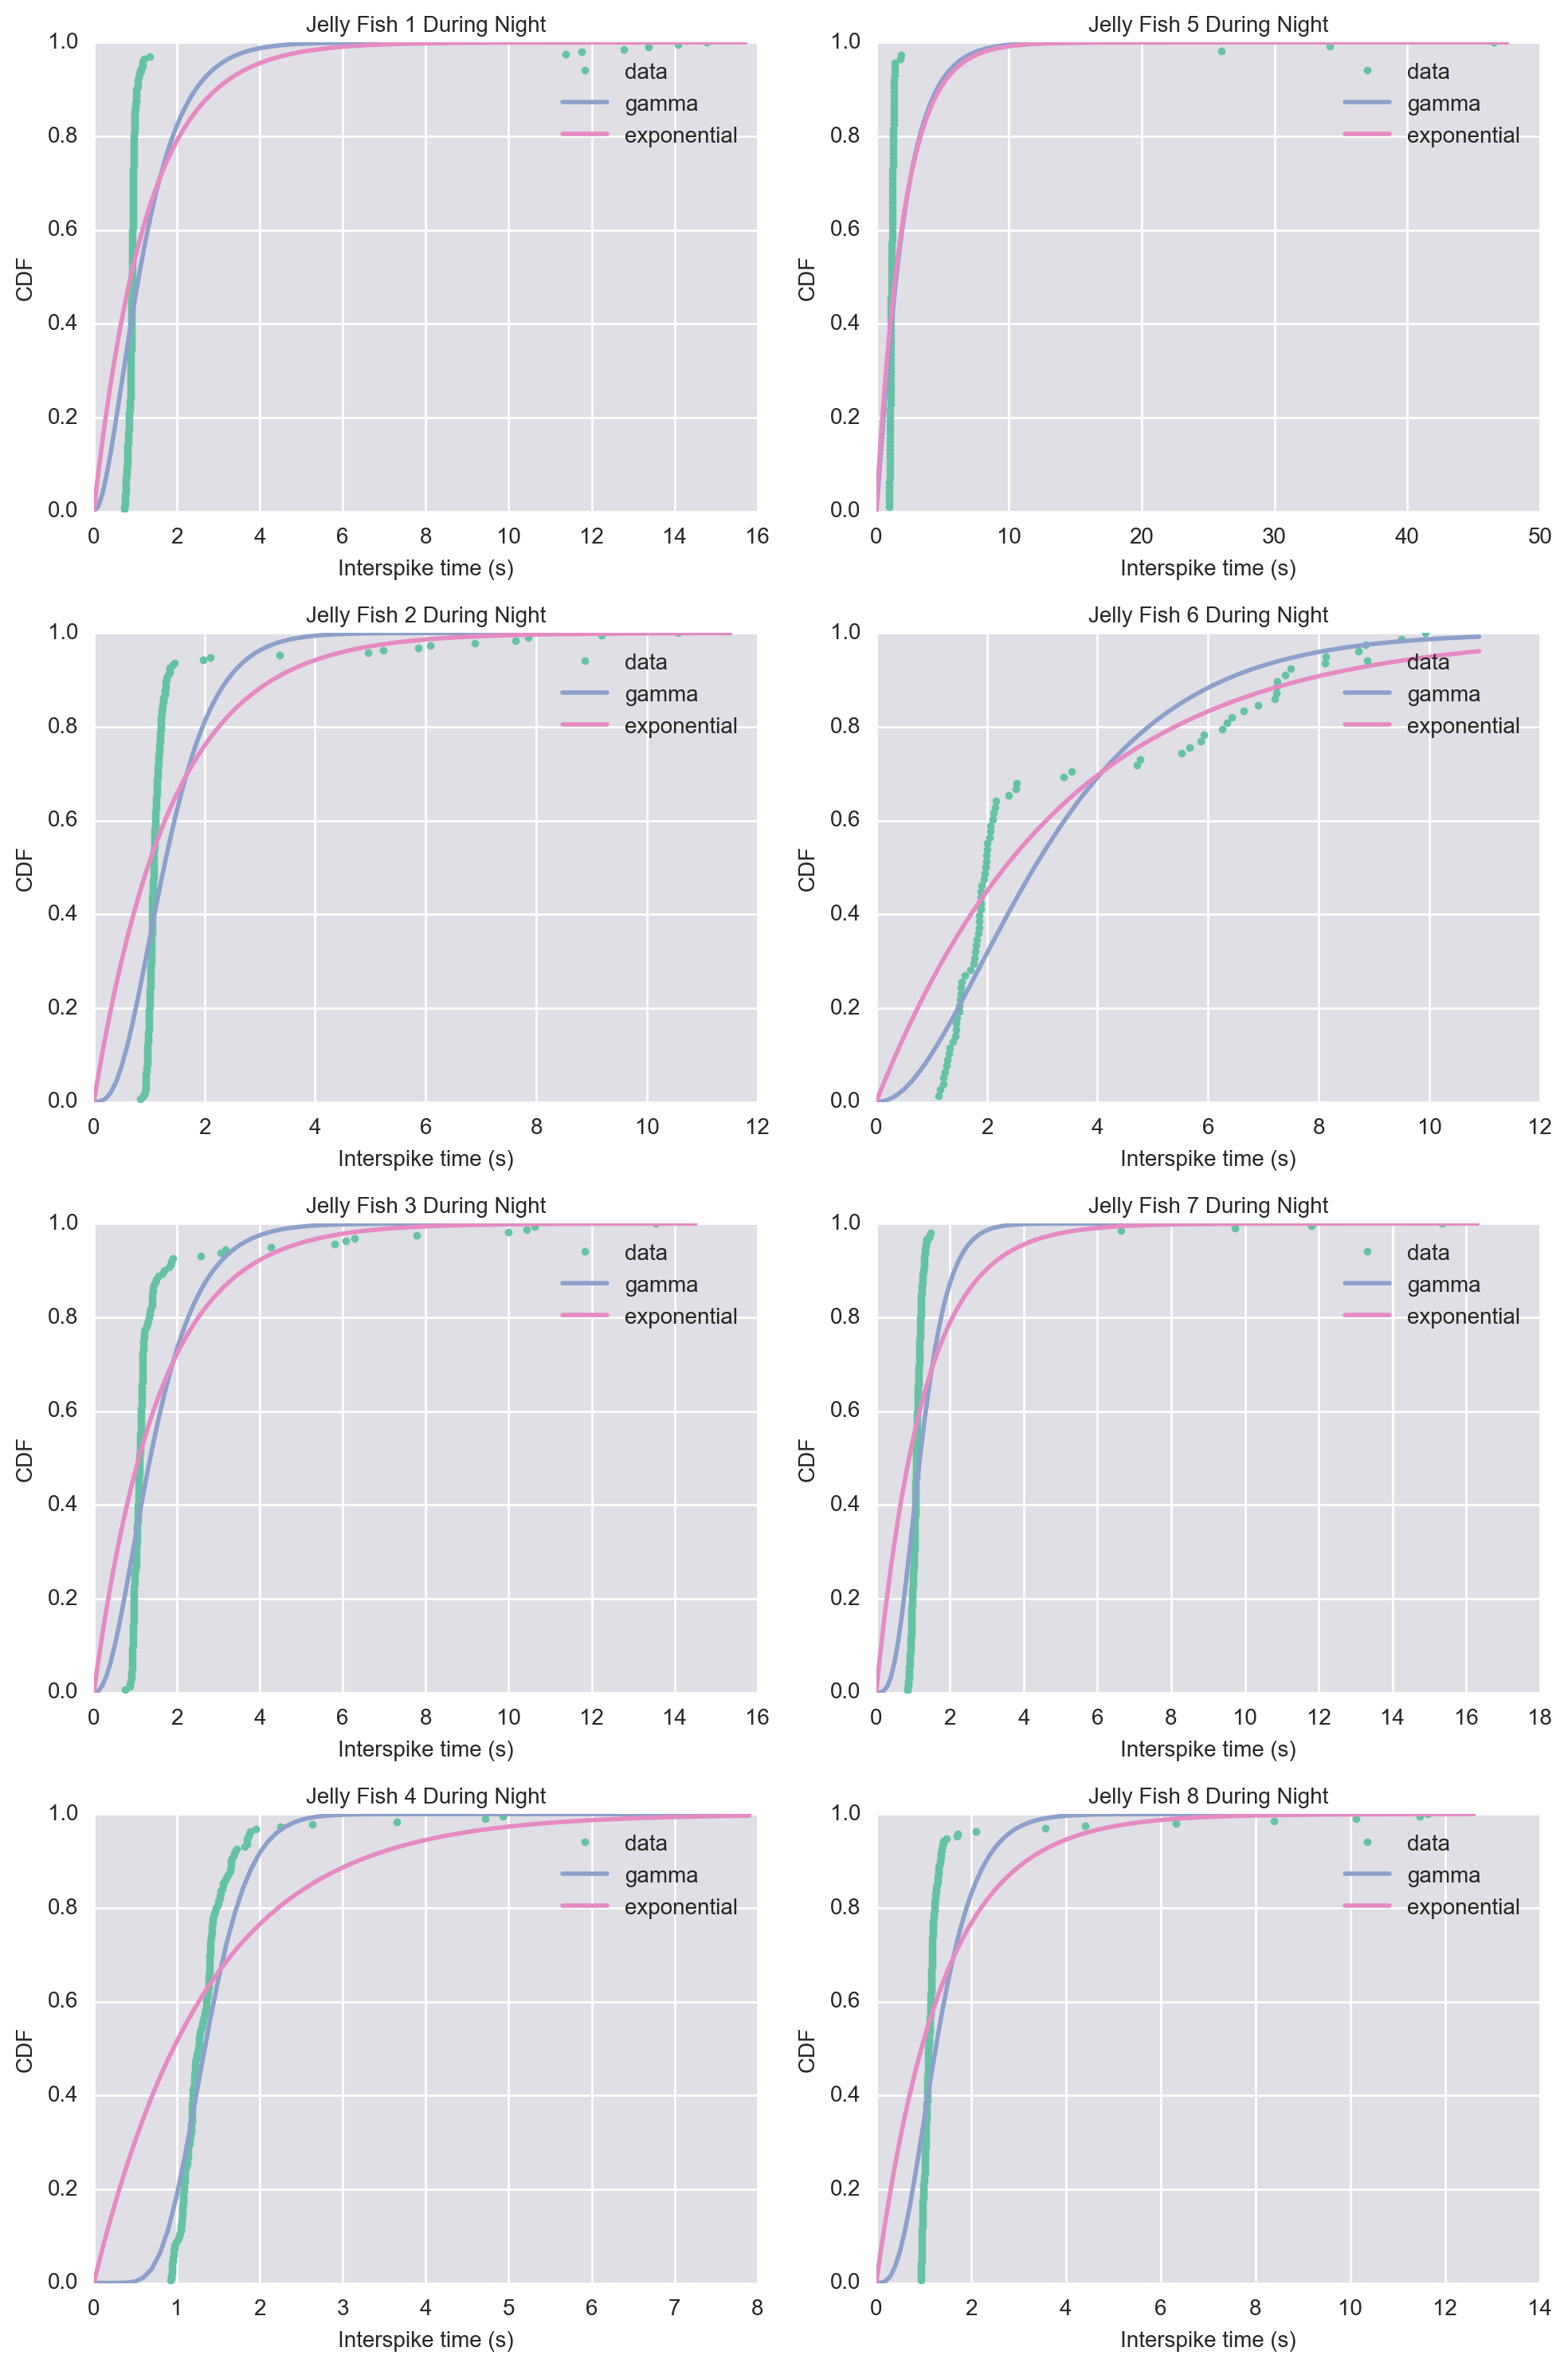

In [116]:
fig, ax = plt.subplots(4,2, figsize=(10,15))
for i, jelly in enumerate(df_tau_night_gamma.Jellyfish.unique()):
    data = np.array(interspike_all[1][i])
    x, y = bebi103.ecdf(data)
    inds = (df_tau_day_gamma['Jellyfish']==jelly)
    # Build theroetical PMF
    n_plot = np.arange(0, data.max()+1, .1)
    tau = df_tau_night_gamma.loc[inds, 'Tau'].values.flatten()
    tau_e = df_tau_night.loc[inds, 'Tau'].values.flatten()
    a = df_tau_night_gamma.loc[inds, 'a'].values.flatten()
    popt_gamma = [tau, a]
    # Plot histogram and PMF
    _ = ax[(i%4,i//4)].plot(x, y, '.', label='data')
    ax[(i%4,i//4)].plot(n_plot,  st.gamma.cdf(n_plot, popt_gamma[1], scale=popt_gamma[0]), '-', 
                        color=sns.color_palette()[2], label='gamma')
    ax[(i%4,i//4)].plot(n_plot,  st.expon.cdf(n_plot, scale=tau_e[0][0]), '-', 
                        color=sns.color_palette()[3], label='exponential')
    ax[(i%4,i//4)].legend()
    ax[(i%4,i//4)].set_title('Jelly Fish {} During Night'.format(i+1), size=10)
    ax[(i%4,i//4)].set_xlabel('Interspike time (s)', size=10)
    ax[(i%4,i//4)].set_ylabel('CDF', size=10)
plt.tight_layout()

The overlay of ECDFs and the gamma and exponential cdfs showed that both distributions are bad fits for night time jellyfish interspike times. 

In [104]:
df_tau_night_gamma

HPD_Tau                           HPD_a  \
0  [0.544380474406, 0.671920623802]  [1.89470031184, 2.28363983823]   
0  [0.352537495211, 0.471176416938]  [2.96750970637, 3.88817980653]   
0  [0.550249237834, 0.695480817097]  [2.22492472987, 2.74865511777]   
0  [0.116860840787, 0.144630943872]  [9.36821194397, 11.5361737895]   
0    [1.51407288826, 1.97072426069]  [1.04379508296, 1.27851774677]   
0     [1.23212054193, 1.7277424069]  [1.88392401683, 2.54124783279]   
0  [0.267761275616, 0.342416196444]  [3.72071557925, 4.69150263956]   
0  [0.322173270869, 0.405294468308]  [3.34788651713, 4.13964616212]   

   Jellyfish       Tau          a  
0        0.0  0.607071   2.108792  
0        1.0  0.406630   3.447415  
0        2.0  0.620026   2.520115  
0        3.0  0.130266  10.594009  
0        4.0  1.753818   1.177602  
0        5.0  1.474198   2.262813  
0        6.0  0.302845   4.245380  
0        7.0  0.362811   3.783848

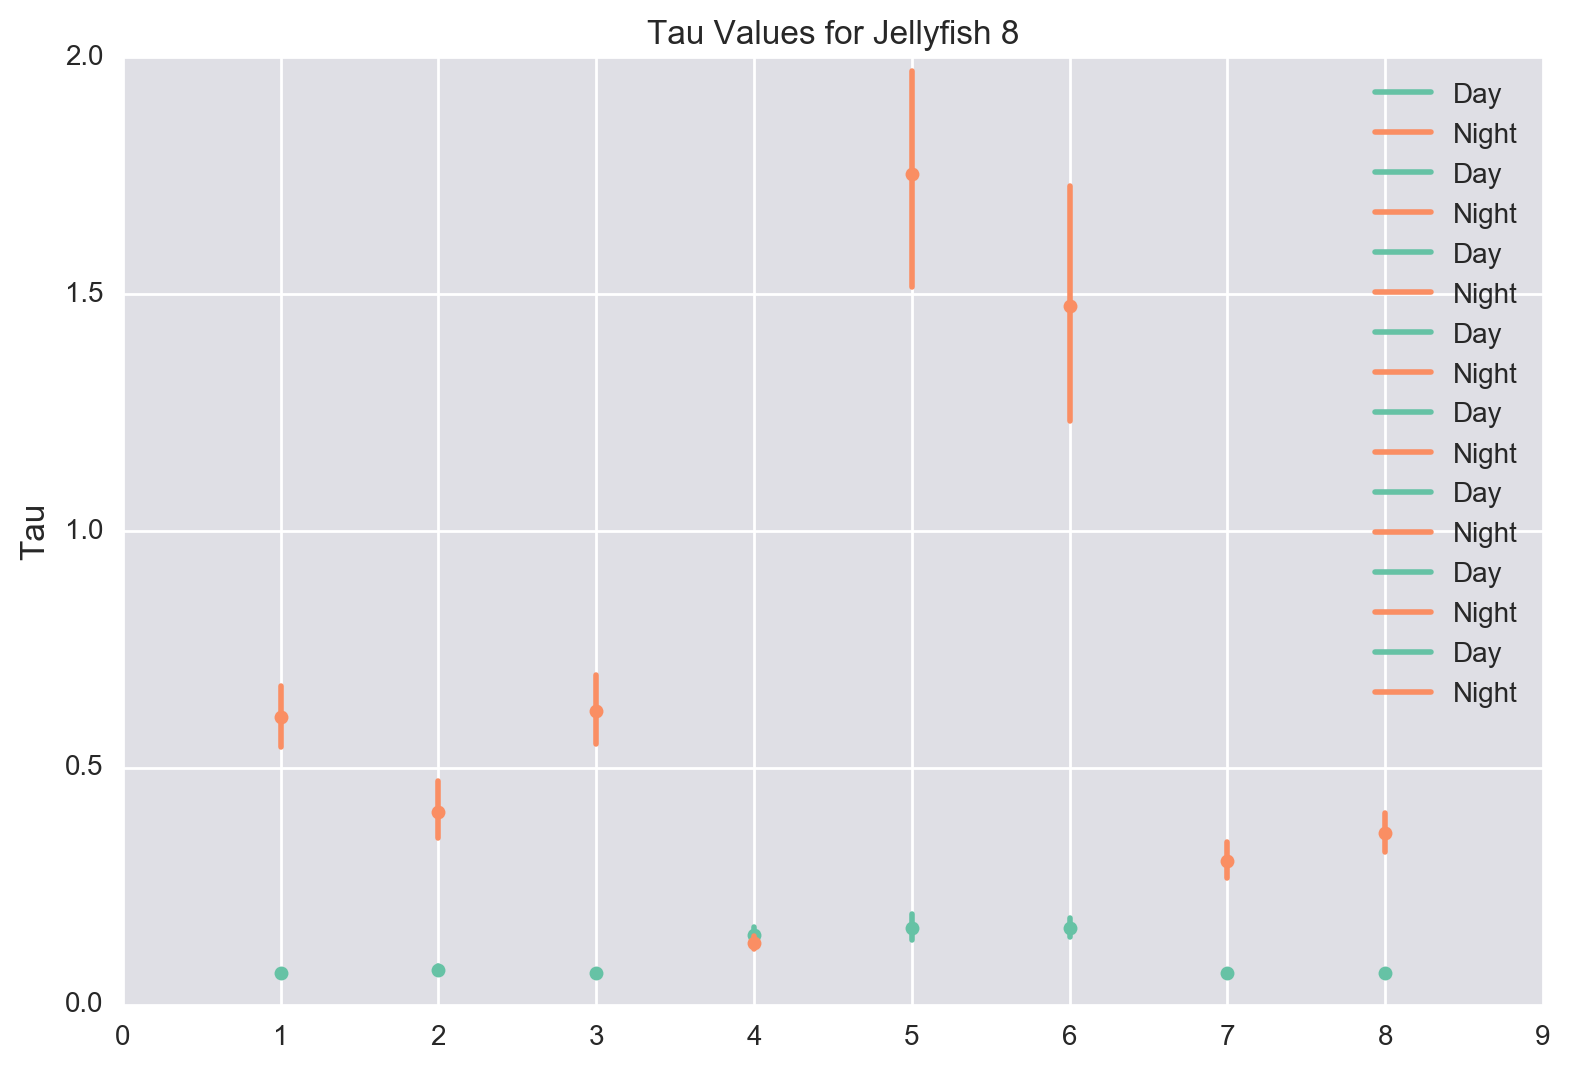

In [107]:
for i in range(8):
    
    # Find values for day
    tau_day = df_tau_day_gamma.loc[df_tau_day_gamma['Jellyfish'] == i, 'Tau'].values
    hpd_day = df_tau_day_gamma.loc[df_tau_day_gamma['Jellyfish'] == i, 'HPD_Tau'].values
    
    # Find values for night
    tau_night = df_tau_night_gamma.loc[df_tau_night_gamma['Jellyfish'] == i, 'Tau'].values
    hpd_night = df_tau_night_gamma.loc[df_tau_night_gamma['Jellyfish'] == i, 'HPD_Tau'].values
    
    # Plot the day values
    plt.plot(i+1, tau_day, marker='o', linestyle='none', markersize=5,
               color=sns.color_palette()[0])
    plt.plot([i+1,i+1], hpd_day[0], color=sns.color_palette()[0], label='Day')
    
    # Plot the night values
    plt.plot(i+1, tau_night, marker='o', linestyle='none', markersize=5,
              color=sns.color_palette()[1])
    plt.plot([i+1,i+1], hpd_night[0], color=sns.color_palette()[1], label='Night')
    
    plt.ylabel('Tau', size=12)
    plt.title( 'Gamma Distribution Tau Values for Jellyfish {}'.format(i+1), size=12)
    plt.xlim((0,9))
    plt.legend()
    
plt.tight_layout()

There is very little variation between differnt jellyfish in the rate of pulsing during the day. However, during night, there is a lot of variation in the rate of pulsing, suggesting that the jelly fish have very different sleeping behavior at night in response to lack of light. Higher tau for jelly fish 5 and 6 suggests that they have lower arrival rate of waking up, so it is sleeping more.

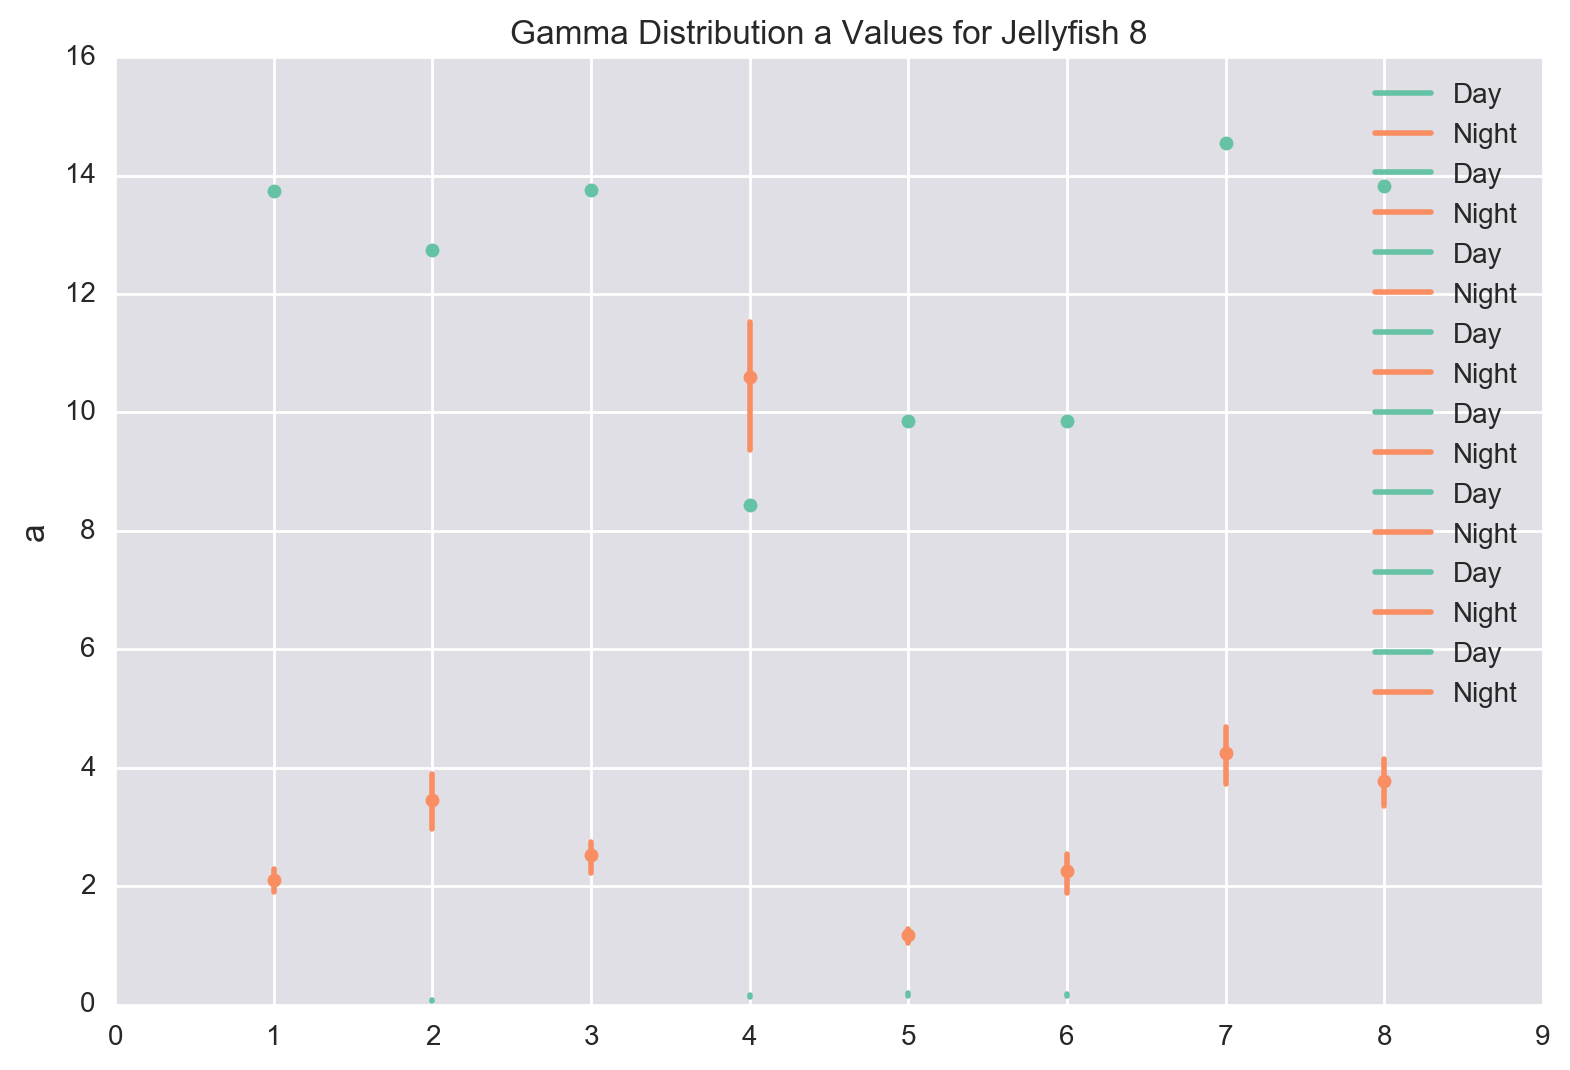

In [108]:
for i in range(8):
    
    # Find values for day
    tau_day = df_tau_day_gamma.loc[df_tau_day_gamma['Jellyfish'] == i, 'a'].values
    hpd_day = df_tau_day_gamma.loc[df_tau_day_gamma['Jellyfish'] == i, 'HPD_Tau'].values
    
    # Find values for night
    tau_night = df_tau_night_gamma.loc[df_tau_night_gamma['Jellyfish'] == i, 'a'].values
    hpd_night = df_tau_night_gamma.loc[df_tau_night_gamma['Jellyfish'] == i, 'HPD_a'].values
    
    # Plot the day values
    plt.plot(i+1, tau_day, marker='o', linestyle='none', markersize=5,
               color=sns.color_palette()[0])
    plt.plot([i+1,i+1], hpd_day[0], color=sns.color_palette()[0], label='Day')
    
    # Plot the night values
    plt.plot(i+1, tau_night, marker='o', linestyle='none', markersize=5,
              color=sns.color_palette()[1])
    plt.plot([i+1,i+1], hpd_night[0], color=sns.color_palette()[1], label='Night')
    
    plt.ylabel('a', size=12)
    plt.title( 'Gamma Distribution a Values for Jellyfish {}'.format(i+1), size=12)
    plt.xlim((0,9))
    plt.legend()
    
plt.tight_layout()

There is very little variation between differnt jellyfish in $a$ , the number of processes determing waking up(pulsing), except for jellyfish 4. There is generally higher number of processes during the day than during the night to determine pulsing. 

<div class="alert alert-info"> <left>
MR comment:
<p>
There is a lot of interesting things you guys explored here. But the document lacks a logic structure. It feels like throwing everything you tried without a clear goal of what is what you are trying to answer.
</p>
<p>
It is okay to explore different things. As a matter of fact I would claim that is vital that you guys do that. But at the end of the day when presenting something is important to gather all the approaches into a cohesive story. Otherwise it becomes very hard for us to make sense of what is what you guys are trying to get at.
</p>
Think about it as a paper. If this was presented to you as a publication you would be like "I have no idea where they were heading to". The same should apply to everything you present in school and future work. We do not necessarily need to know every single approach that you tried, we just need the details on the analysis that you think is the most appropriate. Or if you are going to present more than one approach, you should have a discussion for the pros and cons of each of them and a comparison between the conclusions each analysis gives.
</left></div>

<div class="alert alert-info"> <left>
<p>
55/60
</p>
</left></div>